# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

In [3]:
# 1b events
for i in range(len(files)):
    files[i] = files[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184 && bpt_deepcsv_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
# 2018 mu+tau trigger requirements
trigger24OR27 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc = trigger24OR27 + str(' or ') + trigger2027HPS
trigger_obs_1 = trigger2027 + str(' or ') + trigger24OR27
trigger_obs_2 = trigger2027HPS + str(' or ') + trigger24OR27
trigger_emb = trigger24OR27_emb + str(' or ') + trigger2027HPS_emb


for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files[1] = files[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files[1] = files[1].Filter('m_btt<250')#reject long tail (mostly wrongly reco b jet)

files[2] = files[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1 = files[0].Filter('run<317509').Filter(trigger_obs_1)
obs2 = files[0].Filter('run>=317509').Filter(trigger_obs_2)
files[1] = files[1].Filter(trigger_mc)
files[2] = files[2].Filter(trigger_emb)
files[3] = files[3].Filter(trigger_mc)

# QCD region
qcd1 = obs1.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2 = obs2.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')\
    .Filter('byLooseDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'pt_2', 'm_btt', 'm_b1mu', 'm_b1tau',\
                'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'mT_b1', 'norm_zeta', 'Dzeta',\
                'bpt_deepcsv_1', 'met', 'njets']


# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
    print(i)
qcd1 = pd.DataFrame(qcd1.AsNumpy(feature_list))
print('qcd1')
qcd2 = pd.DataFrame(qcd2.AsNumpy(feature_list))
print('qcd2')
qcd = [qcd1, qcd2]
qcd = pd.concat(qcd)
print('qcd')

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(1,len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

1
2
3
qcd1
qcd2
qcd
(21113, 20)
(183907, 20)
(14326, 20)
(203878, 20)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 3000, random_state = 20)#Z->tautau
files[3] = files[3].sample(n = 9000, random_state = 20)#ttbar
qcd = qcd.sample(n = 9113, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
#df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       pt_2       m_btt      m_b1mu     m_b1tau     dR_tt  \
0      26.552902  23.096636  134.716151   87.394468   79.967418  0.443966   
1      30.559845  21.212145   95.247091   95.558454   74.313853  0.443955   
2      32.337238  27.761415  137.093910  103.593999   81.080431  0.422909   
3      28.619049  20.544367  125.732768   97.449709   76.728530  0.479398   
4      32.073185  22.995504  109.224681   88.021307   64.631897  0.422648   
...          ...        ...         ...         ...         ...       ...   
66044  32.934830  25.182037  135.535495  110.494811   69.284472  0.868182   
11534  37.752003  23.490255  106.909489   65.808954   35.055380  2.114611   
83192  25.590555  25.731640  183.589046   91.866321   67.007466  1.151382   
37009  21.267529  42.523003  187.609457   40.439530  108.921641  3.123214   
61503  26.806684  27.203907  107.824008   41.863577   56.534600  1.892343   

        dR_b1mu  dR_b1tau   dR_b1tt      tt_pt    tt_eta   

## Compare input feature distributions between sig and bkg

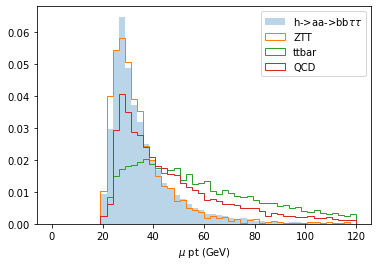

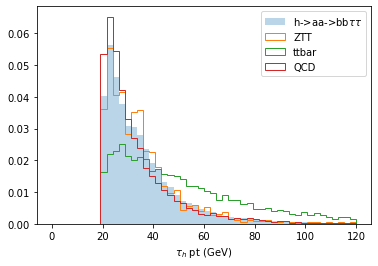

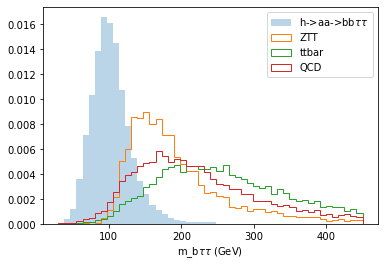

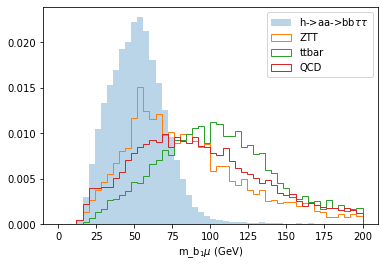

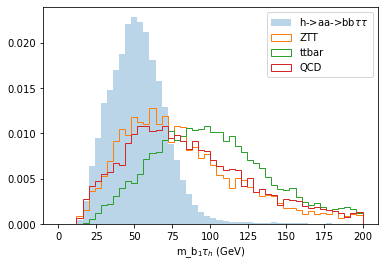

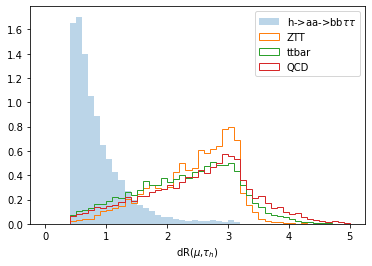

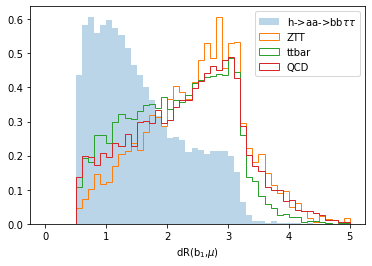

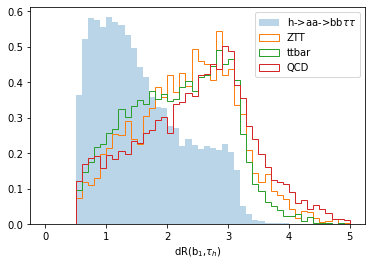

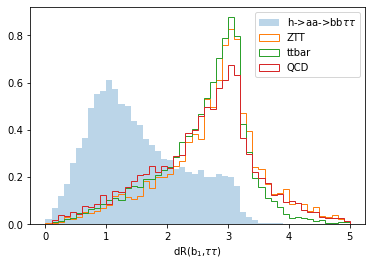

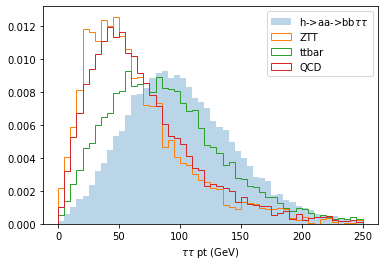

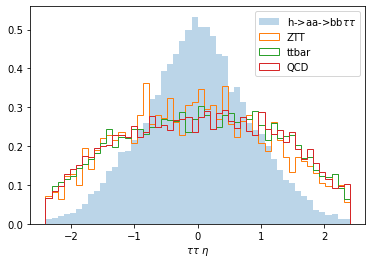

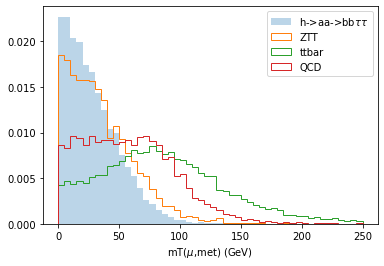

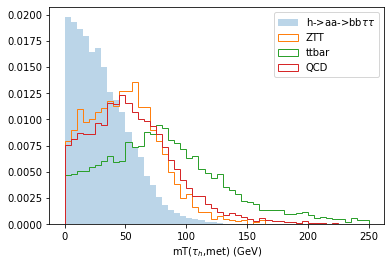

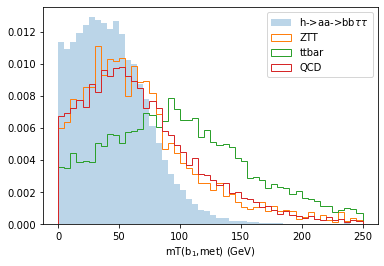

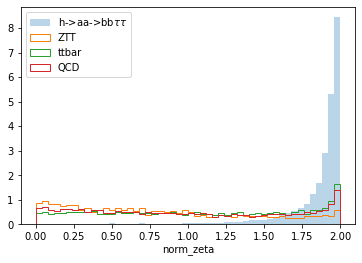

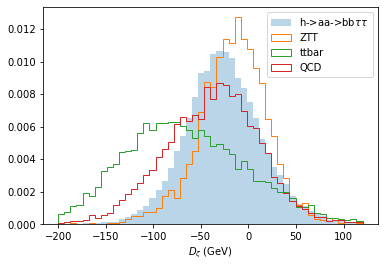

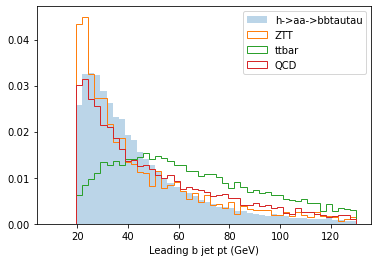

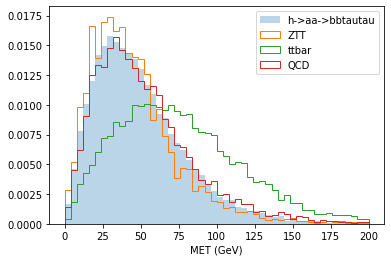

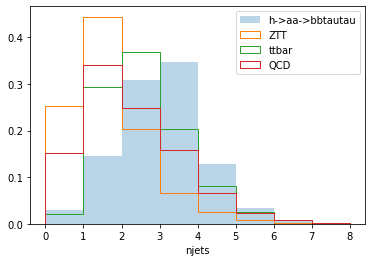

In [8]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau_h$ pt (GeV)')
pyplot.show()


pyplot.hist(files[1]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()


pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


pyplot.hist(files[1]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'best')
pyplot.xlabel('norm_zeta')
pyplot.show()


pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.70/0.20/0.10
X_train.shape: (29557, 19)
Y_train.shape: (29557, 1)
X_val.shape: (8446, 19)
Y_val.shape: (8446, 1)
X_test.shape: (4223, 19)
Y_test.shape: (4223, 1)

Total number of sig/bkg examples: 21113/21113 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 14750/14807 (49.9%/50.1%)
val   : 4242/4204 (50.2%/49.8%)
test  : 2121/2102 (50.2%/49.8%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-11 17:44:50.594864: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-11 17:44:50.595283: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 256)

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 1:14 - loss: 0.7136 - accuracy: 0.57 - ETA: 9s - loss: 0.6582 - accuracy: 0.6353 - ETA: 5s - loss: 0.5944 - accuracy: 0.70 - ETA: 3s - loss: 0.5465 - accuracy: 0.74 - ETA: 2s - loss: 0.4925 - accuracy: 0.78 - ETA: 1s - loss: 0.4535 - accuracy: 0.80 - ETA: 1s - loss: 0.4232 - accuracy: 0.82 - ETA: 1s - loss: 0.3983 - accuracy: 0.83 - ETA: 1s - loss: 0.3765 - accuracy: 0.84 - ETA: 0s - loss: 0.3609 - accuracy: 0.85 - ETA: 0s - loss: 0.3447 - accuracy: 0.85 - ETA: 0s - loss: 0.3328 - accuracy: 0.86 - ETA: 0s - loss: 0.3207 - accuracy: 0.87 - ETA: 0s - loss: 0.3106 - accuracy: 0.87 - ETA: 0s - loss: 0.3015 - accuracy: 0.87 - ETA: 0s - loss: 0.2934 - accuracy: 0.88 - ETA: 0s - loss: 0.2859 - accuracy: 0.88 - 2s 59us/sample - loss: 0.2837 - accuracy: 0.8882 - val_loss: 0.1325 - val_accuracy: 0.9491
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1794 - acc

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7123 - accuracy: 0.543 - ETA: 6s - loss: 0.6546 - accuracy: 0.586 - ETA: 3s - loss: 0.6117 - accuracy: 0.64 - ETA: 2s - loss: 0.5753 - accuracy: 0.68 - ETA: 1s - loss: 0.5446 - accuracy: 0.71 - ETA: 1s - loss: 0.5140 - accuracy: 0.74 - ETA: 1s - loss: 0.4882 - accuracy: 0.76 - ETA: 0s - loss: 0.4643 - accuracy: 0.78 - ETA: 0s - loss: 0.4445 - accuracy: 0.79 - ETA: 0s - loss: 0.4237 - accuracy: 0.80 - ETA: 0s - loss: 0.4060 - accuracy: 0.81 - ETA: 0s - loss: 0.3941 - accuracy: 0.82 - ETA: 0s - loss: 0.3808 - accuracy: 0.83 - ETA: 0s - loss: 0.3693 - accuracy: 0.83 - ETA: 0s - loss: 0.3565 - accuracy: 0.84 - 2s 51us/sample - loss: 0.3562 - accuracy: 0.8447 - val_loss: 0.1414 - val_accuracy: 0.9480
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.89 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - ETA: 0s - loss: 0.1987 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.6777 - accuracy: 0.558 - ETA: 5s - loss: 0.6173 - accuracy: 0.644 - ETA: 3s - loss: 0.5582 - accuracy: 0.72 - ETA: 2s - loss: 0.5136 - accuracy: 0.76 - ETA: 1s - loss: 0.4736 - accuracy: 0.79 - ETA: 1s - loss: 0.4398 - accuracy: 0.81 - ETA: 1s - loss: 0.4101 - accuracy: 0.83 - ETA: 0s - loss: 0.3888 - accuracy: 0.84 - ETA: 0s - loss: 0.3705 - accuracy: 0.85 - ETA: 0s - loss: 0.3532 - accuracy: 0.85 - ETA: 0s - loss: 0.3391 - accuracy: 0.86 - ETA: 0s - loss: 0.3260 - accuracy: 0.87 - ETA: 0s - loss: 0.3154 - accuracy: 0.87 - ETA: 0s - loss: 0.3057 - accuracy: 0.87 - ETA: 0s - loss: 0.2999 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2975 - accuracy: 0.8831 - val_loss: 0.1369 - val_accuracy: 0.9498
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.91 - ETA: 0s - loss: 0.1850 - accuracy: 0.92 - ETA: 0s - loss: 0.1772 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8020 - accuracy: 0.421 - ETA: 7s - loss: 0.7042 - accuracy: 0.556 - ETA: 4s - loss: 0.6394 - accuracy: 0.63 - ETA: 3s - loss: 0.5916 - accuracy: 0.69 - ETA: 2s - loss: 0.5506 - accuracy: 0.72 - ETA: 1s - loss: 0.5062 - accuracy: 0.76 - ETA: 1s - loss: 0.4647 - accuracy: 0.79 - ETA: 1s - loss: 0.4285 - accuracy: 0.81 - ETA: 0s - loss: 0.3996 - accuracy: 0.82 - ETA: 0s - loss: 0.3746 - accuracy: 0.84 - ETA: 0s - loss: 0.3545 - accuracy: 0.85 - ETA: 0s - loss: 0.3411 - accuracy: 0.85 - ETA: 0s - loss: 0.3257 - accuracy: 0.86 - ETA: 0s - loss: 0.3134 - accuracy: 0.86 - ETA: 0s - loss: 0.3033 - accuracy: 0.87 - ETA: 0s - loss: 0.2925 - accuracy: 0.87 - 2s 53us/sample - loss: 0.2903 - accuracy: 0.8810 - val_loss: 0.1284 - val_accuracy: 0.9520
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.96 - ETA: 0s - loss: 0.1781 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7971 - accuracy: 0.550 - ETA: 6s - loss: 0.7147 - accuracy: 0.604 - ETA: 3s - loss: 0.6333 - accuracy: 0.67 - ETA: 2s - loss: 0.5776 - accuracy: 0.72 - ETA: 1s - loss: 0.5294 - accuracy: 0.75 - ETA: 1s - loss: 0.4892 - accuracy: 0.78 - ETA: 1s - loss: 0.4573 - accuracy: 0.80 - ETA: 0s - loss: 0.4274 - accuracy: 0.82 - ETA: 0s - loss: 0.4036 - accuracy: 0.83 - ETA: 0s - loss: 0.3847 - accuracy: 0.84 - ETA: 0s - loss: 0.3668 - accuracy: 0.85 - ETA: 0s - loss: 0.3563 - accuracy: 0.85 - ETA: 0s - loss: 0.3412 - accuracy: 0.86 - ETA: 0s - loss: 0.3288 - accuracy: 0.87 - ETA: 0s - loss: 0.3170 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3118 - accuracy: 0.8779 - val_loss: 0.1282 - val_accuracy: 0.9518
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.94 - ETA: 0s - loss: 0.1574 - accuracy: 0.94 - ETA: 0s - loss: 0.1568 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7125 - accuracy: 0.554 - ETA: 6s - loss: 0.6601 - accuracy: 0.628 - ETA: 3s - loss: 0.5987 - accuracy: 0.69 - ETA: 2s - loss: 0.5454 - accuracy: 0.73 - ETA: 1s - loss: 0.5009 - accuracy: 0.77 - ETA: 1s - loss: 0.4617 - accuracy: 0.79 - ETA: 1s - loss: 0.4314 - accuracy: 0.81 - ETA: 0s - loss: 0.4043 - accuracy: 0.83 - ETA: 0s - loss: 0.3819 - accuracy: 0.84 - ETA: 0s - loss: 0.3641 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.85 - ETA: 0s - loss: 0.3337 - accuracy: 0.86 - ETA: 0s - loss: 0.3217 - accuracy: 0.87 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - ETA: 0s - loss: 0.3003 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2951 - accuracy: 0.8827 - val_loss: 0.1319 - val_accuracy: 0.9509
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1842 - accuracy: 0.94 - ETA: 0s - loss: 0.1805 - accuracy: 0.93 - ETA: 0s - loss: 0.1631 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7213 - accuracy: 0.527 - ETA: 6s - loss: 0.6457 - accuracy: 0.616 - ETA: 3s - loss: 0.5860 - accuracy: 0.68 - ETA: 2s - loss: 0.5333 - accuracy: 0.73 - ETA: 1s - loss: 0.4958 - accuracy: 0.76 - ETA: 1s - loss: 0.4576 - accuracy: 0.79 - ETA: 1s - loss: 0.4276 - accuracy: 0.81 - ETA: 0s - loss: 0.3998 - accuracy: 0.82 - ETA: 0s - loss: 0.3772 - accuracy: 0.83 - ETA: 0s - loss: 0.3620 - accuracy: 0.84 - ETA: 0s - loss: 0.3452 - accuracy: 0.85 - ETA: 0s - loss: 0.3320 - accuracy: 0.86 - ETA: 0s - loss: 0.3195 - accuracy: 0.86 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - ETA: 0s - loss: 0.3001 - accuracy: 0.87 - 1s 51us/sample - loss: 0.2933 - accuracy: 0.8811 - val_loss: 0.1305 - val_accuracy: 0.9518
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.94 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 0s - loss: 0.1662 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7220 - accuracy: 0.535 - ETA: 6s - loss: 0.6337 - accuracy: 0.669 - ETA: 3s - loss: 0.5698 - accuracy: 0.73 - ETA: 2s - loss: 0.5163 - accuracy: 0.78 - ETA: 2s - loss: 0.4765 - accuracy: 0.80 - ETA: 1s - loss: 0.4426 - accuracy: 0.82 - ETA: 1s - loss: 0.4084 - accuracy: 0.84 - ETA: 1s - loss: 0.3842 - accuracy: 0.85 - ETA: 0s - loss: 0.3621 - accuracy: 0.86 - ETA: 0s - loss: 0.3413 - accuracy: 0.87 - ETA: 0s - loss: 0.3253 - accuracy: 0.87 - ETA: 0s - loss: 0.3109 - accuracy: 0.88 - ETA: 0s - loss: 0.3007 - accuracy: 0.88 - ETA: 0s - loss: 0.2885 - accuracy: 0.89 - ETA: 0s - loss: 0.2792 - accuracy: 0.89 - ETA: 0s - loss: 0.2716 - accuracy: 0.90 - 2s 53us/sample - loss: 0.2669 - accuracy: 0.9021 - val_loss: 0.1240 - val_accuracy: 0.9530
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.95 - ETA: 0s - loss: 0.1304 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.8798 - accuracy: 0.519 - ETA: 6s - loss: 0.8148 - accuracy: 0.546 - ETA: 3s - loss: 0.7324 - accuracy: 0.60 - ETA: 2s - loss: 0.6579 - accuracy: 0.65 - ETA: 1s - loss: 0.6001 - accuracy: 0.70 - ETA: 1s - loss: 0.5470 - accuracy: 0.73 - ETA: 1s - loss: 0.5087 - accuracy: 0.76 - ETA: 0s - loss: 0.4717 - accuracy: 0.78 - ETA: 0s - loss: 0.4454 - accuracy: 0.80 - ETA: 0s - loss: 0.4211 - accuracy: 0.81 - ETA: 0s - loss: 0.3991 - accuracy: 0.82 - ETA: 0s - loss: 0.3818 - accuracy: 0.83 - ETA: 0s - loss: 0.3635 - accuracy: 0.84 - ETA: 0s - loss: 0.3505 - accuracy: 0.85 - ETA: 0s - loss: 0.3375 - accuracy: 0.85 - ETA: 0s - loss: 0.3274 - accuracy: 0.86 - 2s 51us/sample - loss: 0.3232 - accuracy: 0.8663 - val_loss: 0.1318 - val_accuracy: 0.9524
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.93 - ETA: 0s - loss: 0.1621 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 59s - loss: 0.7948 - accuracy: 0.441 - ETA: 6s - loss: 0.6825 - accuracy: 0.594 - ETA: 3s - loss: 0.6034 - accuracy: 0.68 - ETA: 2s - loss: 0.5382 - accuracy: 0.74 - ETA: 1s - loss: 0.4915 - accuracy: 0.77 - ETA: 1s - loss: 0.4520 - accuracy: 0.80 - ETA: 1s - loss: 0.4172 - accuracy: 0.82 - ETA: 0s - loss: 0.3853 - accuracy: 0.83 - ETA: 0s - loss: 0.3647 - accuracy: 0.84 - ETA: 0s - loss: 0.3446 - accuracy: 0.85 - ETA: 0s - loss: 0.3273 - accuracy: 0.86 - ETA: 0s - loss: 0.3131 - accuracy: 0.87 - ETA: 0s - loss: 0.3015 - accuracy: 0.87 - ETA: 0s - loss: 0.2920 - accuracy: 0.88 - ETA: 0s - loss: 0.2822 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2791 - accuracy: 0.8898 - val_loss: 0.1286 - val_accuracy: 0.9538
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.93 - ETA: 0s - loss: 0.1700 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7431 - accuracy: 0.492 - ETA: 6s - loss: 0.6932 - accuracy: 0.528 - ETA: 3s - loss: 0.6151 - accuracy: 0.62 - ETA: 2s - loss: 0.5530 - accuracy: 0.70 - ETA: 1s - loss: 0.5005 - accuracy: 0.74 - ETA: 1s - loss: 0.4591 - accuracy: 0.78 - ETA: 1s - loss: 0.4251 - accuracy: 0.80 - ETA: 0s - loss: 0.3944 - accuracy: 0.82 - ETA: 0s - loss: 0.3696 - accuracy: 0.83 - ETA: 0s - loss: 0.3487 - accuracy: 0.84 - ETA: 0s - loss: 0.3335 - accuracy: 0.85 - ETA: 0s - loss: 0.3203 - accuracy: 0.86 - ETA: 0s - loss: 0.3099 - accuracy: 0.86 - ETA: 0s - loss: 0.3003 - accuracy: 0.87 - ETA: 0s - loss: 0.2914 - accuracy: 0.87 - 1s 51us/sample - loss: 0.2858 - accuracy: 0.8791 - val_loss: 0.1292 - val_accuracy: 0.9518
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.91 - ETA: 0s - loss: 0.1596 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.6702 - accuracy: 0.605 - ETA: 5s - loss: 0.5678 - accuracy: 0.747 - ETA: 3s - loss: 0.4932 - accuracy: 0.81 - ETA: 2s - loss: 0.4295 - accuracy: 0.84 - ETA: 1s - loss: 0.3795 - accuracy: 0.87 - ETA: 1s - loss: 0.3429 - accuracy: 0.88 - ETA: 0s - loss: 0.3174 - accuracy: 0.89 - ETA: 0s - loss: 0.2944 - accuracy: 0.89 - ETA: 0s - loss: 0.2797 - accuracy: 0.90 - ETA: 0s - loss: 0.2670 - accuracy: 0.90 - ETA: 0s - loss: 0.2558 - accuracy: 0.91 - ETA: 0s - loss: 0.2468 - accuracy: 0.91 - ETA: 0s - loss: 0.2379 - accuracy: 0.91 - 1s 48us/sample - loss: 0.2308 - accuracy: 0.9211 - val_loss: 0.1224 - val_accuracy: 0.9536
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.94 - ETA: 0s - loss: 0.1704 - accuracy: 0.93 - ETA: 0s - loss: 0.1523 - accuracy: 0.94 - ETA: 0s - loss: 0.1489 - accuracy: 0.94 - ETA: 0s - loss: 0.1462 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8295 - accuracy: 0.527 - ETA: 6s - loss: 0.7469 - accuracy: 0.560 - ETA: 3s - loss: 0.6766 - accuracy: 0.61 - ETA: 2s - loss: 0.6035 - accuracy: 0.68 - ETA: 1s - loss: 0.5452 - accuracy: 0.72 - ETA: 1s - loss: 0.5041 - accuracy: 0.75 - ETA: 1s - loss: 0.4669 - accuracy: 0.78 - ETA: 0s - loss: 0.4346 - accuracy: 0.80 - ETA: 0s - loss: 0.4091 - accuracy: 0.81 - ETA: 0s - loss: 0.3871 - accuracy: 0.83 - ETA: 0s - loss: 0.3696 - accuracy: 0.83 - ETA: 0s - loss: 0.3540 - accuracy: 0.84 - ETA: 0s - loss: 0.3413 - accuracy: 0.85 - ETA: 0s - loss: 0.3277 - accuracy: 0.86 - ETA: 0s - loss: 0.3159 - accuracy: 0.86 - 2s 51us/sample - loss: 0.3074 - accuracy: 0.8711 - val_loss: 0.1289 - val_accuracy: 0.9525
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.93 - ETA: 0s - loss: 0.1719 - accuracy: 0.93 - ETA: 0s - loss: 0.1661 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8372 - accuracy: 0.523 - ETA: 5s - loss: 0.7238 - accuracy: 0.595 - ETA: 3s - loss: 0.6339 - accuracy: 0.67 - ETA: 2s - loss: 0.5678 - accuracy: 0.73 - ETA: 1s - loss: 0.5130 - accuracy: 0.77 - ETA: 1s - loss: 0.4695 - accuracy: 0.79 - ETA: 1s - loss: 0.4351 - accuracy: 0.81 - ETA: 0s - loss: 0.4074 - accuracy: 0.83 - ETA: 0s - loss: 0.3795 - accuracy: 0.84 - ETA: 0s - loss: 0.3592 - accuracy: 0.85 - ETA: 0s - loss: 0.3415 - accuracy: 0.86 - ETA: 0s - loss: 0.3293 - accuracy: 0.86 - ETA: 0s - loss: 0.3174 - accuracy: 0.87 - ETA: 0s - loss: 0.3072 - accuracy: 0.87 - ETA: 0s - loss: 0.2979 - accuracy: 0.88 - 1s 49us/sample - loss: 0.2963 - accuracy: 0.8835 - val_loss: 0.1280 - val_accuracy: 0.9531
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.94 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - ETA: 0s - loss: 0.1612 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6974 - accuracy: 0.480 - ETA: 6s - loss: 0.6583 - accuracy: 0.536 - ETA: 3s - loss: 0.6167 - accuracy: 0.61 - ETA: 2s - loss: 0.5794 - accuracy: 0.68 - ETA: 1s - loss: 0.5448 - accuracy: 0.73 - ETA: 1s - loss: 0.5115 - accuracy: 0.76 - ETA: 1s - loss: 0.4811 - accuracy: 0.78 - ETA: 0s - loss: 0.4566 - accuracy: 0.80 - ETA: 0s - loss: 0.4354 - accuracy: 0.81 - ETA: 0s - loss: 0.4109 - accuracy: 0.83 - ETA: 0s - loss: 0.3910 - accuracy: 0.84 - ETA: 0s - loss: 0.3743 - accuracy: 0.84 - ETA: 0s - loss: 0.3598 - accuracy: 0.85 - ETA: 0s - loss: 0.3455 - accuracy: 0.86 - ETA: 0s - loss: 0.3329 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3259 - accuracy: 0.8704 - val_loss: 0.1389 - val_accuracy: 0.9473
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.95 - ETA: 0s - loss: 0.1734 - accuracy: 0.93 - ETA: 0s - loss: 0.1834 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7401 - accuracy: 0.453 - ETA: 5s - loss: 0.6796 - accuracy: 0.529 - ETA: 3s - loss: 0.6215 - accuracy: 0.60 - ETA: 2s - loss: 0.5704 - accuracy: 0.67 - ETA: 1s - loss: 0.5262 - accuracy: 0.72 - ETA: 1s - loss: 0.4891 - accuracy: 0.75 - ETA: 0s - loss: 0.4569 - accuracy: 0.78 - ETA: 0s - loss: 0.4275 - accuracy: 0.80 - ETA: 0s - loss: 0.4053 - accuracy: 0.81 - ETA: 0s - loss: 0.3841 - accuracy: 0.82 - ETA: 0s - loss: 0.3663 - accuracy: 0.83 - ETA: 0s - loss: 0.3495 - accuracy: 0.84 - ETA: 0s - loss: 0.3374 - accuracy: 0.85 - ETA: 0s - loss: 0.3269 - accuracy: 0.85 - 1s 47us/sample - loss: 0.3262 - accuracy: 0.8596 - val_loss: 0.1348 - val_accuracy: 0.9489
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1716 - accuracy: 0.94 - ETA: 0s - loss: 0.1722 - accuracy: 0.94 - ETA: 0s - loss: 0.1733 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8563 - accuracy: 0.460 - ETA: 5s - loss: 0.7098 - accuracy: 0.564 - ETA: 3s - loss: 0.6207 - accuracy: 0.65 - ETA: 2s - loss: 0.5474 - accuracy: 0.71 - ETA: 1s - loss: 0.4935 - accuracy: 0.75 - ETA: 1s - loss: 0.4501 - accuracy: 0.78 - ETA: 0s - loss: 0.4167 - accuracy: 0.80 - ETA: 0s - loss: 0.3925 - accuracy: 0.81 - ETA: 0s - loss: 0.3718 - accuracy: 0.83 - ETA: 0s - loss: 0.3542 - accuracy: 0.84 - ETA: 0s - loss: 0.3391 - accuracy: 0.85 - ETA: 0s - loss: 0.3257 - accuracy: 0.85 - ETA: 0s - loss: 0.3125 - accuracy: 0.86 - ETA: 0s - loss: 0.3031 - accuracy: 0.87 - 1s 48us/sample - loss: 0.2981 - accuracy: 0.8730 - val_loss: 0.1298 - val_accuracy: 0.9503
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1857 - accuracy: 0.94 - ETA: 0s - loss: 0.1658 - accuracy: 0.94 - ETA: 0s - loss: 0.1662 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.9041 - accuracy: 0.437 - ETA: 7s - loss: 0.7830 - accuracy: 0.510 - ETA: 4s - loss: 0.6939 - accuracy: 0.59 - ETA: 2s - loss: 0.6288 - accuracy: 0.65 - ETA: 2s - loss: 0.5764 - accuracy: 0.70 - ETA: 1s - loss: 0.5264 - accuracy: 0.74 - ETA: 1s - loss: 0.4911 - accuracy: 0.76 - ETA: 1s - loss: 0.4588 - accuracy: 0.78 - ETA: 0s - loss: 0.4319 - accuracy: 0.80 - ETA: 0s - loss: 0.4073 - accuracy: 0.82 - ETA: 0s - loss: 0.3863 - accuracy: 0.83 - ETA: 0s - loss: 0.3710 - accuracy: 0.84 - ETA: 0s - loss: 0.3557 - accuracy: 0.84 - ETA: 0s - loss: 0.3411 - accuracy: 0.85 - ETA: 0s - loss: 0.3282 - accuracy: 0.86 - ETA: 0s - loss: 0.3175 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3113 - accuracy: 0.8711 - val_loss: 0.1307 - val_accuracy: 0.9511
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.96 - ETA: 0s - loss: 0.1649 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6479 - accuracy: 0.601 - ETA: 6s - loss: 0.5877 - accuracy: 0.696 - ETA: 3s - loss: 0.5471 - accuracy: 0.74 - ETA: 2s - loss: 0.5089 - accuracy: 0.77 - ETA: 1s - loss: 0.4746 - accuracy: 0.80 - ETA: 1s - loss: 0.4446 - accuracy: 0.81 - ETA: 1s - loss: 0.4204 - accuracy: 0.83 - ETA: 0s - loss: 0.3958 - accuracy: 0.84 - ETA: 0s - loss: 0.3731 - accuracy: 0.85 - ETA: 0s - loss: 0.3554 - accuracy: 0.86 - ETA: 0s - loss: 0.3397 - accuracy: 0.86 - ETA: 0s - loss: 0.3283 - accuracy: 0.87 - ETA: 0s - loss: 0.3190 - accuracy: 0.87 - ETA: 0s - loss: 0.3091 - accuracy: 0.88 - ETA: 0s - loss: 0.2999 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2937 - accuracy: 0.8878 - val_loss: 0.1295 - val_accuracy: 0.9526
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1664 - accuracy: 0.94 - ETA: 0s - loss: 0.1686 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7437 - accuracy: 0.496 - ETA: 7s - loss: 0.6738 - accuracy: 0.581 - ETA: 4s - loss: 0.6122 - accuracy: 0.66 - ETA: 2s - loss: 0.5513 - accuracy: 0.72 - ETA: 1s - loss: 0.5002 - accuracy: 0.76 - ETA: 1s - loss: 0.4583 - accuracy: 0.79 - ETA: 1s - loss: 0.4273 - accuracy: 0.81 - ETA: 1s - loss: 0.3966 - accuracy: 0.82 - ETA: 0s - loss: 0.3754 - accuracy: 0.84 - ETA: 0s - loss: 0.3577 - accuracy: 0.84 - ETA: 0s - loss: 0.3429 - accuracy: 0.85 - ETA: 0s - loss: 0.3298 - accuracy: 0.86 - ETA: 0s - loss: 0.3150 - accuracy: 0.86 - ETA: 0s - loss: 0.3019 - accuracy: 0.87 - ETA: 0s - loss: 0.2935 - accuracy: 0.88 - ETA: 0s - loss: 0.2853 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2813 - accuracy: 0.8865 - val_loss: 0.1292 - val_accuracy: 0.9518
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.94 - ETA: 0s - loss: 0.1466 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7154 - accuracy: 0.531 - ETA: 6s - loss: 0.6454 - accuracy: 0.592 - ETA: 3s - loss: 0.5979 - accuracy: 0.64 - ETA: 2s - loss: 0.5625 - accuracy: 0.68 - ETA: 1s - loss: 0.5268 - accuracy: 0.71 - ETA: 1s - loss: 0.4959 - accuracy: 0.74 - ETA: 1s - loss: 0.4655 - accuracy: 0.76 - ETA: 0s - loss: 0.4410 - accuracy: 0.78 - ETA: 0s - loss: 0.4203 - accuracy: 0.80 - ETA: 0s - loss: 0.4006 - accuracy: 0.81 - ETA: 0s - loss: 0.3827 - accuracy: 0.82 - ETA: 0s - loss: 0.3699 - accuracy: 0.83 - ETA: 0s - loss: 0.3572 - accuracy: 0.84 - ETA: 0s - loss: 0.3434 - accuracy: 0.84 - ETA: 0s - loss: 0.3323 - accuracy: 0.85 - 1s 49us/sample - loss: 0.3320 - accuracy: 0.8554 - val_loss: 0.1423 - val_accuracy: 0.9468
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.94 - ETA: 0s - loss: 0.1828 - accuracy: 0.93 - ETA: 0s - loss: 0.1775 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 56s - loss: 0.7327 - accuracy: 0.515 - ETA: 6s - loss: 0.6640 - accuracy: 0.614 - ETA: 3s - loss: 0.6023 - accuracy: 0.67 - ETA: 2s - loss: 0.5483 - accuracy: 0.72 - ETA: 1s - loss: 0.5088 - accuracy: 0.76 - ETA: 1s - loss: 0.4717 - accuracy: 0.78 - ETA: 1s - loss: 0.4405 - accuracy: 0.80 - ETA: 0s - loss: 0.4137 - accuracy: 0.82 - ETA: 0s - loss: 0.3912 - accuracy: 0.83 - ETA: 0s - loss: 0.3736 - accuracy: 0.84 - ETA: 0s - loss: 0.3584 - accuracy: 0.85 - ETA: 0s - loss: 0.3456 - accuracy: 0.85 - ETA: 0s - loss: 0.3328 - accuracy: 0.86 - ETA: 0s - loss: 0.3221 - accuracy: 0.86 - ETA: 0s - loss: 0.3127 - accuracy: 0.87 - 1s 50us/sample - loss: 0.3076 - accuracy: 0.8757 - val_loss: 0.1265 - val_accuracy: 0.9525
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.93 - ETA: 0s - loss: 0.1637 - accuracy: 0.94 - ETA: 0s - loss: 0.1739 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8260 - accuracy: 0.441 - ETA: 5s - loss: 0.7144 - accuracy: 0.562 - ETA: 3s - loss: 0.6319 - accuracy: 0.64 - ETA: 2s - loss: 0.5731 - accuracy: 0.70 - ETA: 1s - loss: 0.5240 - accuracy: 0.74 - ETA: 1s - loss: 0.4819 - accuracy: 0.77 - ETA: 0s - loss: 0.4507 - accuracy: 0.79 - ETA: 0s - loss: 0.4258 - accuracy: 0.80 - ETA: 0s - loss: 0.4042 - accuracy: 0.82 - ETA: 0s - loss: 0.3831 - accuracy: 0.83 - ETA: 0s - loss: 0.3693 - accuracy: 0.84 - ETA: 0s - loss: 0.3563 - accuracy: 0.84 - ETA: 0s - loss: 0.3431 - accuracy: 0.85 - ETA: 0s - loss: 0.3326 - accuracy: 0.86 - 1s 48us/sample - loss: 0.3278 - accuracy: 0.8630 - val_loss: 0.1409 - val_accuracy: 0.9496
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.91 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1922 - accuracy: 0.93 - ETA: 0s - loss: 0.1891 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7030 - accuracy: 0.574 - ETA: 5s - loss: 0.6310 - accuracy: 0.626 - ETA: 3s - loss: 0.5739 - accuracy: 0.68 - ETA: 2s - loss: 0.5262 - accuracy: 0.72 - ETA: 1s - loss: 0.4895 - accuracy: 0.76 - ETA: 1s - loss: 0.4559 - accuracy: 0.78 - ETA: 0s - loss: 0.4330 - accuracy: 0.80 - ETA: 0s - loss: 0.4136 - accuracy: 0.81 - ETA: 0s - loss: 0.3963 - accuracy: 0.82 - ETA: 0s - loss: 0.3792 - accuracy: 0.83 - ETA: 0s - loss: 0.3657 - accuracy: 0.84 - ETA: 0s - loss: 0.3531 - accuracy: 0.85 - ETA: 0s - loss: 0.3406 - accuracy: 0.85 - ETA: 0s - loss: 0.3297 - accuracy: 0.86 - 1s 48us/sample - loss: 0.3263 - accuracy: 0.8666 - val_loss: 0.1414 - val_accuracy: 0.9486
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.91 - ETA: 0s - loss: 0.2074 - accuracy: 0.92 - ETA: 0s - loss: 0.2084 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8043 - accuracy: 0.460 - ETA: 6s - loss: 0.6848 - accuracy: 0.576 - ETA: 3s - loss: 0.6256 - accuracy: 0.64 - ETA: 2s - loss: 0.5672 - accuracy: 0.69 - ETA: 1s - loss: 0.5175 - accuracy: 0.74 - ETA: 1s - loss: 0.4768 - accuracy: 0.77 - ETA: 1s - loss: 0.4446 - accuracy: 0.79 - ETA: 0s - loss: 0.4166 - accuracy: 0.81 - ETA: 0s - loss: 0.3926 - accuracy: 0.82 - ETA: 0s - loss: 0.3714 - accuracy: 0.83 - ETA: 0s - loss: 0.3557 - accuracy: 0.84 - ETA: 0s - loss: 0.3430 - accuracy: 0.85 - ETA: 0s - loss: 0.3286 - accuracy: 0.85 - ETA: 0s - loss: 0.3178 - accuracy: 0.86 - ETA: 0s - loss: 0.3085 - accuracy: 0.87 - 1s 50us/sample - loss: 0.3029 - accuracy: 0.8734 - val_loss: 0.1335 - val_accuracy: 0.9471
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.95 - ETA: 0s - loss: 0.1850 - accuracy: 0.93 - ETA: 0s - loss: 0.1756 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6956 - accuracy: 0.554 - ETA: 5s - loss: 0.5909 - accuracy: 0.675 - ETA: 3s - loss: 0.5229 - accuracy: 0.74 - ETA: 2s - loss: 0.4702 - accuracy: 0.78 - ETA: 1s - loss: 0.4308 - accuracy: 0.80 - ETA: 1s - loss: 0.3946 - accuracy: 0.83 - ETA: 1s - loss: 0.3702 - accuracy: 0.84 - ETA: 0s - loss: 0.3480 - accuracy: 0.85 - ETA: 0s - loss: 0.3313 - accuracy: 0.86 - ETA: 0s - loss: 0.3168 - accuracy: 0.86 - ETA: 0s - loss: 0.3038 - accuracy: 0.87 - ETA: 0s - loss: 0.2933 - accuracy: 0.88 - ETA: 0s - loss: 0.2848 - accuracy: 0.88 - ETA: 0s - loss: 0.2765 - accuracy: 0.88 - ETA: 0s - loss: 0.2683 - accuracy: 0.89 - 1s 49us/sample - loss: 0.2676 - accuracy: 0.8930 - val_loss: 0.1303 - val_accuracy: 0.9502
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.93 - ETA: 0s - loss: 0.1839 - accuracy: 0.93 - ETA: 0s - loss: 0.1754 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7279 - accuracy: 0.566 - ETA: 6s - loss: 0.6298 - accuracy: 0.657 - ETA: 3s - loss: 0.5705 - accuracy: 0.71 - ETA: 2s - loss: 0.5180 - accuracy: 0.75 - ETA: 1s - loss: 0.4728 - accuracy: 0.78 - ETA: 1s - loss: 0.4391 - accuracy: 0.81 - ETA: 1s - loss: 0.4150 - accuracy: 0.82 - ETA: 0s - loss: 0.3907 - accuracy: 0.83 - ETA: 0s - loss: 0.3722 - accuracy: 0.84 - ETA: 0s - loss: 0.3586 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.85 - ETA: 0s - loss: 0.3319 - accuracy: 0.86 - ETA: 0s - loss: 0.3210 - accuracy: 0.87 - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - ETA: 0s - loss: 0.3027 - accuracy: 0.87 - ETA: 0s - loss: 0.2940 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2935 - accuracy: 0.8828 - val_loss: 0.1364 - val_accuracy: 0.9505
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.91 - ETA: 0s - loss: 0.2054 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8296 - accuracy: 0.429 - ETA: 7s - loss: 0.7355 - accuracy: 0.509 - ETA: 4s - loss: 0.6662 - accuracy: 0.58 - ETA: 2s - loss: 0.6098 - accuracy: 0.65 - ETA: 2s - loss: 0.5550 - accuracy: 0.70 - ETA: 1s - loss: 0.5128 - accuracy: 0.74 - ETA: 1s - loss: 0.4729 - accuracy: 0.77 - ETA: 1s - loss: 0.4390 - accuracy: 0.79 - ETA: 0s - loss: 0.4154 - accuracy: 0.80 - ETA: 0s - loss: 0.3946 - accuracy: 0.81 - ETA: 0s - loss: 0.3790 - accuracy: 0.82 - ETA: 0s - loss: 0.3645 - accuracy: 0.83 - ETA: 0s - loss: 0.3512 - accuracy: 0.84 - ETA: 0s - loss: 0.3393 - accuracy: 0.85 - ETA: 0s - loss: 0.3280 - accuracy: 0.85 - ETA: 0s - loss: 0.3193 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3136 - accuracy: 0.8651 - val_loss: 0.1326 - val_accuracy: 0.9496
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.94 - ETA: 0s - loss: 0.1714 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7386 - accuracy: 0.515 - ETA: 6s - loss: 0.6665 - accuracy: 0.618 - ETA: 3s - loss: 0.5886 - accuracy: 0.69 - ETA: 2s - loss: 0.5257 - accuracy: 0.74 - ETA: 1s - loss: 0.4836 - accuracy: 0.77 - ETA: 1s - loss: 0.4440 - accuracy: 0.80 - ETA: 1s - loss: 0.4125 - accuracy: 0.82 - ETA: 0s - loss: 0.3867 - accuracy: 0.83 - ETA: 0s - loss: 0.3658 - accuracy: 0.84 - ETA: 0s - loss: 0.3497 - accuracy: 0.85 - ETA: 0s - loss: 0.3368 - accuracy: 0.86 - ETA: 0s - loss: 0.3250 - accuracy: 0.86 - ETA: 0s - loss: 0.3138 - accuracy: 0.87 - ETA: 0s - loss: 0.3030 - accuracy: 0.87 - ETA: 0s - loss: 0.2935 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2886 - accuracy: 0.8848 - val_loss: 0.1358 - val_accuracy: 0.9478
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.92 - ETA: 0s - loss: 0.1710 - accuracy: 0.94 - ETA: 0s - loss: 0.1694 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7878 - accuracy: 0.503 - ETA: 6s - loss: 0.6961 - accuracy: 0.577 - ETA: 3s - loss: 0.6384 - accuracy: 0.64 - ETA: 2s - loss: 0.5838 - accuracy: 0.71 - ETA: 1s - loss: 0.5324 - accuracy: 0.75 - ETA: 1s - loss: 0.4895 - accuracy: 0.78 - ETA: 1s - loss: 0.4532 - accuracy: 0.80 - ETA: 0s - loss: 0.4211 - accuracy: 0.82 - ETA: 0s - loss: 0.3951 - accuracy: 0.83 - ETA: 0s - loss: 0.3737 - accuracy: 0.84 - ETA: 0s - loss: 0.3548 - accuracy: 0.85 - ETA: 0s - loss: 0.3396 - accuracy: 0.86 - ETA: 0s - loss: 0.3257 - accuracy: 0.86 - ETA: 0s - loss: 0.3125 - accuracy: 0.87 - ETA: 0s - loss: 0.3016 - accuracy: 0.87 - 1s 50us/sample - loss: 0.2989 - accuracy: 0.8798 - val_loss: 0.1261 - val_accuracy: 0.9510
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - ETA: 0s - loss: 0.1662 - accuracy: 0.93 - ETA: 0s - loss: 0.1599 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6531 - accuracy: 0.543 - ETA: 6s - loss: 0.6143 - accuracy: 0.582 - ETA: 3s - loss: 0.5802 - accuracy: 0.63 - ETA: 2s - loss: 0.5462 - accuracy: 0.67 - ETA: 1s - loss: 0.5154 - accuracy: 0.71 - ETA: 1s - loss: 0.4822 - accuracy: 0.74 - ETA: 1s - loss: 0.4576 - accuracy: 0.77 - ETA: 1s - loss: 0.4349 - accuracy: 0.79 - ETA: 0s - loss: 0.4158 - accuracy: 0.80 - ETA: 0s - loss: 0.3945 - accuracy: 0.82 - ETA: 0s - loss: 0.3763 - accuracy: 0.83 - ETA: 0s - loss: 0.3628 - accuracy: 0.83 - ETA: 0s - loss: 0.3480 - accuracy: 0.84 - ETA: 0s - loss: 0.3361 - accuracy: 0.85 - ETA: 0s - loss: 0.3247 - accuracy: 0.85 - ETA: 0s - loss: 0.3168 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3161 - accuracy: 0.8647 - val_loss: 0.1428 - val_accuracy: 0.9475
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.92 - ETA: 0s - loss: 0.1906 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7179 - accuracy: 0.527 - ETA: 6s - loss: 0.6409 - accuracy: 0.629 - ETA: 3s - loss: 0.5741 - accuracy: 0.69 - ETA: 2s - loss: 0.5209 - accuracy: 0.74 - ETA: 1s - loss: 0.4775 - accuracy: 0.77 - ETA: 1s - loss: 0.4367 - accuracy: 0.80 - ETA: 1s - loss: 0.4039 - accuracy: 0.82 - ETA: 0s - loss: 0.3830 - accuracy: 0.83 - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - ETA: 0s - loss: 0.3462 - accuracy: 0.85 - ETA: 0s - loss: 0.3314 - accuracy: 0.86 - ETA: 0s - loss: 0.3195 - accuracy: 0.86 - ETA: 0s - loss: 0.3083 - accuracy: 0.87 - ETA: 0s - loss: 0.2977 - accuracy: 0.87 - ETA: 0s - loss: 0.2902 - accuracy: 0.88 - ETA: 0s - loss: 0.2815 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2777 - accuracy: 0.8871 - val_loss: 0.1309 - val_accuracy: 0.9509
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.92 - ETA: 0s - loss: 0.1689 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7036 - accuracy: 0.574 - ETA: 6s - loss: 0.6467 - accuracy: 0.652 - ETA: 3s - loss: 0.5946 - accuracy: 0.71 - ETA: 2s - loss: 0.5534 - accuracy: 0.74 - ETA: 1s - loss: 0.5121 - accuracy: 0.77 - ETA: 1s - loss: 0.4773 - accuracy: 0.80 - ETA: 1s - loss: 0.4477 - accuracy: 0.82 - ETA: 0s - loss: 0.4237 - accuracy: 0.83 - ETA: 0s - loss: 0.4022 - accuracy: 0.84 - ETA: 0s - loss: 0.3823 - accuracy: 0.85 - ETA: 0s - loss: 0.3629 - accuracy: 0.85 - ETA: 0s - loss: 0.3474 - accuracy: 0.86 - ETA: 0s - loss: 0.3345 - accuracy: 0.87 - ETA: 0s - loss: 0.3226 - accuracy: 0.87 - ETA: 0s - loss: 0.3121 - accuracy: 0.88 - 2s 51us/sample - loss: 0.3039 - accuracy: 0.8842 - val_loss: 0.1305 - val_accuracy: 0.9511
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.87 - ETA: 0s - loss: 0.1717 - accuracy: 0.93 - ETA: 0s - loss: 0.1726 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8567 - accuracy: 0.457 - ETA: 6s - loss: 0.7524 - accuracy: 0.530 - ETA: 3s - loss: 0.6890 - accuracy: 0.59 - ETA: 2s - loss: 0.6416 - accuracy: 0.63 - ETA: 1s - loss: 0.5972 - accuracy: 0.67 - ETA: 1s - loss: 0.5571 - accuracy: 0.71 - ETA: 1s - loss: 0.5252 - accuracy: 0.73 - ETA: 0s - loss: 0.4972 - accuracy: 0.75 - ETA: 0s - loss: 0.4686 - accuracy: 0.77 - ETA: 0s - loss: 0.4485 - accuracy: 0.78 - ETA: 0s - loss: 0.4280 - accuracy: 0.79 - ETA: 0s - loss: 0.4118 - accuracy: 0.80 - ETA: 0s - loss: 0.3962 - accuracy: 0.81 - ETA: 0s - loss: 0.3819 - accuracy: 0.82 - ETA: 0s - loss: 0.3676 - accuracy: 0.83 - ETA: 0s - loss: 0.3644 - accuracy: 0.83 - 2s 56us/sample - loss: 0.3570 - accuracy: 0.8404 - val_loss: 0.1352 - val_accuracy: 0.9497
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.92 - ETA: 0s - loss: 0.1801 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.6571 - accuracy: 0.605 - ETA: 5s - loss: 0.5570 - accuracy: 0.753 - ETA: 3s - loss: 0.4844 - accuracy: 0.82 - ETA: 2s - loss: 0.4222 - accuracy: 0.85 - ETA: 1s - loss: 0.3754 - accuracy: 0.87 - ETA: 1s - loss: 0.3390 - accuracy: 0.88 - ETA: 0s - loss: 0.3161 - accuracy: 0.89 - ETA: 0s - loss: 0.2954 - accuracy: 0.89 - ETA: 0s - loss: 0.2793 - accuracy: 0.90 - ETA: 0s - loss: 0.2675 - accuracy: 0.90 - ETA: 0s - loss: 0.2562 - accuracy: 0.91 - ETA: 0s - loss: 0.2474 - accuracy: 0.91 - ETA: 0s - loss: 0.2399 - accuracy: 0.91 - 1s 48us/sample - loss: 0.2332 - accuracy: 0.9196 - val_loss: 0.1251 - val_accuracy: 0.9536
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.94 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - ETA: 0s - loss: 0.1434 - accuracy: 0.95 - ETA: 0s - loss: 0.1448 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.6722 - accuracy: 0.664 - ETA: 6s - loss: 0.6227 - accuracy: 0.672 - ETA: 3s - loss: 0.5726 - accuracy: 0.72 - ETA: 2s - loss: 0.5275 - accuracy: 0.75 - ETA: 1s - loss: 0.4856 - accuracy: 0.79 - ETA: 1s - loss: 0.4520 - accuracy: 0.81 - ETA: 1s - loss: 0.4215 - accuracy: 0.83 - ETA: 0s - loss: 0.3960 - accuracy: 0.84 - ETA: 0s - loss: 0.3728 - accuracy: 0.85 - ETA: 0s - loss: 0.3553 - accuracy: 0.86 - ETA: 0s - loss: 0.3384 - accuracy: 0.86 - ETA: 0s - loss: 0.3257 - accuracy: 0.87 - ETA: 0s - loss: 0.3170 - accuracy: 0.87 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - ETA: 0s - loss: 0.2969 - accuracy: 0.88 - 1s 51us/sample - loss: 0.2907 - accuracy: 0.8886 - val_loss: 0.1300 - val_accuracy: 0.9506
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.94 - ETA: 0s - loss: 0.1738 - accuracy: 0.94 - ETA: 0s - loss: 0.1716 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7389 - accuracy: 0.453 - ETA: 7s - loss: 0.6405 - accuracy: 0.587 - ETA: 4s - loss: 0.5718 - accuracy: 0.68 - ETA: 2s - loss: 0.5218 - accuracy: 0.74 - ETA: 2s - loss: 0.4794 - accuracy: 0.78 - ETA: 1s - loss: 0.4401 - accuracy: 0.80 - ETA: 1s - loss: 0.4031 - accuracy: 0.83 - ETA: 1s - loss: 0.3759 - accuracy: 0.84 - ETA: 0s - loss: 0.3527 - accuracy: 0.85 - ETA: 0s - loss: 0.3331 - accuracy: 0.86 - ETA: 0s - loss: 0.3174 - accuracy: 0.87 - ETA: 0s - loss: 0.3041 - accuracy: 0.87 - ETA: 0s - loss: 0.2943 - accuracy: 0.88 - ETA: 0s - loss: 0.2853 - accuracy: 0.88 - ETA: 0s - loss: 0.2763 - accuracy: 0.89 - ETA: 0s - loss: 0.2688 - accuracy: 0.89 - ETA: 0s - loss: 0.2614 - accuracy: 0.89 - 2s 53us/sample - loss: 0.2602 - accuracy: 0.8992 - val_loss: 0.1228 - val_accuracy: 0.9535
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1189 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7937 - accuracy: 0.406 - ETA: 6s - loss: 0.6693 - accuracy: 0.582 - ETA: 3s - loss: 0.5954 - accuracy: 0.65 - ETA: 2s - loss: 0.5375 - accuracy: 0.72 - ETA: 1s - loss: 0.4838 - accuracy: 0.76 - ETA: 1s - loss: 0.4428 - accuracy: 0.79 - ETA: 1s - loss: 0.4098 - accuracy: 0.81 - ETA: 0s - loss: 0.3798 - accuracy: 0.83 - ETA: 0s - loss: 0.3557 - accuracy: 0.84 - ETA: 0s - loss: 0.3354 - accuracy: 0.85 - ETA: 0s - loss: 0.3202 - accuracy: 0.86 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - ETA: 0s - loss: 0.2993 - accuracy: 0.87 - ETA: 0s - loss: 0.2892 - accuracy: 0.88 - ETA: 0s - loss: 0.2809 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2766 - accuracy: 0.8881 - val_loss: 0.1308 - val_accuracy: 0.9507
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.94 - ETA: 0s - loss: 0.1608 - accuracy: 0.94 - ETA: 0s - loss: 0.1692 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7134 - accuracy: 0.523 - ETA: 6s - loss: 0.6359 - accuracy: 0.606 - ETA: 3s - loss: 0.5596 - accuracy: 0.69 - ETA: 2s - loss: 0.5104 - accuracy: 0.74 - ETA: 1s - loss: 0.4654 - accuracy: 0.78 - ETA: 1s - loss: 0.4312 - accuracy: 0.80 - ETA: 1s - loss: 0.4037 - accuracy: 0.82 - ETA: 1s - loss: 0.3802 - accuracy: 0.83 - ETA: 0s - loss: 0.3601 - accuracy: 0.84 - ETA: 0s - loss: 0.3421 - accuracy: 0.85 - ETA: 0s - loss: 0.3253 - accuracy: 0.86 - ETA: 0s - loss: 0.3126 - accuracy: 0.86 - ETA: 0s - loss: 0.3002 - accuracy: 0.87 - ETA: 0s - loss: 0.2901 - accuracy: 0.88 - ETA: 0s - loss: 0.2809 - accuracy: 0.88 - ETA: 0s - loss: 0.2737 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2721 - accuracy: 0.8895 - val_loss: 0.1292 - val_accuracy: 0.9541
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.93 - ETA: 0s - loss: 0.1726 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7384 - accuracy: 0.507 - ETA: 6s - loss: 0.6569 - accuracy: 0.602 - ETA: 3s - loss: 0.5820 - accuracy: 0.69 - ETA: 2s - loss: 0.5235 - accuracy: 0.75 - ETA: 1s - loss: 0.4758 - accuracy: 0.78 - ETA: 1s - loss: 0.4345 - accuracy: 0.81 - ETA: 1s - loss: 0.4033 - accuracy: 0.82 - ETA: 0s - loss: 0.3780 - accuracy: 0.84 - ETA: 0s - loss: 0.3562 - accuracy: 0.85 - ETA: 0s - loss: 0.3401 - accuracy: 0.86 - ETA: 0s - loss: 0.3224 - accuracy: 0.87 - ETA: 0s - loss: 0.3111 - accuracy: 0.87 - ETA: 0s - loss: 0.3011 - accuracy: 0.88 - ETA: 0s - loss: 0.2936 - accuracy: 0.88 - ETA: 0s - loss: 0.2869 - accuracy: 0.88 - ETA: 0s - loss: 0.2775 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2775 - accuracy: 0.8906 - val_loss: 0.1287 - val_accuracy: 0.9519
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1811 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.6847 - accuracy: 0.578 - ETA: 6s - loss: 0.6204 - accuracy: 0.641 - ETA: 3s - loss: 0.5736 - accuracy: 0.69 - ETA: 2s - loss: 0.5343 - accuracy: 0.73 - ETA: 1s - loss: 0.4975 - accuracy: 0.76 - ETA: 1s - loss: 0.4683 - accuracy: 0.79 - ETA: 1s - loss: 0.4396 - accuracy: 0.80 - ETA: 0s - loss: 0.4155 - accuracy: 0.82 - ETA: 0s - loss: 0.3931 - accuracy: 0.83 - ETA: 0s - loss: 0.3759 - accuracy: 0.84 - ETA: 0s - loss: 0.3597 - accuracy: 0.85 - ETA: 0s - loss: 0.3447 - accuracy: 0.85 - ETA: 0s - loss: 0.3309 - accuracy: 0.86 - ETA: 0s - loss: 0.3196 - accuracy: 0.87 - ETA: 0s - loss: 0.3099 - accuracy: 0.87 - 1s 51us/sample - loss: 0.3063 - accuracy: 0.8779 - val_loss: 0.1337 - val_accuracy: 0.9505
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.92 - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA: 0s - loss: 0.1823 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7015 - accuracy: 0.543 - ETA: 5s - loss: 0.6021 - accuracy: 0.669 - ETA: 3s - loss: 0.5341 - accuracy: 0.73 - ETA: 2s - loss: 0.4799 - accuracy: 0.78 - ETA: 1s - loss: 0.4354 - accuracy: 0.81 - ETA: 1s - loss: 0.4002 - accuracy: 0.83 - ETA: 1s - loss: 0.3730 - accuracy: 0.84 - ETA: 0s - loss: 0.3505 - accuracy: 0.85 - ETA: 0s - loss: 0.3303 - accuracy: 0.86 - ETA: 0s - loss: 0.3149 - accuracy: 0.87 - ETA: 0s - loss: 0.3016 - accuracy: 0.88 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - ETA: 0s - loss: 0.2797 - accuracy: 0.89 - ETA: 0s - loss: 0.2718 - accuracy: 0.89 - ETA: 0s - loss: 0.2623 - accuracy: 0.89 - 1s 50us/sample - loss: 0.2612 - accuracy: 0.8984 - val_loss: 0.1272 - val_accuracy: 0.9536
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.93 - ETA: 0s - loss: 0.1734 - accuracy: 0.93 - ETA: 0s - loss: 0.1566 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.6841 - accuracy: 0.578 - ETA: 6s - loss: 0.6042 - accuracy: 0.661 - ETA: 3s - loss: 0.5580 - accuracy: 0.71 - ETA: 2s - loss: 0.5089 - accuracy: 0.76 - ETA: 1s - loss: 0.4696 - accuracy: 0.79 - ETA: 1s - loss: 0.4370 - accuracy: 0.81 - ETA: 1s - loss: 0.4103 - accuracy: 0.83 - ETA: 1s - loss: 0.3841 - accuracy: 0.84 - ETA: 0s - loss: 0.3633 - accuracy: 0.85 - ETA: 0s - loss: 0.3454 - accuracy: 0.86 - ETA: 0s - loss: 0.3314 - accuracy: 0.86 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - ETA: 0s - loss: 0.3040 - accuracy: 0.88 - ETA: 0s - loss: 0.2927 - accuracy: 0.88 - ETA: 0s - loss: 0.2827 - accuracy: 0.88 - ETA: 0s - loss: 0.2749 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2741 - accuracy: 0.8933 - val_loss: 0.1276 - val_accuracy: 0.9506
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.94 - ETA: 0s - loss: 0.1577 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8115 - accuracy: 0.457 - ETA: 6s - loss: 0.7492 - accuracy: 0.503 - ETA: 3s - loss: 0.6693 - accuracy: 0.58 - ETA: 2s - loss: 0.6122 - accuracy: 0.65 - ETA: 1s - loss: 0.5630 - accuracy: 0.69 - ETA: 1s - loss: 0.5232 - accuracy: 0.73 - ETA: 1s - loss: 0.4873 - accuracy: 0.75 - ETA: 0s - loss: 0.4550 - accuracy: 0.77 - ETA: 0s - loss: 0.4279 - accuracy: 0.79 - ETA: 0s - loss: 0.4039 - accuracy: 0.80 - ETA: 0s - loss: 0.3845 - accuracy: 0.82 - ETA: 0s - loss: 0.3684 - accuracy: 0.82 - ETA: 0s - loss: 0.3538 - accuracy: 0.83 - ETA: 0s - loss: 0.3393 - accuracy: 0.84 - ETA: 0s - loss: 0.3279 - accuracy: 0.85 - 2s 51us/sample - loss: 0.3208 - accuracy: 0.8558 - val_loss: 0.1311 - val_accuracy: 0.9496
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.91 - ETA: 0s - loss: 0.1615 - accuracy: 0.94 - ETA: 0s - loss: 0.1636 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7920 - accuracy: 0.390 - ETA: 6s - loss: 0.7251 - accuracy: 0.473 - ETA: 3s - loss: 0.6569 - accuracy: 0.56 - ETA: 2s - loss: 0.5989 - accuracy: 0.64 - ETA: 1s - loss: 0.5487 - accuracy: 0.70 - ETA: 1s - loss: 0.5051 - accuracy: 0.74 - ETA: 1s - loss: 0.4699 - accuracy: 0.77 - ETA: 0s - loss: 0.4426 - accuracy: 0.79 - ETA: 0s - loss: 0.4184 - accuracy: 0.80 - ETA: 0s - loss: 0.3940 - accuracy: 0.82 - ETA: 0s - loss: 0.3740 - accuracy: 0.83 - ETA: 0s - loss: 0.3576 - accuracy: 0.84 - ETA: 0s - loss: 0.3429 - accuracy: 0.85 - ETA: 0s - loss: 0.3306 - accuracy: 0.85 - ETA: 0s - loss: 0.3182 - accuracy: 0.86 - ETA: 0s - loss: 0.3077 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3059 - accuracy: 0.8701 - val_loss: 0.1279 - val_accuracy: 0.9516
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.96 - ETA: 0s - loss: 0.1640 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7709 - accuracy: 0.507 - ETA: 6s - loss: 0.6861 - accuracy: 0.595 - ETA: 3s - loss: 0.6050 - accuracy: 0.69 - ETA: 2s - loss: 0.5433 - accuracy: 0.74 - ETA: 1s - loss: 0.4919 - accuracy: 0.78 - ETA: 1s - loss: 0.4495 - accuracy: 0.80 - ETA: 1s - loss: 0.4175 - accuracy: 0.82 - ETA: 0s - loss: 0.3950 - accuracy: 0.83 - ETA: 0s - loss: 0.3736 - accuracy: 0.84 - ETA: 0s - loss: 0.3518 - accuracy: 0.85 - ETA: 0s - loss: 0.3344 - accuracy: 0.86 - ETA: 0s - loss: 0.3216 - accuracy: 0.87 - ETA: 0s - loss: 0.3085 - accuracy: 0.87 - ETA: 0s - loss: 0.2988 - accuracy: 0.88 - ETA: 0s - loss: 0.2904 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2847 - accuracy: 0.8876 - val_loss: 0.1272 - val_accuracy: 0.9516
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.95 - ETA: 0s - loss: 0.1629 - accuracy: 0.94 - ETA: 0s - loss: 0.1670 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.6142 - accuracy: 0.628 - ETA: 5s - loss: 0.5211 - accuracy: 0.750 - ETA: 3s - loss: 0.4584 - accuracy: 0.80 - ETA: 2s - loss: 0.4064 - accuracy: 0.84 - ETA: 1s - loss: 0.3630 - accuracy: 0.86 - ETA: 1s - loss: 0.3351 - accuracy: 0.87 - ETA: 0s - loss: 0.3108 - accuracy: 0.88 - ETA: 0s - loss: 0.2901 - accuracy: 0.89 - ETA: 0s - loss: 0.2732 - accuracy: 0.89 - ETA: 0s - loss: 0.2604 - accuracy: 0.90 - ETA: 0s - loss: 0.2527 - accuracy: 0.90 - ETA: 0s - loss: 0.2444 - accuracy: 0.91 - ETA: 0s - loss: 0.2365 - accuracy: 0.91 - ETA: 0s - loss: 0.2292 - accuracy: 0.91 - 1s 48us/sample - loss: 0.2288 - accuracy: 0.9171 - val_loss: 0.1246 - val_accuracy: 0.9541
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.94 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1464 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7087 - accuracy: 0.503 - ETA: 6s - loss: 0.6106 - accuracy: 0.603 - ETA: 3s - loss: 0.5506 - accuracy: 0.67 - ETA: 2s - loss: 0.5018 - accuracy: 0.73 - ETA: 1s - loss: 0.4675 - accuracy: 0.76 - ETA: 1s - loss: 0.4310 - accuracy: 0.79 - ETA: 1s - loss: 0.3990 - accuracy: 0.82 - ETA: 0s - loss: 0.3772 - accuracy: 0.83 - ETA: 0s - loss: 0.3566 - accuracy: 0.84 - ETA: 0s - loss: 0.3387 - accuracy: 0.85 - ETA: 0s - loss: 0.3235 - accuracy: 0.86 - ETA: 0s - loss: 0.3124 - accuracy: 0.86 - ETA: 0s - loss: 0.3005 - accuracy: 0.87 - ETA: 0s - loss: 0.2905 - accuracy: 0.88 - ETA: 0s - loss: 0.2807 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2745 - accuracy: 0.8877 - val_loss: 0.1281 - val_accuracy: 0.9520
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.92 - ETA: 0s - loss: 0.1578 - accuracy: 0.95 - ETA: 0s - loss: 0.1507 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.6630 - accuracy: 0.558 - ETA: 6s - loss: 0.5894 - accuracy: 0.653 - ETA: 3s - loss: 0.5386 - accuracy: 0.72 - ETA: 2s - loss: 0.4982 - accuracy: 0.76 - ETA: 1s - loss: 0.4635 - accuracy: 0.79 - ETA: 1s - loss: 0.4278 - accuracy: 0.81 - ETA: 1s - loss: 0.4016 - accuracy: 0.83 - ETA: 0s - loss: 0.3762 - accuracy: 0.84 - ETA: 0s - loss: 0.3570 - accuracy: 0.85 - ETA: 0s - loss: 0.3362 - accuracy: 0.86 - ETA: 0s - loss: 0.3199 - accuracy: 0.87 - ETA: 0s - loss: 0.3082 - accuracy: 0.87 - ETA: 0s - loss: 0.2962 - accuracy: 0.88 - ETA: 0s - loss: 0.2873 - accuracy: 0.88 - ETA: 0s - loss: 0.2771 - accuracy: 0.89 - ETA: 0s - loss: 0.2691 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2676 - accuracy: 0.8969 - val_loss: 0.1253 - val_accuracy: 0.9524
Epoch 6/10
29557/29557 [==============================] - ETA: 1s - loss: 0.1672 - accuracy: 0.91 - ETA: 0s - loss: 0.1707 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7743 - accuracy: 0.531 - ETA: 7s - loss: 0.7242 - accuracy: 0.589 - ETA: 3s - loss: 0.6479 - accuracy: 0.65 - ETA: 2s - loss: 0.5862 - accuracy: 0.70 - ETA: 1s - loss: 0.5412 - accuracy: 0.74 - ETA: 1s - loss: 0.4988 - accuracy: 0.77 - ETA: 1s - loss: 0.4600 - accuracy: 0.79 - ETA: 0s - loss: 0.4316 - accuracy: 0.81 - ETA: 0s - loss: 0.4050 - accuracy: 0.82 - ETA: 0s - loss: 0.3843 - accuracy: 0.84 - ETA: 0s - loss: 0.3656 - accuracy: 0.84 - ETA: 0s - loss: 0.3514 - accuracy: 0.85 - ETA: 0s - loss: 0.3379 - accuracy: 0.86 - ETA: 0s - loss: 0.3275 - accuracy: 0.86 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3103 - accuracy: 0.8775 - val_loss: 0.1313 - val_accuracy: 0.9528
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.93 - ETA: 0s - loss: 0.1717 - accuracy: 0.94 - ETA: 0s - loss: 0.1699 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 57s - loss: 0.7212 - accuracy: 0.480 - ETA: 5s - loss: 0.6208 - accuracy: 0.644 - ETA: 3s - loss: 0.5397 - accuracy: 0.73 - ETA: 2s - loss: 0.4748 - accuracy: 0.78 - ETA: 1s - loss: 0.4267 - accuracy: 0.81 - ETA: 1s - loss: 0.3924 - accuracy: 0.83 - ETA: 0s - loss: 0.3615 - accuracy: 0.85 - ETA: 0s - loss: 0.3371 - accuracy: 0.86 - ETA: 0s - loss: 0.3177 - accuracy: 0.87 - ETA: 0s - loss: 0.3015 - accuracy: 0.87 - ETA: 0s - loss: 0.2901 - accuracy: 0.88 - ETA: 0s - loss: 0.2808 - accuracy: 0.88 - ETA: 0s - loss: 0.2721 - accuracy: 0.89 - ETA: 0s - loss: 0.2625 - accuracy: 0.89 - 1s 48us/sample - loss: 0.2596 - accuracy: 0.8980 - val_loss: 0.1264 - val_accuracy: 0.9512
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.93 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - 1s 27us/sample - loss: 0.1023 - accuracy: 0.9622 - val_loss: 0.0871 - val_accuracy: 0.9673
Epoch 23/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8201 - accuracy: 0.496 - ETA: 6s - loss: 0.7263 - accuracy: 0.535 - ETA: 3s - loss: 0.6563 - accuracy: 0.60 - ETA: 2s - loss: 0.5956 - accuracy: 0.66 - ETA: 1s - loss: 0.5463 - accuracy: 0.71 - ETA: 1s - loss: 0.5074 - accuracy: 0.75 - ETA: 1s - loss: 0.4764 - accuracy: 0.77 - ETA: 0s - loss: 0.4458 - accuracy: 0.79 - ETA: 0s - loss: 0.4217 - accuracy: 0.80 - ETA: 0s - loss: 0.4011 - accuracy: 0.82 - ETA: 0s - loss: 0.3818 - accuracy: 0.83 - ETA: 0s - loss: 0.3646 - accuracy: 0.84 - ETA: 0s - loss: 0.3492 - accuracy: 0.84 - ETA: 0s - loss: 0.3342 - accuracy: 0.85 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - ETA: 0s - loss: 0.3110 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3105 - accuracy: 0.8685 - val_loss: 0.1248 - val_accuracy: 0.9517
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.91 - ETA: 0s - loss: 0.1670 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - 1s 30us/sample - loss: 0.1078 - accuracy: 0.9612 - val_loss: 0.0882 - val_accuracy: 0.9664
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7202 - accuracy: 0.519 - ETA: 5s - loss: 0.6419 - accuracy: 0.618 - ETA: 3s - loss: 0.5944 - accuracy: 0.69 - ETA: 2s - loss: 0.5548 - accuracy: 0.73 - ETA: 1s - loss: 0.5184 - accuracy: 0.77 - ETA: 1s - loss: 0.4869 - accuracy: 0.79 - ETA: 1s - loss: 0.4578 - accuracy: 0.80 - ETA: 0s - loss: 0.4316 - accuracy: 0.82 - ETA: 0s - loss: 0.4107 - accuracy: 0.83 - ETA: 0s - loss: 0.3905 - accuracy: 0.84 - ETA: 0s - loss: 0.3731 - accuracy: 0.85 - ETA: 0s - loss: 0.3570 - accuracy: 0.86 - ETA: 0s - loss: 0.3421 - accuracy: 0.86 - ETA: 0s - loss: 0.3311 - accuracy: 0.87 - ETA: 0s - loss: 0.3188 - accuracy: 0.87 - 1s 50us/sample - loss: 0.3176 - accuracy: 0.8771 - val_loss: 0.1339 - val_accuracy: 0.9509
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.95 - ETA: 0s - loss: 0.1741 - accuracy: 0.94 - ETA: 0s - loss: 0.1720 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7606 - accuracy: 0.519 - ETA: 6s - loss: 0.6712 - accuracy: 0.613 - ETA: 3s - loss: 0.6095 - accuracy: 0.68 - ETA: 2s - loss: 0.5592 - accuracy: 0.73 - ETA: 2s - loss: 0.5142 - accuracy: 0.76 - ETA: 1s - loss: 0.4757 - accuracy: 0.79 - ETA: 1s - loss: 0.4410 - accuracy: 0.81 - ETA: 1s - loss: 0.4136 - accuracy: 0.82 - ETA: 0s - loss: 0.3920 - accuracy: 0.83 - ETA: 0s - loss: 0.3702 - accuracy: 0.84 - ETA: 0s - loss: 0.3536 - accuracy: 0.85 - ETA: 0s - loss: 0.3397 - accuracy: 0.86 - ETA: 0s - loss: 0.3265 - accuracy: 0.86 - ETA: 0s - loss: 0.3163 - accuracy: 0.87 - ETA: 0s - loss: 0.3062 - accuracy: 0.87 - ETA: 0s - loss: 0.2964 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2892 - accuracy: 0.8858 - val_loss: 0.1304 - val_accuracy: 0.9511
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1731 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7914 - accuracy: 0.460 - ETA: 6s - loss: 0.6949 - accuracy: 0.559 - ETA: 3s - loss: 0.6421 - accuracy: 0.63 - ETA: 2s - loss: 0.5931 - accuracy: 0.68 - ETA: 1s - loss: 0.5604 - accuracy: 0.72 - ETA: 1s - loss: 0.5217 - accuracy: 0.75 - ETA: 1s - loss: 0.4866 - accuracy: 0.77 - ETA: 0s - loss: 0.4567 - accuracy: 0.79 - ETA: 0s - loss: 0.4303 - accuracy: 0.81 - ETA: 0s - loss: 0.4096 - accuracy: 0.82 - ETA: 0s - loss: 0.3888 - accuracy: 0.83 - ETA: 0s - loss: 0.3739 - accuracy: 0.84 - ETA: 0s - loss: 0.3580 - accuracy: 0.84 - ETA: 0s - loss: 0.3454 - accuracy: 0.85 - ETA: 0s - loss: 0.3341 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3286 - accuracy: 0.8637 - val_loss: 0.1341 - val_accuracy: 0.9487
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.93 - ETA: 0s - loss: 0.1860 - accuracy: 0.94 - ETA: 0s - loss: 0.1752 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7166 - accuracy: 0.515 - ETA: 6s - loss: 0.6625 - accuracy: 0.569 - ETA: 3s - loss: 0.6020 - accuracy: 0.63 - ETA: 2s - loss: 0.5548 - accuracy: 0.69 - ETA: 1s - loss: 0.5119 - accuracy: 0.73 - ETA: 1s - loss: 0.4735 - accuracy: 0.77 - ETA: 1s - loss: 0.4392 - accuracy: 0.79 - ETA: 0s - loss: 0.4116 - accuracy: 0.81 - ETA: 0s - loss: 0.3892 - accuracy: 0.82 - ETA: 0s - loss: 0.3674 - accuracy: 0.83 - ETA: 0s - loss: 0.3483 - accuracy: 0.85 - ETA: 0s - loss: 0.3358 - accuracy: 0.85 - ETA: 0s - loss: 0.3223 - accuracy: 0.86 - ETA: 0s - loss: 0.3111 - accuracy: 0.86 - ETA: 0s - loss: 0.3011 - accuracy: 0.87 - 1s 51us/sample - loss: 0.2982 - accuracy: 0.8765 - val_loss: 0.1301 - val_accuracy: 0.9505
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.91 - ETA: 0s - loss: 0.1557 - accuracy: 0.94 - ETA: 0s - loss: 0.1587 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7819 - accuracy: 0.550 - ETA: 6s - loss: 0.6910 - accuracy: 0.600 - ETA: 3s - loss: 0.6316 - accuracy: 0.65 - ETA: 2s - loss: 0.5769 - accuracy: 0.70 - ETA: 1s - loss: 0.5344 - accuracy: 0.73 - ETA: 1s - loss: 0.4993 - accuracy: 0.76 - ETA: 0s - loss: 0.4704 - accuracy: 0.78 - ETA: 0s - loss: 0.4417 - accuracy: 0.80 - ETA: 0s - loss: 0.4187 - accuracy: 0.82 - ETA: 0s - loss: 0.4006 - accuracy: 0.82 - ETA: 0s - loss: 0.3823 - accuracy: 0.83 - ETA: 0s - loss: 0.3698 - accuracy: 0.84 - ETA: 0s - loss: 0.3548 - accuracy: 0.85 - 1s 47us/sample - loss: 0.3446 - accuracy: 0.8582 - val_loss: 0.1453 - val_accuracy: 0.9478
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.91 - ETA: 0s - loss: 0.2030 - accuracy: 0.92 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - ETA: 0s - loss: 0.2024 - accuracy: 0.92 - ETA: 0s - loss: 0.1977 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7891 - accuracy: 0.480 - ETA: 7s - loss: 0.7347 - accuracy: 0.522 - ETA: 4s - loss: 0.6724 - accuracy: 0.58 - ETA: 2s - loss: 0.6105 - accuracy: 0.65 - ETA: 1s - loss: 0.5557 - accuracy: 0.70 - ETA: 1s - loss: 0.5149 - accuracy: 0.73 - ETA: 1s - loss: 0.4838 - accuracy: 0.76 - ETA: 1s - loss: 0.4572 - accuracy: 0.77 - ETA: 0s - loss: 0.4337 - accuracy: 0.79 - ETA: 0s - loss: 0.4128 - accuracy: 0.80 - ETA: 0s - loss: 0.3934 - accuracy: 0.81 - ETA: 0s - loss: 0.3782 - accuracy: 0.82 - ETA: 0s - loss: 0.3638 - accuracy: 0.83 - ETA: 0s - loss: 0.3492 - accuracy: 0.84 - ETA: 0s - loss: 0.3399 - accuracy: 0.85 - ETA: 0s - loss: 0.3308 - accuracy: 0.85 - 2s 53us/sample - loss: 0.3212 - accuracy: 0.8606 - val_loss: 0.1322 - val_accuracy: 0.9515
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.93 - ETA: 0s - loss: 0.2013 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6912 - accuracy: 0.550 - ETA: 6s - loss: 0.6133 - accuracy: 0.656 - ETA: 3s - loss: 0.5539 - accuracy: 0.71 - ETA: 2s - loss: 0.5119 - accuracy: 0.75 - ETA: 1s - loss: 0.4757 - accuracy: 0.78 - ETA: 1s - loss: 0.4404 - accuracy: 0.80 - ETA: 1s - loss: 0.4120 - accuracy: 0.82 - ETA: 0s - loss: 0.3894 - accuracy: 0.83 - ETA: 0s - loss: 0.3701 - accuracy: 0.84 - ETA: 0s - loss: 0.3548 - accuracy: 0.85 - ETA: 0s - loss: 0.3397 - accuracy: 0.86 - ETA: 0s - loss: 0.3293 - accuracy: 0.86 - ETA: 0s - loss: 0.3179 - accuracy: 0.87 - ETA: 0s - loss: 0.3081 - accuracy: 0.87 - ETA: 0s - loss: 0.2998 - accuracy: 0.87 - 2s 51us/sample - loss: 0.2922 - accuracy: 0.8832 - val_loss: 0.1247 - val_accuracy: 0.9535
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.94 - ETA: 0s - loss: 0.1852 - accuracy: 0.93 - ETA: 0s - loss: 0.1674 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8485 - accuracy: 0.472 - ETA: 5s - loss: 0.7262 - accuracy: 0.586 - ETA: 3s - loss: 0.6358 - accuracy: 0.65 - ETA: 2s - loss: 0.5665 - accuracy: 0.71 - ETA: 1s - loss: 0.5154 - accuracy: 0.75 - ETA: 1s - loss: 0.4710 - accuracy: 0.78 - ETA: 0s - loss: 0.4365 - accuracy: 0.80 - ETA: 0s - loss: 0.4086 - accuracy: 0.81 - ETA: 0s - loss: 0.3865 - accuracy: 0.83 - ETA: 0s - loss: 0.3684 - accuracy: 0.84 - ETA: 0s - loss: 0.3533 - accuracy: 0.84 - ETA: 0s - loss: 0.3394 - accuracy: 0.85 - ETA: 0s - loss: 0.3276 - accuracy: 0.86 - ETA: 0s - loss: 0.3166 - accuracy: 0.86 - 1s 48us/sample - loss: 0.3147 - accuracy: 0.8694 - val_loss: 0.1322 - val_accuracy: 0.9515
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.94 - ETA: 0s - loss: 0.1998 - accuracy: 0.92 - ETA: 0s - loss: 0.1855 - accuracy: 0.93 - ETA: 0s - loss: 0.1842 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8301 - accuracy: 0.390 - ETA: 6s - loss: 0.7203 - accuracy: 0.538 - ETA: 3s - loss: 0.6662 - accuracy: 0.60 - ETA: 2s - loss: 0.6118 - accuracy: 0.66 - ETA: 1s - loss: 0.5631 - accuracy: 0.71 - ETA: 1s - loss: 0.5259 - accuracy: 0.74 - ETA: 1s - loss: 0.4926 - accuracy: 0.76 - ETA: 0s - loss: 0.4638 - accuracy: 0.78 - ETA: 0s - loss: 0.4399 - accuracy: 0.80 - ETA: 0s - loss: 0.4178 - accuracy: 0.81 - ETA: 0s - loss: 0.4003 - accuracy: 0.82 - ETA: 0s - loss: 0.3830 - accuracy: 0.83 - ETA: 0s - loss: 0.3651 - accuracy: 0.84 - ETA: 0s - loss: 0.3536 - accuracy: 0.85 - ETA: 0s - loss: 0.3411 - accuracy: 0.85 - 1s 51us/sample - loss: 0.3345 - accuracy: 0.8610 - val_loss: 0.1342 - val_accuracy: 0.9522
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.91 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - ETA: 0s - loss: 0.1752 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7875 - accuracy: 0.527 - ETA: 7s - loss: 0.6947 - accuracy: 0.602 - ETA: 4s - loss: 0.6375 - accuracy: 0.66 - ETA: 2s - loss: 0.5830 - accuracy: 0.71 - ETA: 2s - loss: 0.5415 - accuracy: 0.74 - ETA: 1s - loss: 0.5046 - accuracy: 0.77 - ETA: 1s - loss: 0.4725 - accuracy: 0.79 - ETA: 1s - loss: 0.4470 - accuracy: 0.80 - ETA: 0s - loss: 0.4264 - accuracy: 0.81 - ETA: 0s - loss: 0.4065 - accuracy: 0.82 - ETA: 0s - loss: 0.3888 - accuracy: 0.83 - ETA: 0s - loss: 0.3753 - accuracy: 0.84 - ETA: 0s - loss: 0.3612 - accuracy: 0.84 - ETA: 0s - loss: 0.3484 - accuracy: 0.85 - ETA: 0s - loss: 0.3385 - accuracy: 0.85 - ETA: 0s - loss: 0.3288 - accuracy: 0.86 - ETA: 0s - loss: 0.3204 - accuracy: 0.86 - 2s 53us/sample - loss: 0.3200 - accuracy: 0.8693 - val_loss: 0.1390 - val_accuracy: 0.9474
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2127 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7638 - accuracy: 0.476 - ETA: 5s - loss: 0.6888 - accuracy: 0.578 - ETA: 3s - loss: 0.6411 - accuracy: 0.62 - ETA: 2s - loss: 0.5986 - accuracy: 0.67 - ETA: 1s - loss: 0.5670 - accuracy: 0.69 - ETA: 1s - loss: 0.5352 - accuracy: 0.72 - ETA: 0s - loss: 0.5073 - accuracy: 0.74 - ETA: 0s - loss: 0.4809 - accuracy: 0.76 - ETA: 0s - loss: 0.4610 - accuracy: 0.78 - ETA: 0s - loss: 0.4401 - accuracy: 0.79 - ETA: 0s - loss: 0.4226 - accuracy: 0.80 - ETA: 0s - loss: 0.4066 - accuracy: 0.81 - ETA: 0s - loss: 0.3910 - accuracy: 0.82 - ETA: 0s - loss: 0.3765 - accuracy: 0.83 - 1s 48us/sample - loss: 0.3736 - accuracy: 0.8350 - val_loss: 0.1417 - val_accuracy: 0.9480
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.94 - ETA: 0s - loss: 0.2048 - accuracy: 0.93 - ETA: 0s - loss: 0.2103 - accuracy: 0.92 - ETA: 0s - loss: 0.2041 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7767 - accuracy: 0.511 - ETA: 7s - loss: 0.6922 - accuracy: 0.595 - ETA: 4s - loss: 0.6122 - accuracy: 0.67 - ETA: 2s - loss: 0.5518 - accuracy: 0.73 - ETA: 2s - loss: 0.5073 - accuracy: 0.76 - ETA: 1s - loss: 0.4677 - accuracy: 0.79 - ETA: 1s - loss: 0.4371 - accuracy: 0.81 - ETA: 1s - loss: 0.4083 - accuracy: 0.82 - ETA: 0s - loss: 0.3830 - accuracy: 0.83 - ETA: 0s - loss: 0.3622 - accuracy: 0.84 - ETA: 0s - loss: 0.3438 - accuracy: 0.85 - ETA: 0s - loss: 0.3311 - accuracy: 0.86 - ETA: 0s - loss: 0.3188 - accuracy: 0.87 - ETA: 0s - loss: 0.3062 - accuracy: 0.87 - ETA: 0s - loss: 0.2966 - accuracy: 0.88 - ETA: 0s - loss: 0.2879 - accuracy: 0.88 - ETA: 0s - loss: 0.2795 - accuracy: 0.88 - 2s 55us/sample - loss: 0.2760 - accuracy: 0.8908 - val_loss: 0.1229 - val_accuracy: 0.9539
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2421 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7674 - accuracy: 0.558 - ETA: 5s - loss: 0.7031 - accuracy: 0.563 - ETA: 2s - loss: 0.6478 - accuracy: 0.62 - ETA: 1s - loss: 0.6003 - accuracy: 0.67 - ETA: 1s - loss: 0.5654 - accuracy: 0.70 - ETA: 1s - loss: 0.5331 - accuracy: 0.72 - ETA: 0s - loss: 0.5028 - accuracy: 0.75 - ETA: 0s - loss: 0.4753 - accuracy: 0.77 - ETA: 0s - loss: 0.4555 - accuracy: 0.78 - ETA: 0s - loss: 0.4361 - accuracy: 0.79 - ETA: 0s - loss: 0.4171 - accuracy: 0.80 - ETA: 0s - loss: 0.4015 - accuracy: 0.81 - ETA: 0s - loss: 0.3884 - accuracy: 0.82 - 1s 47us/sample - loss: 0.3781 - accuracy: 0.8318 - val_loss: 0.1570 - val_accuracy: 0.9472
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.89 - ETA: 0s - loss: 0.2234 - accuracy: 0.91 - ETA: 0s - loss: 0.2184 - accuracy: 0.92 - ETA: 0s - loss: 0.2073 - accuracy: 0.92 - ETA: 0s - loss: 0.2091 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7949 - accuracy: 0.421 - ETA: 6s - loss: 0.6872 - accuracy: 0.539 - ETA: 3s - loss: 0.6240 - accuracy: 0.63 - ETA: 2s - loss: 0.5780 - accuracy: 0.69 - ETA: 2s - loss: 0.5361 - accuracy: 0.73 - ETA: 1s - loss: 0.5029 - accuracy: 0.75 - ETA: 1s - loss: 0.4695 - accuracy: 0.78 - ETA: 1s - loss: 0.4403 - accuracy: 0.80 - ETA: 0s - loss: 0.4128 - accuracy: 0.81 - ETA: 0s - loss: 0.3865 - accuracy: 0.83 - ETA: 0s - loss: 0.3675 - accuracy: 0.84 - ETA: 0s - loss: 0.3539 - accuracy: 0.84 - ETA: 0s - loss: 0.3397 - accuracy: 0.85 - ETA: 0s - loss: 0.3278 - accuracy: 0.86 - ETA: 0s - loss: 0.3154 - accuracy: 0.86 - ETA: 0s - loss: 0.3044 - accuracy: 0.87 - 2s 53us/sample - loss: 0.2968 - accuracy: 0.8785 - val_loss: 0.1297 - val_accuracy: 0.9515
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.94 - ETA: 0s - loss: 0.1640 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7035 - accuracy: 0.582 - ETA: 6s - loss: 0.6677 - accuracy: 0.614 - ETA: 3s - loss: 0.6231 - accuracy: 0.66 - ETA: 2s - loss: 0.5828 - accuracy: 0.70 - ETA: 1s - loss: 0.5493 - accuracy: 0.73 - ETA: 1s - loss: 0.5179 - accuracy: 0.75 - ETA: 0s - loss: 0.4871 - accuracy: 0.78 - ETA: 0s - loss: 0.4614 - accuracy: 0.79 - ETA: 0s - loss: 0.4397 - accuracy: 0.81 - ETA: 0s - loss: 0.4177 - accuracy: 0.82 - ETA: 0s - loss: 0.3985 - accuracy: 0.83 - ETA: 0s - loss: 0.3832 - accuracy: 0.84 - ETA: 0s - loss: 0.3693 - accuracy: 0.84 - ETA: 0s - loss: 0.3548 - accuracy: 0.85 - 1s 48us/sample - loss: 0.3518 - accuracy: 0.8575 - val_loss: 0.1424 - val_accuracy: 0.9490
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.92 - ETA: 0s - loss: 0.1807 - accuracy: 0.94 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.8103 - accuracy: 0.484 - ETA: 6s - loss: 0.7244 - accuracy: 0.577 - ETA: 3s - loss: 0.6556 - accuracy: 0.64 - ETA: 2s - loss: 0.6004 - accuracy: 0.69 - ETA: 2s - loss: 0.5551 - accuracy: 0.73 - ETA: 1s - loss: 0.5168 - accuracy: 0.76 - ETA: 1s - loss: 0.4845 - accuracy: 0.78 - ETA: 1s - loss: 0.4557 - accuracy: 0.80 - ETA: 0s - loss: 0.4299 - accuracy: 0.81 - ETA: 0s - loss: 0.4076 - accuracy: 0.82 - ETA: 0s - loss: 0.3870 - accuracy: 0.83 - ETA: 0s - loss: 0.3745 - accuracy: 0.84 - ETA: 0s - loss: 0.3574 - accuracy: 0.85 - ETA: 0s - loss: 0.3441 - accuracy: 0.85 - ETA: 0s - loss: 0.3324 - accuracy: 0.86 - ETA: 0s - loss: 0.3209 - accuracy: 0.87 - 2s 53us/sample - loss: 0.3103 - accuracy: 0.8758 - val_loss: 0.1334 - val_accuracy: 0.9511
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.1722 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7167 - accuracy: 0.527 - ETA: 7s - loss: 0.6450 - accuracy: 0.602 - ETA: 4s - loss: 0.5793 - accuracy: 0.68 - ETA: 2s - loss: 0.5229 - accuracy: 0.74 - ETA: 2s - loss: 0.4766 - accuracy: 0.78 - ETA: 1s - loss: 0.4393 - accuracy: 0.81 - ETA: 1s - loss: 0.4084 - accuracy: 0.82 - ETA: 1s - loss: 0.3837 - accuracy: 0.84 - ETA: 0s - loss: 0.3620 - accuracy: 0.85 - ETA: 0s - loss: 0.3445 - accuracy: 0.86 - ETA: 0s - loss: 0.3307 - accuracy: 0.86 - ETA: 0s - loss: 0.3167 - accuracy: 0.87 - ETA: 0s - loss: 0.3051 - accuracy: 0.88 - ETA: 0s - loss: 0.2937 - accuracy: 0.88 - ETA: 0s - loss: 0.2852 - accuracy: 0.88 - ETA: 0s - loss: 0.2777 - accuracy: 0.89 - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - 2s 54us/sample - loss: 0.2692 - accuracy: 0.8965 - val_loss: 0.1273 - val_accuracy: 0.9532
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1530 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.6996 - accuracy: 0.543 - ETA: 6s - loss: 0.6429 - accuracy: 0.610 - ETA: 3s - loss: 0.5921 - accuracy: 0.67 - ETA: 2s - loss: 0.5479 - accuracy: 0.71 - ETA: 1s - loss: 0.5103 - accuracy: 0.75 - ETA: 1s - loss: 0.4776 - accuracy: 0.77 - ETA: 1s - loss: 0.4493 - accuracy: 0.79 - ETA: 0s - loss: 0.4229 - accuracy: 0.81 - ETA: 0s - loss: 0.4012 - accuracy: 0.82 - ETA: 0s - loss: 0.3829 - accuracy: 0.83 - ETA: 0s - loss: 0.3650 - accuracy: 0.84 - ETA: 0s - loss: 0.3516 - accuracy: 0.85 - ETA: 0s - loss: 0.3403 - accuracy: 0.85 - ETA: 0s - loss: 0.3286 - accuracy: 0.86 - ETA: 0s - loss: 0.3196 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3163 - accuracy: 0.8699 - val_loss: 0.1349 - val_accuracy: 0.9509
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - ETA: 0s - loss: 0.1988 - accuracy: 0.93 - ETA: 0s - loss: 0.1968 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7504 - accuracy: 0.488 - ETA: 6s - loss: 0.7190 - accuracy: 0.536 - ETA: 3s - loss: 0.6563 - accuracy: 0.62 - ETA: 2s - loss: 0.6004 - accuracy: 0.68 - ETA: 1s - loss: 0.5556 - accuracy: 0.72 - ETA: 1s - loss: 0.5183 - accuracy: 0.75 - ETA: 1s - loss: 0.4836 - accuracy: 0.78 - ETA: 0s - loss: 0.4530 - accuracy: 0.80 - ETA: 0s - loss: 0.4274 - accuracy: 0.81 - ETA: 0s - loss: 0.4077 - accuracy: 0.82 - ETA: 0s - loss: 0.3895 - accuracy: 0.83 - ETA: 0s - loss: 0.3744 - accuracy: 0.84 - ETA: 0s - loss: 0.3600 - accuracy: 0.85 - ETA: 0s - loss: 0.3467 - accuracy: 0.85 - ETA: 0s - loss: 0.3349 - accuracy: 0.86 - 1s 51us/sample - loss: 0.3302 - accuracy: 0.8651 - val_loss: 0.1352 - val_accuracy: 0.9496
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1918 - accuracy: 0.93 - ETA: 0s - loss: 0.1869 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 59s - loss: 0.7450 - accuracy: 0.472 - ETA: 6s - loss: 0.6355 - accuracy: 0.632 - ETA: 3s - loss: 0.5812 - accuracy: 0.70 - ETA: 2s - loss: 0.5295 - accuracy: 0.74 - ETA: 1s - loss: 0.4802 - accuracy: 0.78 - ETA: 1s - loss: 0.4468 - accuracy: 0.80 - ETA: 1s - loss: 0.4187 - accuracy: 0.82 - ETA: 1s - loss: 0.3941 - accuracy: 0.83 - ETA: 0s - loss: 0.3726 - accuracy: 0.84 - ETA: 0s - loss: 0.3527 - accuracy: 0.85 - ETA: 0s - loss: 0.3365 - accuracy: 0.86 - ETA: 0s - loss: 0.3223 - accuracy: 0.87 - ETA: 0s - loss: 0.3114 - accuracy: 0.87 - ETA: 0s - loss: 0.2987 - accuracy: 0.88 - ETA: 0s - loss: 0.2892 - accuracy: 0.88 - ETA: 0s - loss: 0.2807 - accuracy: 0.89 - 2s 53us/sample - loss: 0.2747 - accuracy: 0.8930 - val_loss: 0.1249 - val_accuracy: 0.9535
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.94 - ETA: 0s - loss: 0.1534 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 57s - loss: 0.7065 - accuracy: 0.496 - ETA: 6s - loss: 0.6399 - accuracy: 0.604 - ETA: 3s - loss: 0.5679 - accuracy: 0.69 - ETA: 2s - loss: 0.5170 - accuracy: 0.74 - ETA: 2s - loss: 0.4744 - accuracy: 0.77 - ETA: 1s - loss: 0.4387 - accuracy: 0.80 - ETA: 1s - loss: 0.4053 - accuracy: 0.82 - ETA: 1s - loss: 0.3805 - accuracy: 0.83 - ETA: 0s - loss: 0.3598 - accuracy: 0.84 - ETA: 0s - loss: 0.3409 - accuracy: 0.85 - ETA: 0s - loss: 0.3254 - accuracy: 0.86 - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - ETA: 0s - loss: 0.3034 - accuracy: 0.87 - ETA: 0s - loss: 0.2947 - accuracy: 0.87 - ETA: 0s - loss: 0.2862 - accuracy: 0.88 - ETA: 0s - loss: 0.2776 - accuracy: 0.88 - ETA: 0s - loss: 0.2717 - accuracy: 0.89 - 2s 54us/sample - loss: 0.2704 - accuracy: 0.8910 - val_loss: 0.1231 - val_accuracy: 0.9528
Epoch 12/30
29557/29557 [==============================] - ETA: 1s - loss: 0.1283 - 

29557/29557 [==============================] - ETA: 1s - loss: 0.1362 - accuracy: 0.94 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1100 - accuracy: 0.95 - 1s 34us/sample - loss: 0.1111 - accuracy: 0.9597 - val_loss: 0.0885 - val_accuracy: 0.9665
Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - 1s 33us/sample - loss: 0.0999 - accuracy: 0.9626 - val_loss: 0.0849 - val_accuracy: 0.9674
Epoch 30/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 57s - loss: 0.7801 - accuracy: 0.468 - ETA: 7s - loss: 0.7209 - accuracy: 0.522 - ETA: 4s - loss: 0.6613 - accuracy: 0.59 - ETA: 2s - loss: 0.6184 - accuracy: 0.64 - ETA: 2s - loss: 0.5790 - accuracy: 0.69 - ETA: 1s - loss: 0.5444 - accuracy: 0.72 - ETA: 1s - loss: 0.5172 - accuracy: 0.74 - ETA: 1s - loss: 0.4882 - accuracy: 0.76 - ETA: 0s - loss: 0.4629 - accuracy: 0.78 - ETA: 0s - loss: 0.4398 - accuracy: 0.79 - ETA: 0s - loss: 0.4203 - accuracy: 0.81 - ETA: 0s - loss: 0.4021 - accuracy: 0.82 - ETA: 0s - loss: 0.3849 - accuracy: 0.83 - ETA: 0s - loss: 0.3720 - accuracy: 0.83 - ETA: 0s - loss: 0.3582 - accuracy: 0.84 - ETA: 0s - loss: 0.3483 - accuracy: 0.84 - ETA: 0s - loss: 0.3382 - accuracy: 0.85 - 2s 53us/sample - loss: 0.3343 - accuracy: 0.8569 - val_loss: 0.1392 - val_accuracy: 0.9486
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2373 - 

Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - 1s 31us/sample - loss: 0.1141 - accuracy: 0.9590 - val_loss: 0.0924 - val_accuracy: 0.9639
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.97 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7346 - accuracy: 0.496 - ETA: 6s - loss: 0.6867 - accuracy: 0.512 - ETA: 3s - loss: 0.6301 - accuracy: 0.57 - ETA: 2s - loss: 0.5885 - accuracy: 0.63 - ETA: 1s - loss: 0.5458 - accuracy: 0.68 - ETA: 1s - loss: 0.5099 - accuracy: 0.72 - ETA: 1s - loss: 0.4780 - accuracy: 0.75 - ETA: 0s - loss: 0.4473 - accuracy: 0.78 - ETA: 0s - loss: 0.4208 - accuracy: 0.80 - ETA: 0s - loss: 0.3974 - accuracy: 0.81 - ETA: 0s - loss: 0.3776 - accuracy: 0.82 - ETA: 0s - loss: 0.3606 - accuracy: 0.83 - ETA: 0s - loss: 0.3459 - accuracy: 0.84 - ETA: 0s - loss: 0.3333 - accuracy: 0.85 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - 2s 51us/sample - loss: 0.3171 - accuracy: 0.8626 - val_loss: 0.1315 - val_accuracy: 0.9512
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1501 - accuracy: 0.94 - ETA: 0s - loss: 0.1616 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.8139 - accuracy: 0.539 - ETA: 6s - loss: 0.6979 - accuracy: 0.605 - ETA: 3s - loss: 0.6184 - accuracy: 0.67 - ETA: 2s - loss: 0.5607 - accuracy: 0.72 - ETA: 1s - loss: 0.5156 - accuracy: 0.75 - ETA: 1s - loss: 0.4855 - accuracy: 0.78 - ETA: 1s - loss: 0.4575 - accuracy: 0.79 - ETA: 1s - loss: 0.4273 - accuracy: 0.81 - ETA: 0s - loss: 0.4011 - accuracy: 0.82 - ETA: 0s - loss: 0.3813 - accuracy: 0.83 - ETA: 0s - loss: 0.3644 - accuracy: 0.84 - ETA: 0s - loss: 0.3478 - accuracy: 0.85 - ETA: 0s - loss: 0.3349 - accuracy: 0.86 - ETA: 0s - loss: 0.3233 - accuracy: 0.86 - ETA: 0s - loss: 0.3149 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3102 - accuracy: 0.8737 - val_loss: 0.1374 - val_accuracy: 0.9486
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.93 - ETA: 0s - loss: 0.1738 - accuracy: 0.93 - ETA: 0s - loss: 0.1704 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7915 - accuracy: 0.464 - ETA: 6s - loss: 0.7091 - accuracy: 0.539 - ETA: 3s - loss: 0.6487 - accuracy: 0.61 - ETA: 2s - loss: 0.5907 - accuracy: 0.68 - ETA: 1s - loss: 0.5469 - accuracy: 0.72 - ETA: 1s - loss: 0.5123 - accuracy: 0.75 - ETA: 1s - loss: 0.4764 - accuracy: 0.77 - ETA: 1s - loss: 0.4443 - accuracy: 0.79 - ETA: 0s - loss: 0.4216 - accuracy: 0.81 - ETA: 0s - loss: 0.4022 - accuracy: 0.82 - ETA: 0s - loss: 0.3939 - accuracy: 0.82 - ETA: 0s - loss: 0.3755 - accuracy: 0.83 - ETA: 0s - loss: 0.3607 - accuracy: 0.84 - ETA: 0s - loss: 0.3481 - accuracy: 0.85 - ETA: 0s - loss: 0.3361 - accuracy: 0.85 - ETA: 0s - loss: 0.3250 - accuracy: 0.86 - ETA: 0s - loss: 0.3157 - accuracy: 0.86 - 2s 55us/sample - loss: 0.3143 - accuracy: 0.8678 - val_loss: 0.1314 - val_accuracy: 0.9506
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2198 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7822 - accuracy: 0.449 - ETA: 6s - loss: 0.7012 - accuracy: 0.558 - ETA: 3s - loss: 0.6422 - accuracy: 0.63 - ETA: 2s - loss: 0.5914 - accuracy: 0.69 - ETA: 1s - loss: 0.5463 - accuracy: 0.73 - ETA: 1s - loss: 0.5101 - accuracy: 0.76 - ETA: 1s - loss: 0.4816 - accuracy: 0.78 - ETA: 0s - loss: 0.4522 - accuracy: 0.79 - ETA: 0s - loss: 0.4267 - accuracy: 0.81 - ETA: 0s - loss: 0.4036 - accuracy: 0.82 - ETA: 0s - loss: 0.3850 - accuracy: 0.83 - ETA: 0s - loss: 0.3681 - accuracy: 0.84 - ETA: 0s - loss: 0.3527 - accuracy: 0.85 - ETA: 0s - loss: 0.3397 - accuracy: 0.85 - ETA: 0s - loss: 0.3279 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3234 - accuracy: 0.8674 - val_loss: 0.1344 - val_accuracy: 0.9498
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.93 - ETA: 0s - loss: 0.1608 - accuracy: 0.93 - ETA: 0s - loss: 0.1822 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7433 - accuracy: 0.531 - ETA: 6s - loss: 0.6379 - accuracy: 0.649 - ETA: 3s - loss: 0.5818 - accuracy: 0.70 - ETA: 2s - loss: 0.5295 - accuracy: 0.75 - ETA: 1s - loss: 0.4834 - accuracy: 0.78 - ETA: 1s - loss: 0.4451 - accuracy: 0.80 - ETA: 1s - loss: 0.4159 - accuracy: 0.82 - ETA: 0s - loss: 0.3896 - accuracy: 0.83 - ETA: 0s - loss: 0.3681 - accuracy: 0.84 - ETA: 0s - loss: 0.3514 - accuracy: 0.85 - ETA: 0s - loss: 0.3353 - accuracy: 0.86 - ETA: 0s - loss: 0.3238 - accuracy: 0.86 - ETA: 0s - loss: 0.3110 - accuracy: 0.87 - ETA: 0s - loss: 0.3015 - accuracy: 0.88 - ETA: 0s - loss: 0.2944 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2879 - accuracy: 0.8864 - val_loss: 0.1322 - val_accuracy: 0.9492
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.93 - ETA: 0s - loss: 0.1897 - accuracy: 0.92 - ETA: 0s - loss: 0.1776 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7684 - accuracy: 0.488 - ETA: 6s - loss: 0.7043 - accuracy: 0.538 - ETA: 3s - loss: 0.6425 - accuracy: 0.62 - ETA: 2s - loss: 0.5901 - accuracy: 0.68 - ETA: 1s - loss: 0.5472 - accuracy: 0.72 - ETA: 1s - loss: 0.5063 - accuracy: 0.75 - ETA: 1s - loss: 0.4775 - accuracy: 0.78 - ETA: 0s - loss: 0.4459 - accuracy: 0.79 - ETA: 0s - loss: 0.4191 - accuracy: 0.81 - ETA: 0s - loss: 0.3963 - accuracy: 0.82 - ETA: 0s - loss: 0.3784 - accuracy: 0.83 - ETA: 0s - loss: 0.3619 - accuracy: 0.84 - ETA: 0s - loss: 0.3477 - accuracy: 0.85 - ETA: 0s - loss: 0.3381 - accuracy: 0.85 - ETA: 0s - loss: 0.3280 - accuracy: 0.86 - 2s 51us/sample - loss: 0.3218 - accuracy: 0.8675 - val_loss: 0.1334 - val_accuracy: 0.9493
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.91 - ETA: 0s - loss: 0.1789 - accuracy: 0.94 - ETA: 0s - loss: 0.1814 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7020 - accuracy: 0.554 - ETA: 7s - loss: 0.6441 - accuracy: 0.643 - ETA: 3s - loss: 0.5942 - accuracy: 0.69 - ETA: 2s - loss: 0.5556 - accuracy: 0.74 - ETA: 1s - loss: 0.5147 - accuracy: 0.77 - ETA: 1s - loss: 0.4810 - accuracy: 0.79 - ETA: 1s - loss: 0.4513 - accuracy: 0.81 - ETA: 1s - loss: 0.4224 - accuracy: 0.82 - ETA: 0s - loss: 0.3990 - accuracy: 0.83 - ETA: 0s - loss: 0.3797 - accuracy: 0.84 - ETA: 0s - loss: 0.3629 - accuracy: 0.85 - ETA: 0s - loss: 0.3500 - accuracy: 0.86 - ETA: 0s - loss: 0.3369 - accuracy: 0.86 - ETA: 0s - loss: 0.3250 - accuracy: 0.87 - ETA: 0s - loss: 0.3158 - accuracy: 0.87 - ETA: 0s - loss: 0.3056 - accuracy: 0.88 - 2s 52us/sample - loss: 0.3054 - accuracy: 0.8830 - val_loss: 0.1313 - val_accuracy: 0.9491
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.96 - ETA: 0s - loss: 0.1785 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.9238 - accuracy: 0.367 - ETA: 6s - loss: 0.7853 - accuracy: 0.475 - ETA: 3s - loss: 0.6932 - accuracy: 0.58 - ETA: 2s - loss: 0.6174 - accuracy: 0.66 - ETA: 1s - loss: 0.5644 - accuracy: 0.71 - ETA: 1s - loss: 0.5202 - accuracy: 0.74 - ETA: 1s - loss: 0.4828 - accuracy: 0.77 - ETA: 0s - loss: 0.4454 - accuracy: 0.79 - ETA: 0s - loss: 0.4187 - accuracy: 0.81 - ETA: 0s - loss: 0.3923 - accuracy: 0.82 - ETA: 0s - loss: 0.3694 - accuracy: 0.83 - ETA: 0s - loss: 0.3544 - accuracy: 0.84 - ETA: 0s - loss: 0.3376 - accuracy: 0.85 - ETA: 0s - loss: 0.3233 - accuracy: 0.86 - ETA: 0s - loss: 0.3129 - accuracy: 0.86 - ETA: 0s - loss: 0.3034 - accuracy: 0.87 - 2s 52us/sample - loss: 0.3025 - accuracy: 0.8713 - val_loss: 0.1263 - val_accuracy: 0.9516
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.96 - ETA: 0s - loss: 0.1475 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7350 - accuracy: 0.531 - ETA: 6s - loss: 0.6436 - accuracy: 0.642 - ETA: 3s - loss: 0.5819 - accuracy: 0.70 - ETA: 2s - loss: 0.5322 - accuracy: 0.75 - ETA: 1s - loss: 0.4876 - accuracy: 0.78 - ETA: 1s - loss: 0.4504 - accuracy: 0.80 - ETA: 1s - loss: 0.4189 - accuracy: 0.82 - ETA: 0s - loss: 0.3919 - accuracy: 0.83 - ETA: 0s - loss: 0.3697 - accuracy: 0.84 - ETA: 0s - loss: 0.3502 - accuracy: 0.85 - ETA: 0s - loss: 0.3346 - accuracy: 0.86 - ETA: 0s - loss: 0.3204 - accuracy: 0.87 - ETA: 0s - loss: 0.3091 - accuracy: 0.87 - ETA: 0s - loss: 0.2995 - accuracy: 0.88 - ETA: 0s - loss: 0.2910 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2880 - accuracy: 0.8863 - val_loss: 0.1286 - val_accuracy: 0.9511
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.94 - ETA: 0s - loss: 0.1601 - accuracy: 0.94 - ETA: 0s - loss: 0.1653 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1121 - accuracy: 0.96 - 1s 29us/sample - loss: 0.1119 - accuracy: 0.9605 - val_loss: 0.0899 - val_accuracy: 0.9673
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8391 - accuracy: 0.402 - ETA: 6s - loss: 0.7314 - accuracy: 0.477 - ETA: 3s - loss: 0.6400 - accuracy: 0.59 - ETA: 2s - loss: 0.5692 - accuracy: 0.68 - ETA: 1s - loss: 0.5160 - accuracy: 0.73 - ETA: 1s - loss: 0.4765 - accuracy: 0.76 - ETA: 1s - loss: 0.4404 - accuracy: 0.78 - ETA: 1s - loss: 0.4084 - accuracy: 0.80 - ETA: 0s - loss: 0.3836 - accuracy: 0.82 - ETA: 0s - loss: 0.3650 - accuracy: 0.83 - ETA: 0s - loss: 0.3453 - accuracy: 0.84 - ETA: 0s - loss: 0.3314 - accuracy: 0.85 - ETA: 0s - loss: 0.3176 - accuracy: 0.86 - ETA: 0s - loss: 0.3039 - accuracy: 0.86 - ETA: 0s - loss: 0.2958 - accuracy: 0.87 - ETA: 0s - loss: 0.2859 - accuracy: 0.87 - 2s 52us/sample - loss: 0.2842 - accuracy: 0.8782 - val_loss: 0.1280 - val_accuracy: 0.9515
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.93 - ETA: 0s - loss: 0.1731 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.97 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1053 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - 1s 31us/sample - loss: 0.1069 - accuracy: 0.9614 - val_loss: 0.0882 - val_accuracy: 0.9671
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8191 - accuracy: 0.492 - ETA: 6s - loss: 0.7413 - accuracy: 0.551 - ETA: 3s - loss: 0.6798 - accuracy: 0.61 - ETA: 2s - loss: 0.6287 - accuracy: 0.65 - ETA: 1s - loss: 0.5851 - accuracy: 0.70 - ETA: 1s - loss: 0.5476 - accuracy: 0.73 - ETA: 1s - loss: 0.5144 - accuracy: 0.76 - ETA: 0s - loss: 0.4806 - accuracy: 0.78 - ETA: 0s - loss: 0.4517 - accuracy: 0.80 - ETA: 0s - loss: 0.4274 - accuracy: 0.81 - ETA: 0s - loss: 0.4045 - accuracy: 0.82 - ETA: 0s - loss: 0.3891 - accuracy: 0.83 - ETA: 0s - loss: 0.3753 - accuracy: 0.84 - ETA: 0s - loss: 0.3602 - accuracy: 0.84 - ETA: 0s - loss: 0.3473 - accuracy: 0.85 - 2s 51us/sample - loss: 0.3404 - accuracy: 0.8583 - val_loss: 0.1331 - val_accuracy: 0.9497
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.95 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - ETA: 0s - loss: 0.1949 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - 1s 30us/sample - loss: 0.1169 - accuracy: 0.9589 - val_loss: 0.0914 - val_accuracy: 0.9653
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.6641 - accuracy: 0.605 - ETA: 6s - loss: 0.6113 - accuracy: 0.681 - ETA: 3s - loss: 0.5585 - accuracy: 0.72 - ETA: 2s - loss: 0.5065 - accuracy: 0.76 - ETA: 1s - loss: 0.4680 - accuracy: 0.79 - ETA: 1s - loss: 0.4366 - accuracy: 0.81 - ETA: 1s - loss: 0.4083 - accuracy: 0.83 - ETA: 0s - loss: 0.3847 - accuracy: 0.84 - ETA: 0s - loss: 0.3637 - accuracy: 0.85 - ETA: 0s - loss: 0.3482 - accuracy: 0.86 - ETA: 0s - loss: 0.3337 - accuracy: 0.86 - ETA: 0s - loss: 0.3218 - accuracy: 0.87 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - ETA: 0s - loss: 0.3004 - accuracy: 0.88 - ETA: 0s - loss: 0.2914 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2912 - accuracy: 0.8857 - val_loss: 0.1333 - val_accuracy: 0.9505
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.92 - ETA: 0s - loss: 0.1776 - accuracy: 0.94 - ETA: 0s - loss: 0.1716 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.95 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - 1s 29us/sample - loss: 0.1183 - accuracy: 0.9573 - val_loss: 0.0940 - val_accuracy: 0.9635
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.94 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 

Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.95 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.95 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - 1s 28us/sample - loss: 0.1056 - accuracy: 0.9613 - val_loss: 0.0872 - val_accuracy: 0.9667
Epoch 23/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.95 - ETA: 0s - loss: 0.1090 - accuracy: 0.95 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.6447 - accuracy: 0.613 - ETA: 5s - loss: 0.5462 - accuracy: 0.733 - ETA: 3s - loss: 0.4732 - accuracy: 0.80 - ETA: 2s - loss: 0.4210 - accuracy: 0.83 - ETA: 1s - loss: 0.3812 - accuracy: 0.85 - ETA: 1s - loss: 0.3507 - accuracy: 0.86 - ETA: 0s - loss: 0.3242 - accuracy: 0.87 - ETA: 0s - loss: 0.3070 - accuracy: 0.88 - ETA: 0s - loss: 0.2916 - accuracy: 0.89 - ETA: 0s - loss: 0.2799 - accuracy: 0.89 - ETA: 0s - loss: 0.2684 - accuracy: 0.90 - ETA: 0s - loss: 0.2584 - accuracy: 0.90 - ETA: 0s - loss: 0.2515 - accuracy: 0.90 - 1s 48us/sample - loss: 0.2463 - accuracy: 0.9091 - val_loss: 0.1265 - val_accuracy: 0.9523
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.90 - ETA: 0s - loss: 0.1518 - accuracy: 0.94 - ETA: 0s - loss: 0.1564 - accuracy: 0.94 - ETA: 0s - loss: 0.1552 - accuracy: 0.94 - ETA: 0s - loss: 0.1577 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1080 - accuracy: 0.95 - ETA: 0s - loss: 0.1090 - accuracy: 0.95 - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1078 - accuracy: 0.95 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - 1s 27us/sample - loss: 0.1075 - accuracy: 0.9601 - val_loss: 0.0876 - val_accuracy: 0.9671
Epoch 13/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.1082 - accuracy: 0.95 - ETA: 0s - loss: 0.1078 - accuracy: 0.95 - ETA: 0s - loss: 0.1067 - accuracy: 0.95 - ETA: 0s - loss: 0.1069 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - 1s 26us/sample - loss: 0.0972 - accuracy: 0.9644 - val_loss: 0.0844 - val_accuracy: 0.9676
Epoch 24/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7139 - accuracy: 0.550 - ETA: 6s - loss: 0.6551 - accuracy: 0.616 - ETA: 3s - loss: 0.6061 - accuracy: 0.67 - ETA: 2s - loss: 0.5584 - accuracy: 0.71 - ETA: 2s - loss: 0.5214 - accuracy: 0.75 - ETA: 1s - loss: 0.4832 - accuracy: 0.77 - ETA: 1s - loss: 0.4549 - accuracy: 0.79 - ETA: 1s - loss: 0.4285 - accuracy: 0.81 - ETA: 0s - loss: 0.4055 - accuracy: 0.82 - ETA: 0s - loss: 0.3839 - accuracy: 0.83 - ETA: 0s - loss: 0.3662 - accuracy: 0.84 - ETA: 0s - loss: 0.3493 - accuracy: 0.85 - ETA: 0s - loss: 0.3360 - accuracy: 0.86 - ETA: 0s - loss: 0.3254 - accuracy: 0.86 - ETA: 0s - loss: 0.3150 - accuracy: 0.87 - ETA: 0s - loss: 0.3056 - accuracy: 0.87 - 2s 53us/sample - loss: 0.3001 - accuracy: 0.8789 - val_loss: 0.1284 - val_accuracy: 0.9520
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.92 - ETA: 0s - loss: 0.1788 - ac

Epoch 11/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - 1s 31us/sample - loss: 0.1130 - accuracy: 0.9589 - val_loss: 0.0904 - val_accuracy: 0.9648
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 

Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - 1s 31us/sample - loss: 0.1025 - accuracy: 0.9615 - val_loss: 0.0856 - val_accuracy: 0.9664
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7914 - accuracy: 0.460 - ETA: 6s - loss: 0.6831 - accuracy: 0.601 - ETA: 3s - loss: 0.6131 - accuracy: 0.68 - ETA: 2s - loss: 0.5649 - accuracy: 0.72 - ETA: 1s - loss: 0.5192 - accuracy: 0.76 - ETA: 1s - loss: 0.4835 - accuracy: 0.78 - ETA: 1s - loss: 0.4464 - accuracy: 0.80 - ETA: 0s - loss: 0.4177 - accuracy: 0.82 - ETA: 0s - loss: 0.3956 - accuracy: 0.83 - ETA: 0s - loss: 0.3757 - accuracy: 0.84 - ETA: 0s - loss: 0.3607 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.86 - ETA: 0s - loss: 0.3309 - accuracy: 0.86 - ETA: 0s - loss: 0.3171 - accuracy: 0.87 - ETA: 0s - loss: 0.3066 - accuracy: 0.87 - ETA: 0s - loss: 0.2986 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2981 - accuracy: 0.8827 - val_loss: 0.1292 - val_accuracy: 0.9504
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.94 - ETA: 0s - loss: 0.1724 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.91 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.96 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - 1s 30us/sample - loss: 0.1135 - accuracy: 0.9597 - val_loss: 0.0915 - val_accuracy: 0.9652
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.96 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 1s - loss: 0.1918 - accuracy: 0.92 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accuracy: 0.95 - ETA: 0s - loss: 0.1114 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - 1s 30us/sample - loss: 0.1025 - accuracy: 0.9618 - val_loss: 0.0862 - val_accuracy: 0.9668
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8733 - accuracy: 0.457 - ETA: 6s - loss: 0.7512 - accuracy: 0.537 - ETA: 3s - loss: 0.6908 - accuracy: 0.59 - ETA: 2s - loss: 0.6358 - accuracy: 0.64 - ETA: 1s - loss: 0.5840 - accuracy: 0.70 - ETA: 1s - loss: 0.5439 - accuracy: 0.73 - ETA: 1s - loss: 0.5060 - accuracy: 0.76 - ETA: 0s - loss: 0.4782 - accuracy: 0.78 - ETA: 0s - loss: 0.4508 - accuracy: 0.79 - ETA: 0s - loss: 0.4276 - accuracy: 0.80 - ETA: 0s - loss: 0.4095 - accuracy: 0.82 - ETA: 0s - loss: 0.3905 - accuracy: 0.83 - ETA: 0s - loss: 0.3739 - accuracy: 0.83 - ETA: 0s - loss: 0.3603 - accuracy: 0.84 - ETA: 0s - loss: 0.3482 - accuracy: 0.85 - 2s 51us/sample - loss: 0.3420 - accuracy: 0.8557 - val_loss: 0.1351 - val_accuracy: 0.9493
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.93 - ETA: 0s - loss: 0.1742 - accuracy: 0.92 - ETA: 0s - loss: 0.1831 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.96 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - 1s 30us/sample - loss: 0.1110 - accuracy: 0.9586 - val_loss: 0.0912 - val_accuracy: 0.9659
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.94 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - 1s 29us/sample - loss: 0.1012 - accuracy: 0.9640 - val_loss: 0.0854 - val_accuracy: 0.9668
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1059 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6715 - accuracy: 0.574 - ETA: 6s - loss: 0.6351 - accuracy: 0.632 - ETA: 3s - loss: 0.5891 - accuracy: 0.68 - ETA: 2s - loss: 0.5432 - accuracy: 0.72 - ETA: 1s - loss: 0.5045 - accuracy: 0.75 - ETA: 1s - loss: 0.4750 - accuracy: 0.77 - ETA: 1s - loss: 0.4447 - accuracy: 0.79 - ETA: 0s - loss: 0.4224 - accuracy: 0.81 - ETA: 0s - loss: 0.3973 - accuracy: 0.82 - ETA: 0s - loss: 0.3805 - accuracy: 0.83 - ETA: 0s - loss: 0.3614 - accuracy: 0.84 - ETA: 0s - loss: 0.3464 - accuracy: 0.85 - ETA: 0s - loss: 0.3329 - accuracy: 0.86 - ETA: 0s - loss: 0.3208 - accuracy: 0.86 - ETA: 0s - loss: 0.3093 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3034 - accuracy: 0.8758 - val_loss: 0.1307 - val_accuracy: 0.9503
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.93 - ETA: 0s - loss: 0.1862 - accuracy: 0.93 - ETA: 0s - loss: 0.1818 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7273 - accuracy: 0.562 - ETA: 6s - loss: 0.6157 - accuracy: 0.697 - ETA: 3s - loss: 0.5349 - accuracy: 0.77 - ETA: 2s - loss: 0.4749 - accuracy: 0.81 - ETA: 1s - loss: 0.4276 - accuracy: 0.84 - ETA: 1s - loss: 0.3891 - accuracy: 0.85 - ETA: 1s - loss: 0.3597 - accuracy: 0.86 - ETA: 0s - loss: 0.3369 - accuracy: 0.87 - ETA: 0s - loss: 0.3172 - accuracy: 0.88 - ETA: 0s - loss: 0.3016 - accuracy: 0.89 - ETA: 0s - loss: 0.2901 - accuracy: 0.89 - ETA: 0s - loss: 0.2831 - accuracy: 0.89 - ETA: 0s - loss: 0.2748 - accuracy: 0.90 - ETA: 0s - loss: 0.2649 - accuracy: 0.90 - ETA: 0s - loss: 0.2576 - accuracy: 0.90 - ETA: 0s - loss: 0.2512 - accuracy: 0.90 - 2s 52us/sample - loss: 0.2498 - accuracy: 0.9100 - val_loss: 0.1244 - val_accuracy: 0.9520
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.94 - ETA: 0s - loss: 0.1448 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7551 - accuracy: 0.546 - ETA: 5s - loss: 0.6579 - accuracy: 0.649 - ETA: 3s - loss: 0.5709 - accuracy: 0.73 - ETA: 2s - loss: 0.5027 - accuracy: 0.78 - ETA: 1s - loss: 0.4487 - accuracy: 0.81 - ETA: 1s - loss: 0.4045 - accuracy: 0.84 - ETA: 0s - loss: 0.3722 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.86 - ETA: 0s - loss: 0.3239 - accuracy: 0.87 - ETA: 0s - loss: 0.3064 - accuracy: 0.88 - ETA: 0s - loss: 0.2918 - accuracy: 0.88 - ETA: 0s - loss: 0.2829 - accuracy: 0.89 - ETA: 0s - loss: 0.2739 - accuracy: 0.89 - ETA: 0s - loss: 0.2671 - accuracy: 0.89 - 1s 48us/sample - loss: 0.2666 - accuracy: 0.8994 - val_loss: 0.1256 - val_accuracy: 0.9520
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1415 - accuracy: 0.95 - ETA: 0s - loss: 0.1486 - accuracy: 0.94 - ETA: 0s - loss: 0.1485 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8217 - accuracy: 0.511 - ETA: 5s - loss: 0.7273 - accuracy: 0.560 - ETA: 3s - loss: 0.6778 - accuracy: 0.60 - ETA: 2s - loss: 0.6311 - accuracy: 0.64 - ETA: 1s - loss: 0.5944 - accuracy: 0.68 - ETA: 1s - loss: 0.5650 - accuracy: 0.70 - ETA: 1s - loss: 0.5373 - accuracy: 0.72 - ETA: 0s - loss: 0.5136 - accuracy: 0.74 - ETA: 0s - loss: 0.4913 - accuracy: 0.76 - ETA: 0s - loss: 0.4733 - accuracy: 0.77 - ETA: 0s - loss: 0.4533 - accuracy: 0.78 - ETA: 0s - loss: 0.4376 - accuracy: 0.79 - ETA: 0s - loss: 0.4221 - accuracy: 0.80 - ETA: 0s - loss: 0.4096 - accuracy: 0.81 - 1s 49us/sample - loss: 0.4001 - accuracy: 0.8204 - val_loss: 0.1562 - val_accuracy: 0.9433
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.91 - ETA: 0s - loss: 0.2259 - accuracy: 0.92 - ETA: 0s - loss: 0.2214 - accuracy: 0.92 - ETA: 0s - loss: 0.2212 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6423 - accuracy: 0.621 - ETA: 5s - loss: 0.5370 - accuracy: 0.736 - ETA: 3s - loss: 0.4751 - accuracy: 0.79 - ETA: 2s - loss: 0.4290 - accuracy: 0.82 - ETA: 1s - loss: 0.3910 - accuracy: 0.84 - ETA: 1s - loss: 0.3574 - accuracy: 0.86 - ETA: 1s - loss: 0.3313 - accuracy: 0.87 - ETA: 0s - loss: 0.3101 - accuracy: 0.88 - ETA: 0s - loss: 0.2937 - accuracy: 0.89 - ETA: 0s - loss: 0.2818 - accuracy: 0.89 - ETA: 0s - loss: 0.2719 - accuracy: 0.89 - ETA: 0s - loss: 0.2636 - accuracy: 0.90 - ETA: 0s - loss: 0.2559 - accuracy: 0.90 - ETA: 0s - loss: 0.2493 - accuracy: 0.90 - 1s 48us/sample - loss: 0.2471 - accuracy: 0.9087 - val_loss: 0.1268 - val_accuracy: 0.9516
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.94 - ETA: 0s - loss: 0.1529 - accuracy: 0.94 - ETA: 0s - loss: 0.1577 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6824 - accuracy: 0.644 - ETA: 6s - loss: 0.6166 - accuracy: 0.674 - ETA: 3s - loss: 0.5590 - accuracy: 0.72 - ETA: 2s - loss: 0.5127 - accuracy: 0.76 - ETA: 1s - loss: 0.4708 - accuracy: 0.78 - ETA: 1s - loss: 0.4358 - accuracy: 0.81 - ETA: 1s - loss: 0.4077 - accuracy: 0.82 - ETA: 0s - loss: 0.3854 - accuracy: 0.84 - ETA: 0s - loss: 0.3662 - accuracy: 0.84 - ETA: 0s - loss: 0.3482 - accuracy: 0.85 - ETA: 0s - loss: 0.3330 - accuracy: 0.86 - ETA: 0s - loss: 0.3224 - accuracy: 0.87 - ETA: 0s - loss: 0.3102 - accuracy: 0.87 - ETA: 0s - loss: 0.2988 - accuracy: 0.88 - ETA: 0s - loss: 0.2893 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2894 - accuracy: 0.8857 - val_loss: 0.1292 - val_accuracy: 0.9520
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.93 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1678 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8574 - accuracy: 0.421 - ETA: 7s - loss: 0.7787 - accuracy: 0.481 - ETA: 3s - loss: 0.6969 - accuracy: 0.57 - ETA: 2s - loss: 0.6334 - accuracy: 0.64 - ETA: 1s - loss: 0.5806 - accuracy: 0.69 - ETA: 1s - loss: 0.5384 - accuracy: 0.73 - ETA: 1s - loss: 0.4988 - accuracy: 0.76 - ETA: 0s - loss: 0.4646 - accuracy: 0.78 - ETA: 0s - loss: 0.4337 - accuracy: 0.80 - ETA: 0s - loss: 0.4084 - accuracy: 0.81 - ETA: 0s - loss: 0.3867 - accuracy: 0.82 - ETA: 0s - loss: 0.3730 - accuracy: 0.83 - ETA: 0s - loss: 0.3568 - accuracy: 0.84 - ETA: 0s - loss: 0.3430 - accuracy: 0.85 - ETA: 0s - loss: 0.3313 - accuracy: 0.85 - 2s 51us/sample - loss: 0.3242 - accuracy: 0.8624 - val_loss: 0.1282 - val_accuracy: 0.9532
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.95 - ETA: 0s - loss: 0.1626 - accuracy: 0.94 - ETA: 0s - loss: 0.1673 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7848 - accuracy: 0.437 - ETA: 6s - loss: 0.7005 - accuracy: 0.568 - ETA: 3s - loss: 0.6369 - accuracy: 0.64 - ETA: 2s - loss: 0.5784 - accuracy: 0.70 - ETA: 1s - loss: 0.5337 - accuracy: 0.74 - ETA: 1s - loss: 0.4937 - accuracy: 0.76 - ETA: 1s - loss: 0.4585 - accuracy: 0.79 - ETA: 1s - loss: 0.4300 - accuracy: 0.80 - ETA: 0s - loss: 0.4052 - accuracy: 0.82 - ETA: 0s - loss: 0.3855 - accuracy: 0.83 - ETA: 0s - loss: 0.3675 - accuracy: 0.84 - ETA: 0s - loss: 0.3520 - accuracy: 0.85 - ETA: 0s - loss: 0.3368 - accuracy: 0.85 - ETA: 0s - loss: 0.3258 - accuracy: 0.86 - ETA: 0s - loss: 0.3150 - accuracy: 0.86 - ETA: 0s - loss: 0.3071 - accuracy: 0.87 - ETA: 0s - loss: 0.2992 - accuracy: 0.87 - 2s 53us/sample - loss: 0.2986 - accuracy: 0.8778 - val_loss: 0.1319 - val_accuracy: 0.9502
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2291 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7701 - accuracy: 0.570 - ETA: 5s - loss: 0.6363 - accuracy: 0.658 - ETA: 3s - loss: 0.5831 - accuracy: 0.69 - ETA: 2s - loss: 0.5386 - accuracy: 0.73 - ETA: 1s - loss: 0.5056 - accuracy: 0.75 - ETA: 1s - loss: 0.4799 - accuracy: 0.77 - ETA: 0s - loss: 0.4562 - accuracy: 0.78 - ETA: 0s - loss: 0.4360 - accuracy: 0.80 - ETA: 0s - loss: 0.4161 - accuracy: 0.81 - ETA: 0s - loss: 0.4012 - accuracy: 0.82 - ETA: 0s - loss: 0.3894 - accuracy: 0.82 - ETA: 0s - loss: 0.3775 - accuracy: 0.83 - ETA: 0s - loss: 0.3646 - accuracy: 0.84 - 1s 48us/sample - loss: 0.3546 - accuracy: 0.8478 - val_loss: 0.1436 - val_accuracy: 0.9465
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.93 - ETA: 0s - loss: 0.2308 - accuracy: 0.91 - ETA: 0s - loss: 0.2279 - accuracy: 0.91 - ETA: 0s - loss: 0.2231 - accuracy: 0.92 - ETA: 0s - loss: 0.2164 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6809 - accuracy: 0.578 - ETA: 6s - loss: 0.6379 - accuracy: 0.639 - ETA: 3s - loss: 0.5893 - accuracy: 0.69 - ETA: 2s - loss: 0.5482 - accuracy: 0.74 - ETA: 1s - loss: 0.5147 - accuracy: 0.76 - ETA: 1s - loss: 0.4841 - accuracy: 0.78 - ETA: 1s - loss: 0.4530 - accuracy: 0.80 - ETA: 1s - loss: 0.4276 - accuracy: 0.82 - ETA: 0s - loss: 0.4031 - accuracy: 0.83 - ETA: 0s - loss: 0.3823 - accuracy: 0.84 - ETA: 0s - loss: 0.3675 - accuracy: 0.85 - ETA: 0s - loss: 0.3538 - accuracy: 0.85 - ETA: 0s - loss: 0.3393 - accuracy: 0.86 - ETA: 0s - loss: 0.3277 - accuracy: 0.87 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3107 - accuracy: 0.8785 - val_loss: 0.1329 - val_accuracy: 0.9509
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.94 - ETA: 0s - loss: 0.1773 - accuracy: 0.94 - ETA: 0s - loss: 0.1739 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7755 - accuracy: 0.515 - ETA: 6s - loss: 0.6861 - accuracy: 0.605 - ETA: 3s - loss: 0.5977 - accuracy: 0.68 - ETA: 2s - loss: 0.5271 - accuracy: 0.74 - ETA: 1s - loss: 0.4764 - accuracy: 0.78 - ETA: 1s - loss: 0.4344 - accuracy: 0.80 - ETA: 0s - loss: 0.3988 - accuracy: 0.82 - ETA: 0s - loss: 0.3721 - accuracy: 0.84 - ETA: 0s - loss: 0.3519 - accuracy: 0.85 - ETA: 0s - loss: 0.3329 - accuracy: 0.86 - ETA: 0s - loss: 0.3181 - accuracy: 0.86 - ETA: 0s - loss: 0.3063 - accuracy: 0.87 - ETA: 0s - loss: 0.2952 - accuracy: 0.88 - ETA: 0s - loss: 0.2841 - accuracy: 0.88 - 1s 48us/sample - loss: 0.2806 - accuracy: 0.8871 - val_loss: 0.1293 - val_accuracy: 0.9511
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.92 - ETA: 0s - loss: 0.1701 - accuracy: 0.93 - ETA: 0s - loss: 0.1577 - accuracy: 0.94 - ETA: 0s - loss: 0.1559 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7827 - accuracy: 0.527 - ETA: 5s - loss: 0.7060 - accuracy: 0.540 - ETA: 3s - loss: 0.6336 - accuracy: 0.61 - ETA: 2s - loss: 0.5765 - accuracy: 0.67 - ETA: 1s - loss: 0.5283 - accuracy: 0.72 - ETA: 1s - loss: 0.4920 - accuracy: 0.75 - ETA: 1s - loss: 0.4597 - accuracy: 0.77 - ETA: 0s - loss: 0.4308 - accuracy: 0.79 - ETA: 0s - loss: 0.4054 - accuracy: 0.81 - ETA: 0s - loss: 0.3869 - accuracy: 0.82 - ETA: 0s - loss: 0.3669 - accuracy: 0.83 - ETA: 0s - loss: 0.3513 - accuracy: 0.84 - ETA: 0s - loss: 0.3400 - accuracy: 0.85 - ETA: 0s - loss: 0.3287 - accuracy: 0.85 - 1s 50us/sample - loss: 0.3188 - accuracy: 0.8615 - val_loss: 0.1382 - val_accuracy: 0.9462
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.94 - ETA: 0s - loss: 0.1591 - accuracy: 0.94 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1659 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7234 - accuracy: 0.531 - ETA: 7s - loss: 0.6503 - accuracy: 0.621 - ETA: 4s - loss: 0.5912 - accuracy: 0.67 - ETA: 2s - loss: 0.5367 - accuracy: 0.72 - ETA: 2s - loss: 0.4982 - accuracy: 0.75 - ETA: 1s - loss: 0.4666 - accuracy: 0.78 - ETA: 1s - loss: 0.4391 - accuracy: 0.79 - ETA: 1s - loss: 0.4135 - accuracy: 0.81 - ETA: 0s - loss: 0.3916 - accuracy: 0.82 - ETA: 0s - loss: 0.3749 - accuracy: 0.83 - ETA: 0s - loss: 0.3590 - accuracy: 0.84 - ETA: 0s - loss: 0.3468 - accuracy: 0.85 - ETA: 0s - loss: 0.3353 - accuracy: 0.85 - ETA: 0s - loss: 0.3242 - accuracy: 0.86 - ETA: 0s - loss: 0.3132 - accuracy: 0.86 - ETA: 0s - loss: 0.3035 - accuracy: 0.87 - ETA: 0s - loss: 0.2958 - accuracy: 0.87 - 2s 53us/sample - loss: 0.2952 - accuracy: 0.8781 - val_loss: 0.1337 - val_accuracy: 0.9497
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1821 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7474 - accuracy: 0.531 - ETA: 6s - loss: 0.6922 - accuracy: 0.596 - ETA: 3s - loss: 0.6423 - accuracy: 0.65 - ETA: 2s - loss: 0.5947 - accuracy: 0.69 - ETA: 1s - loss: 0.5575 - accuracy: 0.72 - ETA: 1s - loss: 0.5275 - accuracy: 0.75 - ETA: 1s - loss: 0.4972 - accuracy: 0.77 - ETA: 0s - loss: 0.4713 - accuracy: 0.79 - ETA: 0s - loss: 0.4491 - accuracy: 0.80 - ETA: 0s - loss: 0.4276 - accuracy: 0.81 - ETA: 0s - loss: 0.4102 - accuracy: 0.82 - ETA: 0s - loss: 0.3952 - accuracy: 0.83 - ETA: 0s - loss: 0.3808 - accuracy: 0.84 - ETA: 0s - loss: 0.3670 - accuracy: 0.84 - 1s 48us/sample - loss: 0.3639 - accuracy: 0.8514 - val_loss: 0.1434 - val_accuracy: 0.9486
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.95 - ETA: 0s - loss: 0.1891 - accuracy: 0.93 - ETA: 0s - loss: 0.1958 - accuracy: 0.92 - ETA: 0s - loss: 0.1922 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7057 - accuracy: 0.597 - ETA: 6s - loss: 0.6343 - accuracy: 0.654 - ETA: 3s - loss: 0.5818 - accuracy: 0.71 - ETA: 2s - loss: 0.5362 - accuracy: 0.75 - ETA: 2s - loss: 0.4952 - accuracy: 0.79 - ETA: 1s - loss: 0.4594 - accuracy: 0.81 - ETA: 1s - loss: 0.4303 - accuracy: 0.82 - ETA: 1s - loss: 0.4041 - accuracy: 0.84 - ETA: 0s - loss: 0.3819 - accuracy: 0.85 - ETA: 0s - loss: 0.3614 - accuracy: 0.85 - ETA: 0s - loss: 0.3465 - accuracy: 0.86 - ETA: 0s - loss: 0.3327 - accuracy: 0.87 - ETA: 0s - loss: 0.3218 - accuracy: 0.87 - ETA: 0s - loss: 0.3110 - accuracy: 0.88 - ETA: 0s - loss: 0.3006 - accuracy: 0.88 - ETA: 0s - loss: 0.2920 - accuracy: 0.88 - 2s 53us/sample - loss: 0.2841 - accuracy: 0.8920 - val_loss: 0.1349 - val_accuracy: 0.9486
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.93 - ETA: 0s - loss: 0.1806 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7742 - accuracy: 0.449 - ETA: 6s - loss: 0.7066 - accuracy: 0.550 - ETA: 3s - loss: 0.6250 - accuracy: 0.65 - ETA: 2s - loss: 0.5615 - accuracy: 0.72 - ETA: 1s - loss: 0.5095 - accuracy: 0.76 - ETA: 1s - loss: 0.4656 - accuracy: 0.79 - ETA: 1s - loss: 0.4303 - accuracy: 0.81 - ETA: 0s - loss: 0.3982 - accuracy: 0.83 - ETA: 0s - loss: 0.3776 - accuracy: 0.84 - ETA: 0s - loss: 0.3573 - accuracy: 0.85 - ETA: 0s - loss: 0.3385 - accuracy: 0.86 - ETA: 0s - loss: 0.3252 - accuracy: 0.86 - ETA: 0s - loss: 0.3123 - accuracy: 0.87 - ETA: 0s - loss: 0.3010 - accuracy: 0.88 - ETA: 0s - loss: 0.2912 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2871 - accuracy: 0.8866 - val_loss: 0.1285 - val_accuracy: 0.9523
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.92 - ETA: 0s - loss: 0.1581 - accuracy: 0.95 - ETA: 0s - loss: 0.1667 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7917 - accuracy: 0.515 - ETA: 6s - loss: 0.7373 - accuracy: 0.547 - ETA: 3s - loss: 0.6776 - accuracy: 0.60 - ETA: 2s - loss: 0.6278 - accuracy: 0.64 - ETA: 1s - loss: 0.5823 - accuracy: 0.68 - ETA: 1s - loss: 0.5475 - accuracy: 0.71 - ETA: 1s - loss: 0.5157 - accuracy: 0.74 - ETA: 0s - loss: 0.4896 - accuracy: 0.75 - ETA: 0s - loss: 0.4662 - accuracy: 0.77 - ETA: 0s - loss: 0.4489 - accuracy: 0.78 - ETA: 0s - loss: 0.4297 - accuracy: 0.79 - ETA: 0s - loss: 0.4148 - accuracy: 0.80 - ETA: 0s - loss: 0.3993 - accuracy: 0.81 - ETA: 0s - loss: 0.3855 - accuracy: 0.82 - ETA: 0s - loss: 0.3727 - accuracy: 0.83 - 1s 50us/sample - loss: 0.3664 - accuracy: 0.8361 - val_loss: 0.1408 - val_accuracy: 0.9473
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1975 - accuracy: 0.90 - ETA: 0s - loss: 0.2159 - accuracy: 0.91 - ETA: 0s - loss: 0.2025 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 1.0954 - accuracy: 0.312 - ETA: 5s - loss: 0.8846 - accuracy: 0.445 - ETA: 3s - loss: 0.7773 - accuracy: 0.53 - ETA: 2s - loss: 0.6974 - accuracy: 0.60 - ETA: 1s - loss: 0.6410 - accuracy: 0.65 - ETA: 1s - loss: 0.5874 - accuracy: 0.69 - ETA: 0s - loss: 0.5415 - accuracy: 0.72 - ETA: 0s - loss: 0.5048 - accuracy: 0.75 - ETA: 0s - loss: 0.4740 - accuracy: 0.77 - ETA: 0s - loss: 0.4468 - accuracy: 0.78 - ETA: 0s - loss: 0.4244 - accuracy: 0.80 - ETA: 0s - loss: 0.4040 - accuracy: 0.81 - ETA: 0s - loss: 0.3864 - accuracy: 0.82 - ETA: 0s - loss: 0.3729 - accuracy: 0.82 - 1s 48us/sample - loss: 0.3685 - accuracy: 0.8321 - val_loss: 0.1309 - val_accuracy: 0.9515
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.93 - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - ETA: 0s - loss: 0.1892 - accuracy: 0.93 - ETA: 0s - loss: 0.1859 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7176 - accuracy: 0.488 - ETA: 5s - loss: 0.6402 - accuracy: 0.638 - ETA: 3s - loss: 0.5696 - accuracy: 0.73 - ETA: 2s - loss: 0.5158 - accuracy: 0.78 - ETA: 1s - loss: 0.4627 - accuracy: 0.82 - ETA: 1s - loss: 0.4220 - accuracy: 0.84 - ETA: 0s - loss: 0.3888 - accuracy: 0.85 - ETA: 0s - loss: 0.3591 - accuracy: 0.87 - ETA: 0s - loss: 0.3370 - accuracy: 0.87 - ETA: 0s - loss: 0.3205 - accuracy: 0.88 - ETA: 0s - loss: 0.3070 - accuracy: 0.89 - ETA: 0s - loss: 0.2955 - accuracy: 0.89 - ETA: 0s - loss: 0.2840 - accuracy: 0.89 - 1s 47us/sample - loss: 0.2762 - accuracy: 0.9019 - val_loss: 0.1283 - val_accuracy: 0.9528
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.95 - ETA: 0s - loss: 0.1513 - accuracy: 0.94 - ETA: 0s - loss: 0.1482 - accuracy: 0.94 - ETA: 0s - loss: 0.1525 - accuracy: 0.94 - ETA: 0s - loss: 0.1528 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7748 - accuracy: 0.437 - ETA: 6s - loss: 0.7400 - accuracy: 0.477 - ETA: 3s - loss: 0.6867 - accuracy: 0.53 - ETA: 2s - loss: 0.6441 - accuracy: 0.59 - ETA: 1s - loss: 0.5970 - accuracy: 0.65 - ETA: 1s - loss: 0.5589 - accuracy: 0.69 - ETA: 1s - loss: 0.5253 - accuracy: 0.72 - ETA: 0s - loss: 0.4949 - accuracy: 0.75 - ETA: 0s - loss: 0.4691 - accuracy: 0.77 - ETA: 0s - loss: 0.4464 - accuracy: 0.78 - ETA: 0s - loss: 0.4266 - accuracy: 0.79 - ETA: 0s - loss: 0.4068 - accuracy: 0.80 - ETA: 0s - loss: 0.3904 - accuracy: 0.81 - ETA: 0s - loss: 0.3746 - accuracy: 0.82 - ETA: 0s - loss: 0.3619 - accuracy: 0.83 - 1s 50us/sample - loss: 0.3610 - accuracy: 0.8362 - val_loss: 0.1447 - val_accuracy: 0.9487
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.92 - ETA: 0s - loss: 0.1905 - accuracy: 0.93 - ETA: 0s - loss: 0.1838 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7130 - accuracy: 0.562 - ETA: 5s - loss: 0.6541 - accuracy: 0.611 - ETA: 3s - loss: 0.5992 - accuracy: 0.67 - ETA: 2s - loss: 0.5485 - accuracy: 0.71 - ETA: 1s - loss: 0.5095 - accuracy: 0.75 - ETA: 1s - loss: 0.4749 - accuracy: 0.77 - ETA: 1s - loss: 0.4492 - accuracy: 0.79 - ETA: 0s - loss: 0.4220 - accuracy: 0.81 - ETA: 0s - loss: 0.4022 - accuracy: 0.82 - ETA: 0s - loss: 0.3842 - accuracy: 0.83 - ETA: 0s - loss: 0.3640 - accuracy: 0.84 - ETA: 0s - loss: 0.3539 - accuracy: 0.84 - ETA: 0s - loss: 0.3413 - accuracy: 0.85 - ETA: 0s - loss: 0.3305 - accuracy: 0.86 - ETA: 0s - loss: 0.3218 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3191 - accuracy: 0.8680 - val_loss: 0.1376 - val_accuracy: 0.9490
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.93 - ETA: 0s - loss: 0.1945 - accuracy: 0.93 - ETA: 0s - loss: 0.1892 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7493 - accuracy: 0.503 - ETA: 6s - loss: 0.6469 - accuracy: 0.616 - ETA: 3s - loss: 0.5757 - accuracy: 0.69 - ETA: 2s - loss: 0.5199 - accuracy: 0.74 - ETA: 1s - loss: 0.4740 - accuracy: 0.78 - ETA: 1s - loss: 0.4360 - accuracy: 0.80 - ETA: 1s - loss: 0.4067 - accuracy: 0.82 - ETA: 0s - loss: 0.3795 - accuracy: 0.83 - ETA: 0s - loss: 0.3588 - accuracy: 0.84 - ETA: 0s - loss: 0.3424 - accuracy: 0.85 - ETA: 0s - loss: 0.3260 - accuracy: 0.86 - ETA: 0s - loss: 0.3166 - accuracy: 0.87 - ETA: 0s - loss: 0.3054 - accuracy: 0.87 - ETA: 0s - loss: 0.2955 - accuracy: 0.88 - ETA: 0s - loss: 0.2873 - accuracy: 0.88 - 1s 51us/sample - loss: 0.2847 - accuracy: 0.8864 - val_loss: 0.1304 - val_accuracy: 0.9511
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.92 - ETA: 0s - loss: 0.1628 - accuracy: 0.93 - ETA: 0s - loss: 0.1707 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8085 - accuracy: 0.410 - ETA: 5s - loss: 0.7200 - accuracy: 0.516 - ETA: 3s - loss: 0.6336 - accuracy: 0.61 - ETA: 2s - loss: 0.5732 - accuracy: 0.68 - ETA: 1s - loss: 0.5142 - accuracy: 0.73 - ETA: 1s - loss: 0.4679 - accuracy: 0.76 - ETA: 0s - loss: 0.4323 - accuracy: 0.79 - ETA: 0s - loss: 0.4066 - accuracy: 0.80 - ETA: 0s - loss: 0.3806 - accuracy: 0.82 - ETA: 0s - loss: 0.3603 - accuracy: 0.83 - ETA: 0s - loss: 0.3438 - accuracy: 0.84 - ETA: 0s - loss: 0.3309 - accuracy: 0.85 - ETA: 0s - loss: 0.3172 - accuracy: 0.85 - ETA: 0s - loss: 0.3077 - accuracy: 0.86 - 1s 49us/sample - loss: 0.3061 - accuracy: 0.8660 - val_loss: 0.1306 - val_accuracy: 0.9506
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.93 - ETA: 0s - loss: 0.1760 - accuracy: 0.93 - ETA: 0s - loss: 0.1675 - accuracy: 0.93 - ETA: 0s - loss: 0.1608 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7801 - accuracy: 0.515 - ETA: 6s - loss: 0.6618 - accuracy: 0.625 - ETA: 3s - loss: 0.5853 - accuracy: 0.70 - ETA: 2s - loss: 0.5306 - accuracy: 0.76 - ETA: 1s - loss: 0.4842 - accuracy: 0.79 - ETA: 1s - loss: 0.4489 - accuracy: 0.81 - ETA: 1s - loss: 0.4167 - accuracy: 0.83 - ETA: 0s - loss: 0.3897 - accuracy: 0.84 - ETA: 0s - loss: 0.3661 - accuracy: 0.85 - ETA: 0s - loss: 0.3471 - accuracy: 0.86 - ETA: 0s - loss: 0.3306 - accuracy: 0.87 - ETA: 0s - loss: 0.3174 - accuracy: 0.87 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - ETA: 0s - loss: 0.2954 - accuracy: 0.88 - ETA: 0s - loss: 0.2868 - accuracy: 0.89 - 2s 51us/sample - loss: 0.2824 - accuracy: 0.8919 - val_loss: 0.1280 - val_accuracy: 0.9516
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.94 - ETA: 0s - loss: 0.1674 - accuracy: 0.93 - ETA: 0s - loss: 0.1589 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6857 - accuracy: 0.589 - ETA: 6s - loss: 0.6092 - accuracy: 0.687 - ETA: 3s - loss: 0.5449 - accuracy: 0.75 - ETA: 2s - loss: 0.4936 - accuracy: 0.79 - ETA: 1s - loss: 0.4474 - accuracy: 0.82 - ETA: 1s - loss: 0.4135 - accuracy: 0.83 - ETA: 1s - loss: 0.3823 - accuracy: 0.85 - ETA: 0s - loss: 0.3598 - accuracy: 0.86 - ETA: 0s - loss: 0.3406 - accuracy: 0.87 - ETA: 0s - loss: 0.3235 - accuracy: 0.87 - ETA: 0s - loss: 0.3068 - accuracy: 0.88 - ETA: 0s - loss: 0.2968 - accuracy: 0.88 - ETA: 0s - loss: 0.2858 - accuracy: 0.89 - ETA: 0s - loss: 0.2775 - accuracy: 0.89 - ETA: 0s - loss: 0.2708 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2635 - accuracy: 0.9015 - val_loss: 0.1244 - val_accuracy: 0.9532
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1486 - accuracy: 0.94 - ETA: 0s - loss: 0.1552 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7557 - accuracy: 0.539 - ETA: 7s - loss: 0.6859 - accuracy: 0.587 - ETA: 4s - loss: 0.6230 - accuracy: 0.64 - ETA: 2s - loss: 0.5724 - accuracy: 0.69 - ETA: 2s - loss: 0.5309 - accuracy: 0.73 - ETA: 1s - loss: 0.4960 - accuracy: 0.76 - ETA: 1s - loss: 0.4658 - accuracy: 0.78 - ETA: 1s - loss: 0.4376 - accuracy: 0.79 - ETA: 0s - loss: 0.4136 - accuracy: 0.81 - ETA: 0s - loss: 0.3939 - accuracy: 0.82 - ETA: 0s - loss: 0.3781 - accuracy: 0.83 - ETA: 0s - loss: 0.3657 - accuracy: 0.84 - ETA: 0s - loss: 0.3525 - accuracy: 0.84 - ETA: 0s - loss: 0.3413 - accuracy: 0.85 - ETA: 0s - loss: 0.3299 - accuracy: 0.85 - ETA: 0s - loss: 0.3192 - accuracy: 0.86 - ETA: 0s - loss: 0.3099 - accuracy: 0.86 - 2s 55us/sample - loss: 0.3058 - accuracy: 0.8719 - val_loss: 0.1317 - val_accuracy: 0.9493
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1798 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8705 - accuracy: 0.421 - ETA: 5s - loss: 0.7753 - accuracy: 0.500 - ETA: 3s - loss: 0.6983 - accuracy: 0.57 - ETA: 2s - loss: 0.6332 - accuracy: 0.64 - ETA: 1s - loss: 0.5765 - accuracy: 0.69 - ETA: 1s - loss: 0.5370 - accuracy: 0.72 - ETA: 0s - loss: 0.4979 - accuracy: 0.75 - ETA: 0s - loss: 0.4713 - accuracy: 0.76 - ETA: 0s - loss: 0.4414 - accuracy: 0.78 - ETA: 0s - loss: 0.4174 - accuracy: 0.80 - ETA: 0s - loss: 0.3991 - accuracy: 0.81 - ETA: 0s - loss: 0.3836 - accuracy: 0.82 - ETA: 0s - loss: 0.3686 - accuracy: 0.83 - ETA: 0s - loss: 0.3543 - accuracy: 0.83 - 1s 49us/sample - loss: 0.3504 - accuracy: 0.8417 - val_loss: 0.1389 - val_accuracy: 0.9490
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - ETA: 0s - loss: 0.1863 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7022 - accuracy: 0.500 - ETA: 6s - loss: 0.6488 - accuracy: 0.595 - ETA: 3s - loss: 0.5981 - accuracy: 0.66 - ETA: 2s - loss: 0.5537 - accuracy: 0.71 - ETA: 1s - loss: 0.5128 - accuracy: 0.75 - ETA: 1s - loss: 0.4800 - accuracy: 0.77 - ETA: 1s - loss: 0.4534 - accuracy: 0.79 - ETA: 0s - loss: 0.4262 - accuracy: 0.81 - ETA: 0s - loss: 0.4006 - accuracy: 0.82 - ETA: 0s - loss: 0.3805 - accuracy: 0.83 - ETA: 0s - loss: 0.3625 - accuracy: 0.84 - ETA: 0s - loss: 0.3514 - accuracy: 0.85 - ETA: 0s - loss: 0.3386 - accuracy: 0.86 - ETA: 0s - loss: 0.3280 - accuracy: 0.86 - 1s 48us/sample - loss: 0.3251 - accuracy: 0.8681 - val_loss: 0.1308 - val_accuracy: 0.9519
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accuracy: 0.94 - ETA: 0s - loss: 0.1873 - accuracy: 0.93 - ETA: 0s - loss: 0.1810 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7777 - accuracy: 0.433 - ETA: 6s - loss: 0.7110 - accuracy: 0.490 - ETA: 3s - loss: 0.6514 - accuracy: 0.58 - ETA: 2s - loss: 0.6038 - accuracy: 0.65 - ETA: 1s - loss: 0.5599 - accuracy: 0.70 - ETA: 1s - loss: 0.5246 - accuracy: 0.73 - ETA: 1s - loss: 0.4932 - accuracy: 0.76 - ETA: 0s - loss: 0.4592 - accuracy: 0.78 - ETA: 0s - loss: 0.4291 - accuracy: 0.80 - ETA: 0s - loss: 0.4035 - accuracy: 0.81 - ETA: 0s - loss: 0.3810 - accuracy: 0.83 - ETA: 0s - loss: 0.3631 - accuracy: 0.84 - ETA: 0s - loss: 0.3499 - accuracy: 0.84 - ETA: 0s - loss: 0.3345 - accuracy: 0.85 - ETA: 0s - loss: 0.3220 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3133 - accuracy: 0.8664 - val_loss: 0.1311 - val_accuracy: 0.9507
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.96 - ETA: 0s - loss: 0.1875 - accuracy: 0.93 - ETA: 0s - loss: 0.1626 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7191 - accuracy: 0.562 - ETA: 5s - loss: 0.6671 - accuracy: 0.615 - ETA: 3s - loss: 0.6084 - accuracy: 0.68 - ETA: 2s - loss: 0.5642 - accuracy: 0.73 - ETA: 1s - loss: 0.5207 - accuracy: 0.76 - ETA: 1s - loss: 0.4870 - accuracy: 0.79 - ETA: 0s - loss: 0.4537 - accuracy: 0.81 - ETA: 0s - loss: 0.4258 - accuracy: 0.82 - ETA: 0s - loss: 0.4015 - accuracy: 0.83 - ETA: 0s - loss: 0.3803 - accuracy: 0.84 - ETA: 0s - loss: 0.3644 - accuracy: 0.85 - ETA: 0s - loss: 0.3486 - accuracy: 0.86 - ETA: 0s - loss: 0.3360 - accuracy: 0.86 - 1s 48us/sample - loss: 0.3247 - accuracy: 0.8732 - val_loss: 0.1334 - val_accuracy: 0.9489
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1781 - accuracy: 0.93 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 0s - loss: 0.1776 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8705 - accuracy: 0.480 - ETA: 6s - loss: 0.7514 - accuracy: 0.563 - ETA: 3s - loss: 0.6871 - accuracy: 0.62 - ETA: 2s - loss: 0.6336 - accuracy: 0.66 - ETA: 1s - loss: 0.5839 - accuracy: 0.70 - ETA: 1s - loss: 0.5441 - accuracy: 0.73 - ETA: 1s - loss: 0.5129 - accuracy: 0.75 - ETA: 0s - loss: 0.4846 - accuracy: 0.77 - ETA: 0s - loss: 0.4580 - accuracy: 0.79 - ETA: 0s - loss: 0.4360 - accuracy: 0.80 - ETA: 0s - loss: 0.4154 - accuracy: 0.81 - ETA: 0s - loss: 0.3993 - accuracy: 0.82 - ETA: 0s - loss: 0.3826 - accuracy: 0.83 - ETA: 0s - loss: 0.3700 - accuracy: 0.84 - ETA: 0s - loss: 0.3573 - accuracy: 0.84 - 1s 50us/sample - loss: 0.3536 - accuracy: 0.8512 - val_loss: 0.1344 - val_accuracy: 0.9496
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.91 - ETA: 0s - loss: 0.1823 - accuracy: 0.93 - ETA: 0s - loss: 0.1814 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8836 - accuracy: 0.468 - ETA: 6s - loss: 0.7630 - accuracy: 0.565 - ETA: 3s - loss: 0.6854 - accuracy: 0.63 - ETA: 2s - loss: 0.6252 - accuracy: 0.68 - ETA: 2s - loss: 0.5745 - accuracy: 0.72 - ETA: 1s - loss: 0.5302 - accuracy: 0.75 - ETA: 1s - loss: 0.4914 - accuracy: 0.78 - ETA: 1s - loss: 0.4616 - accuracy: 0.79 - ETA: 0s - loss: 0.4348 - accuracy: 0.81 - ETA: 0s - loss: 0.4110 - accuracy: 0.82 - ETA: 0s - loss: 0.3907 - accuracy: 0.83 - ETA: 0s - loss: 0.3755 - accuracy: 0.84 - ETA: 0s - loss: 0.3618 - accuracy: 0.85 - ETA: 0s - loss: 0.3467 - accuracy: 0.85 - ETA: 0s - loss: 0.3339 - accuracy: 0.86 - ETA: 0s - loss: 0.3237 - accuracy: 0.86 - ETA: 0s - loss: 0.3147 - accuracy: 0.87 - 2s 54us/sample - loss: 0.3117 - accuracy: 0.8742 - val_loss: 0.1322 - val_accuracy: 0.9499
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1416 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.9528 - accuracy: 0.488 - ETA: 7s - loss: 0.8728 - accuracy: 0.502 - ETA: 4s - loss: 0.7826 - accuracy: 0.55 - ETA: 2s - loss: 0.7027 - accuracy: 0.62 - ETA: 1s - loss: 0.6380 - accuracy: 0.67 - ETA: 1s - loss: 0.5873 - accuracy: 0.71 - ETA: 1s - loss: 0.5470 - accuracy: 0.74 - ETA: 1s - loss: 0.5046 - accuracy: 0.76 - ETA: 0s - loss: 0.4751 - accuracy: 0.78 - ETA: 0s - loss: 0.4452 - accuracy: 0.80 - ETA: 0s - loss: 0.4220 - accuracy: 0.81 - ETA: 0s - loss: 0.4006 - accuracy: 0.82 - ETA: 0s - loss: 0.3821 - accuracy: 0.83 - ETA: 0s - loss: 0.3659 - accuracy: 0.84 - ETA: 0s - loss: 0.3512 - accuracy: 0.85 - ETA: 0s - loss: 0.3398 - accuracy: 0.85 - 2s 52us/sample - loss: 0.3370 - accuracy: 0.8577 - val_loss: 0.1321 - val_accuracy: 0.9512
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.93 - ETA: 0s - loss: 0.2058 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7548 - accuracy: 0.449 - ETA: 5s - loss: 0.6522 - accuracy: 0.595 - ETA: 3s - loss: 0.5790 - accuracy: 0.70 - ETA: 2s - loss: 0.5186 - accuracy: 0.75 - ETA: 1s - loss: 0.4702 - accuracy: 0.79 - ETA: 1s - loss: 0.4287 - accuracy: 0.82 - ETA: 0s - loss: 0.3946 - accuracy: 0.83 - ETA: 0s - loss: 0.3670 - accuracy: 0.85 - ETA: 0s - loss: 0.3438 - accuracy: 0.86 - ETA: 0s - loss: 0.3256 - accuracy: 0.87 - ETA: 0s - loss: 0.3106 - accuracy: 0.87 - ETA: 0s - loss: 0.2983 - accuracy: 0.88 - ETA: 0s - loss: 0.2872 - accuracy: 0.88 - 1s 47us/sample - loss: 0.2787 - accuracy: 0.8924 - val_loss: 0.1295 - val_accuracy: 0.9504
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy: 0.94 - ETA: 0s - loss: 0.1654 - accuracy: 0.94 - ETA: 0s - loss: 0.1634 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8830 - accuracy: 0.468 - ETA: 6s - loss: 0.7262 - accuracy: 0.565 - ETA: 3s - loss: 0.6319 - accuracy: 0.66 - ETA: 2s - loss: 0.5574 - accuracy: 0.73 - ETA: 1s - loss: 0.5025 - accuracy: 0.77 - ETA: 1s - loss: 0.4626 - accuracy: 0.79 - ETA: 1s - loss: 0.4241 - accuracy: 0.81 - ETA: 0s - loss: 0.3943 - accuracy: 0.83 - ETA: 0s - loss: 0.3697 - accuracy: 0.84 - ETA: 0s - loss: 0.3485 - accuracy: 0.85 - ETA: 0s - loss: 0.3327 - accuracy: 0.86 - ETA: 0s - loss: 0.3203 - accuracy: 0.86 - ETA: 0s - loss: 0.3080 - accuracy: 0.87 - ETA: 0s - loss: 0.2958 - accuracy: 0.88 - ETA: 0s - loss: 0.2863 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2783 - accuracy: 0.8884 - val_loss: 0.1285 - val_accuracy: 0.9517
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1667 - accuracy: 0.93 - ETA: 0s - loss: 0.1639 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7323 - accuracy: 0.488 - ETA: 6s - loss: 0.6686 - accuracy: 0.577 - ETA: 3s - loss: 0.6051 - accuracy: 0.66 - ETA: 2s - loss: 0.5453 - accuracy: 0.73 - ETA: 1s - loss: 0.4948 - accuracy: 0.77 - ETA: 1s - loss: 0.4570 - accuracy: 0.80 - ETA: 1s - loss: 0.4240 - accuracy: 0.81 - ETA: 1s - loss: 0.3958 - accuracy: 0.83 - ETA: 0s - loss: 0.3712 - accuracy: 0.84 - ETA: 0s - loss: 0.3483 - accuracy: 0.85 - ETA: 0s - loss: 0.3325 - accuracy: 0.86 - ETA: 0s - loss: 0.3207 - accuracy: 0.86 - ETA: 0s - loss: 0.3077 - accuracy: 0.87 - ETA: 0s - loss: 0.2945 - accuracy: 0.88 - ETA: 0s - loss: 0.2839 - accuracy: 0.88 - ETA: 0s - loss: 0.2770 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2736 - accuracy: 0.8917 - val_loss: 0.1246 - val_accuracy: 0.9531
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.96 - ETA: 0s - loss: 0.1612 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7674 - accuracy: 0.480 - ETA: 6s - loss: 0.7059 - accuracy: 0.553 - ETA: 3s - loss: 0.6332 - accuracy: 0.64 - ETA: 2s - loss: 0.5751 - accuracy: 0.70 - ETA: 1s - loss: 0.5294 - accuracy: 0.74 - ETA: 1s - loss: 0.4874 - accuracy: 0.77 - ETA: 1s - loss: 0.4535 - accuracy: 0.79 - ETA: 0s - loss: 0.4221 - accuracy: 0.81 - ETA: 0s - loss: 0.3969 - accuracy: 0.82 - ETA: 0s - loss: 0.3758 - accuracy: 0.83 - ETA: 0s - loss: 0.3582 - accuracy: 0.84 - ETA: 0s - loss: 0.3420 - accuracy: 0.85 - ETA: 0s - loss: 0.3306 - accuracy: 0.86 - ETA: 0s - loss: 0.3202 - accuracy: 0.86 - ETA: 0s - loss: 0.3098 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3064 - accuracy: 0.8722 - val_loss: 0.1319 - val_accuracy: 0.9506
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.94 - ETA: 0s - loss: 0.1731 - accuracy: 0.94 - ETA: 0s - loss: 0.1644 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8870 - accuracy: 0.472 - ETA: 5s - loss: 0.7852 - accuracy: 0.472 - ETA: 3s - loss: 0.6918 - accuracy: 0.55 - ETA: 2s - loss: 0.6238 - accuracy: 0.63 - ETA: 1s - loss: 0.5617 - accuracy: 0.69 - ETA: 1s - loss: 0.5139 - accuracy: 0.73 - ETA: 0s - loss: 0.4672 - accuracy: 0.77 - ETA: 0s - loss: 0.4351 - accuracy: 0.79 - ETA: 0s - loss: 0.4057 - accuracy: 0.81 - ETA: 0s - loss: 0.3821 - accuracy: 0.82 - ETA: 0s - loss: 0.3626 - accuracy: 0.83 - ETA: 0s - loss: 0.3480 - accuracy: 0.84 - ETA: 0s - loss: 0.3332 - accuracy: 0.85 - 1s 47us/sample - loss: 0.3231 - accuracy: 0.8577 - val_loss: 0.1287 - val_accuracy: 0.9507
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.96 - ETA: 0s - loss: 0.1650 - accuracy: 0.94 - ETA: 0s - loss: 0.1702 - accuracy: 0.94 - ETA: 0s - loss: 0.1664 - accuracy: 0.94 - ETA: 0s - loss: 0.1661 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8888 - accuracy: 0.410 - ETA: 5s - loss: 0.7680 - accuracy: 0.499 - ETA: 3s - loss: 0.7081 - accuracy: 0.56 - ETA: 2s - loss: 0.6577 - accuracy: 0.61 - ETA: 1s - loss: 0.6121 - accuracy: 0.66 - ETA: 1s - loss: 0.5739 - accuracy: 0.69 - ETA: 1s - loss: 0.5367 - accuracy: 0.72 - ETA: 0s - loss: 0.5045 - accuracy: 0.75 - ETA: 0s - loss: 0.4790 - accuracy: 0.77 - ETA: 0s - loss: 0.4538 - accuracy: 0.78 - ETA: 0s - loss: 0.4328 - accuracy: 0.79 - ETA: 0s - loss: 0.4168 - accuracy: 0.80 - ETA: 0s - loss: 0.3996 - accuracy: 0.81 - ETA: 0s - loss: 0.3849 - accuracy: 0.82 - 1s 48us/sample - loss: 0.3801 - accuracy: 0.8311 - val_loss: 0.1434 - val_accuracy: 0.9486
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - ETA: 0s - loss: 0.1976 - accuracy: 0.93 - ETA: 0s - loss: 0.1907 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7416 - accuracy: 0.519 - ETA: 6s - loss: 0.6979 - accuracy: 0.588 - ETA: 3s - loss: 0.6342 - accuracy: 0.65 - ETA: 2s - loss: 0.5737 - accuracy: 0.71 - ETA: 1s - loss: 0.5245 - accuracy: 0.75 - ETA: 1s - loss: 0.4872 - accuracy: 0.77 - ETA: 1s - loss: 0.4558 - accuracy: 0.79 - ETA: 0s - loss: 0.4293 - accuracy: 0.81 - ETA: 0s - loss: 0.4076 - accuracy: 0.82 - ETA: 0s - loss: 0.3885 - accuracy: 0.83 - ETA: 0s - loss: 0.3714 - accuracy: 0.84 - ETA: 0s - loss: 0.3560 - accuracy: 0.85 - ETA: 0s - loss: 0.3440 - accuracy: 0.85 - ETA: 0s - loss: 0.3324 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3234 - accuracy: 0.8690 - val_loss: 0.1343 - val_accuracy: 0.9502
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.92 - ETA: 0s - loss: 0.2065 - accuracy: 0.93 - ETA: 0s - loss: 0.1878 - accuracy: 0.93 - ETA: 0s - loss: 0.1792 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7530 - accuracy: 0.484 - ETA: 6s - loss: 0.6867 - accuracy: 0.575 - ETA: 3s - loss: 0.6199 - accuracy: 0.66 - ETA: 2s - loss: 0.5578 - accuracy: 0.72 - ETA: 1s - loss: 0.5075 - accuracy: 0.76 - ETA: 1s - loss: 0.4648 - accuracy: 0.79 - ETA: 1s - loss: 0.4323 - accuracy: 0.81 - ETA: 0s - loss: 0.4021 - accuracy: 0.83 - ETA: 0s - loss: 0.3771 - accuracy: 0.84 - ETA: 0s - loss: 0.3547 - accuracy: 0.85 - ETA: 0s - loss: 0.3392 - accuracy: 0.86 - ETA: 0s - loss: 0.3242 - accuracy: 0.86 - ETA: 0s - loss: 0.3118 - accuracy: 0.87 - ETA: 0s - loss: 0.3005 - accuracy: 0.88 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2871 - accuracy: 0.8863 - val_loss: 0.1334 - val_accuracy: 0.9494
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.94 - ETA: 0s - loss: 0.1587 - accuracy: 0.94 - ETA: 0s - loss: 0.1608 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7152 - accuracy: 0.546 - ETA: 5s - loss: 0.6166 - accuracy: 0.659 - ETA: 3s - loss: 0.5440 - accuracy: 0.73 - ETA: 2s - loss: 0.4865 - accuracy: 0.78 - ETA: 1s - loss: 0.4335 - accuracy: 0.81 - ETA: 1s - loss: 0.3958 - accuracy: 0.83 - ETA: 0s - loss: 0.3649 - accuracy: 0.85 - ETA: 0s - loss: 0.3407 - accuracy: 0.86 - ETA: 0s - loss: 0.3242 - accuracy: 0.87 - ETA: 0s - loss: 0.3074 - accuracy: 0.88 - ETA: 0s - loss: 0.2940 - accuracy: 0.88 - ETA: 0s - loss: 0.2817 - accuracy: 0.89 - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - ETA: 0s - loss: 0.2637 - accuracy: 0.89 - 1s 49us/sample - loss: 0.2601 - accuracy: 0.9000 - val_loss: 0.1222 - val_accuracy: 0.9535
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.94 - ETA: 0s - loss: 0.1681 - accuracy: 0.94 - ETA: 0s - loss: 0.1602 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 1.0009 - accuracy: 0.261 - ETA: 6s - loss: 0.8677 - accuracy: 0.378 - ETA: 3s - loss: 0.7833 - accuracy: 0.46 - ETA: 2s - loss: 0.7025 - accuracy: 0.56 - ETA: 1s - loss: 0.6351 - accuracy: 0.63 - ETA: 1s - loss: 0.5792 - accuracy: 0.67 - ETA: 1s - loss: 0.5315 - accuracy: 0.71 - ETA: 0s - loss: 0.4913 - accuracy: 0.74 - ETA: 0s - loss: 0.4610 - accuracy: 0.76 - ETA: 0s - loss: 0.4383 - accuracy: 0.78 - ETA: 0s - loss: 0.4138 - accuracy: 0.79 - ETA: 0s - loss: 0.3954 - accuracy: 0.80 - ETA: 0s - loss: 0.3799 - accuracy: 0.81 - ETA: 0s - loss: 0.3637 - accuracy: 0.82 - ETA: 0s - loss: 0.3495 - accuracy: 0.83 - 2s 52us/sample - loss: 0.3398 - accuracy: 0.8399 - val_loss: 0.1341 - val_accuracy: 0.9490
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.92 - ETA: 0s - loss: 0.1757 - accuracy: 0.93 - ETA: 0s - loss: 0.1770 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6382 - accuracy: 0.617 - ETA: 5s - loss: 0.5534 - accuracy: 0.718 - ETA: 3s - loss: 0.4925 - accuracy: 0.78 - ETA: 2s - loss: 0.4367 - accuracy: 0.82 - ETA: 1s - loss: 0.3974 - accuracy: 0.84 - ETA: 1s - loss: 0.3620 - accuracy: 0.86 - ETA: 0s - loss: 0.3352 - accuracy: 0.87 - ETA: 0s - loss: 0.3152 - accuracy: 0.88 - ETA: 0s - loss: 0.2983 - accuracy: 0.88 - ETA: 0s - loss: 0.2827 - accuracy: 0.89 - ETA: 0s - loss: 0.2714 - accuracy: 0.89 - ETA: 0s - loss: 0.2627 - accuracy: 0.90 - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - 1s 48us/sample - loss: 0.2455 - accuracy: 0.9089 - val_loss: 0.1242 - val_accuracy: 0.9544
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.96 - ETA: 0s - loss: 0.1457 - accuracy: 0.95 - ETA: 0s - loss: 0.1462 - accuracy: 0.95 - ETA: 0s - loss: 0.1556 - accuracy: 0.94 - ETA: 0s - loss: 0.1513 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7538 - accuracy: 0.558 - ETA: 5s - loss: 0.6597 - accuracy: 0.637 - ETA: 3s - loss: 0.5784 - accuracy: 0.72 - ETA: 2s - loss: 0.5210 - accuracy: 0.76 - ETA: 1s - loss: 0.4704 - accuracy: 0.79 - ETA: 1s - loss: 0.4316 - accuracy: 0.82 - ETA: 0s - loss: 0.3986 - accuracy: 0.83 - ETA: 0s - loss: 0.3720 - accuracy: 0.85 - ETA: 0s - loss: 0.3493 - accuracy: 0.86 - ETA: 0s - loss: 0.3350 - accuracy: 0.86 - ETA: 0s - loss: 0.3221 - accuracy: 0.87 - ETA: 0s - loss: 0.3098 - accuracy: 0.88 - ETA: 0s - loss: 0.2993 - accuracy: 0.88 - 1s 47us/sample - loss: 0.2908 - accuracy: 0.8897 - val_loss: 0.1334 - val_accuracy: 0.9509
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.93 - ETA: 0s - loss: 0.1639 - accuracy: 0.94 - ETA: 0s - loss: 0.1655 - accuracy: 0.94 - ETA: 0s - loss: 0.1629 - accuracy: 0.94 - ETA: 0s - loss: 0.1639 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7005 - accuracy: 0.562 - ETA: 6s - loss: 0.6804 - accuracy: 0.582 - ETA: 3s - loss: 0.6179 - accuracy: 0.65 - ETA: 2s - loss: 0.5770 - accuracy: 0.69 - ETA: 1s - loss: 0.5386 - accuracy: 0.72 - ETA: 1s - loss: 0.5049 - accuracy: 0.75 - ETA: 1s - loss: 0.4785 - accuracy: 0.77 - ETA: 0s - loss: 0.4525 - accuracy: 0.79 - ETA: 0s - loss: 0.4303 - accuracy: 0.80 - ETA: 0s - loss: 0.4117 - accuracy: 0.81 - ETA: 0s - loss: 0.3944 - accuracy: 0.82 - ETA: 0s - loss: 0.3823 - accuracy: 0.83 - ETA: 0s - loss: 0.3677 - accuracy: 0.84 - ETA: 0s - loss: 0.3562 - accuracy: 0.84 - ETA: 0s - loss: 0.3446 - accuracy: 0.85 - 1s 50us/sample - loss: 0.3409 - accuracy: 0.8552 - val_loss: 0.1421 - val_accuracy: 0.9480
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.96 - ETA: 0s - loss: 0.2134 - accuracy: 0.92 - ETA: 0s - loss: 0.2056 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.9004 - accuracy: 0.320 - ETA: 5s - loss: 0.7522 - accuracy: 0.498 - ETA: 3s - loss: 0.6671 - accuracy: 0.59 - ETA: 2s - loss: 0.6093 - accuracy: 0.66 - ETA: 1s - loss: 0.5522 - accuracy: 0.71 - ETA: 1s - loss: 0.5054 - accuracy: 0.75 - ETA: 0s - loss: 0.4633 - accuracy: 0.78 - ETA: 0s - loss: 0.4333 - accuracy: 0.79 - ETA: 0s - loss: 0.4064 - accuracy: 0.81 - ETA: 0s - loss: 0.3842 - accuracy: 0.82 - ETA: 0s - loss: 0.3635 - accuracy: 0.83 - ETA: 0s - loss: 0.3465 - accuracy: 0.84 - ETA: 0s - loss: 0.3315 - accuracy: 0.85 - ETA: 0s - loss: 0.3181 - accuracy: 0.86 - 1s 48us/sample - loss: 0.3154 - accuracy: 0.8635 - val_loss: 0.1300 - val_accuracy: 0.9517
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.93 - ETA: 0s - loss: 0.1814 - accuracy: 0.94 - ETA: 0s - loss: 0.1700 - accuracy: 0.94 - ETA: 0s - loss: 0.1743 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7114 - accuracy: 0.460 - ETA: 5s - loss: 0.5922 - accuracy: 0.654 - ETA: 3s - loss: 0.5226 - accuracy: 0.73 - ETA: 2s - loss: 0.4696 - accuracy: 0.78 - ETA: 1s - loss: 0.4227 - accuracy: 0.81 - ETA: 1s - loss: 0.3921 - accuracy: 0.83 - ETA: 0s - loss: 0.3647 - accuracy: 0.84 - ETA: 0s - loss: 0.3406 - accuracy: 0.86 - ETA: 0s - loss: 0.3209 - accuracy: 0.87 - ETA: 0s - loss: 0.3042 - accuracy: 0.87 - ETA: 0s - loss: 0.2940 - accuracy: 0.88 - ETA: 0s - loss: 0.2831 - accuracy: 0.88 - ETA: 0s - loss: 0.2741 - accuracy: 0.89 - ETA: 0s - loss: 0.2656 - accuracy: 0.89 - 1s 48us/sample - loss: 0.2650 - accuracy: 0.8967 - val_loss: 0.1274 - val_accuracy: 0.9517
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1476 - accuracy: 0.94 - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - ETA: 0s - loss: 0.1512 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7734 - accuracy: 0.535 - ETA: 7s - loss: 0.6632 - accuracy: 0.630 - ETA: 4s - loss: 0.5943 - accuracy: 0.69 - ETA: 2s - loss: 0.5343 - accuracy: 0.74 - ETA: 1s - loss: 0.4837 - accuracy: 0.78 - ETA: 1s - loss: 0.4421 - accuracy: 0.80 - ETA: 1s - loss: 0.4120 - accuracy: 0.82 - ETA: 1s - loss: 0.3886 - accuracy: 0.83 - ETA: 0s - loss: 0.3663 - accuracy: 0.84 - ETA: 0s - loss: 0.3488 - accuracy: 0.85 - ETA: 0s - loss: 0.3332 - accuracy: 0.86 - ETA: 0s - loss: 0.3211 - accuracy: 0.87 - ETA: 0s - loss: 0.3080 - accuracy: 0.87 - ETA: 0s - loss: 0.2973 - accuracy: 0.88 - ETA: 0s - loss: 0.2875 - accuracy: 0.88 - ETA: 0s - loss: 0.2783 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2750 - accuracy: 0.8923 - val_loss: 0.1242 - val_accuracy: 0.9524
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.95 - ETA: 0s - loss: 0.1640 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.6675 - accuracy: 0.613 - ETA: 6s - loss: 0.5799 - accuracy: 0.709 - ETA: 3s - loss: 0.5177 - accuracy: 0.77 - ETA: 2s - loss: 0.4557 - accuracy: 0.81 - ETA: 1s - loss: 0.4051 - accuracy: 0.84 - ETA: 1s - loss: 0.3704 - accuracy: 0.86 - ETA: 1s - loss: 0.3436 - accuracy: 0.87 - ETA: 0s - loss: 0.3223 - accuracy: 0.88 - ETA: 0s - loss: 0.3051 - accuracy: 0.88 - ETA: 0s - loss: 0.2906 - accuracy: 0.89 - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2680 - accuracy: 0.90 - ETA: 0s - loss: 0.2600 - accuracy: 0.90 - ETA: 0s - loss: 0.2523 - accuracy: 0.90 - ETA: 0s - loss: 0.2463 - accuracy: 0.90 - 2s 51us/sample - loss: 0.2412 - accuracy: 0.9118 - val_loss: 0.1227 - val_accuracy: 0.9538
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.95 - ETA: 0s - loss: 0.1390 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 57s - loss: 0.7408 - accuracy: 0.496 - ETA: 6s - loss: 0.6300 - accuracy: 0.639 - ETA: 3s - loss: 0.5663 - accuracy: 0.70 - ETA: 2s - loss: 0.5156 - accuracy: 0.75 - ETA: 1s - loss: 0.4705 - accuracy: 0.78 - ETA: 1s - loss: 0.4308 - accuracy: 0.81 - ETA: 1s - loss: 0.3986 - accuracy: 0.82 - ETA: 0s - loss: 0.3751 - accuracy: 0.84 - ETA: 0s - loss: 0.3576 - accuracy: 0.85 - ETA: 0s - loss: 0.3421 - accuracy: 0.85 - ETA: 0s - loss: 0.3277 - accuracy: 0.86 - ETA: 0s - loss: 0.3169 - accuracy: 0.87 - ETA: 0s - loss: 0.3064 - accuracy: 0.87 - ETA: 0s - loss: 0.2953 - accuracy: 0.88 - ETA: 0s - loss: 0.2874 - accuracy: 0.88 - ETA: 0s - loss: 0.2797 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2792 - accuracy: 0.8895 - val_loss: 0.1274 - val_accuracy: 0.9537
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.96 - ETA: 0s - loss: 0.1665 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1036 - accuracy: 0.95 - ETA: 0s - loss: 0.1056 - accuracy: 0.95 - ETA: 0s - loss: 0.1052 - accuracy: 0.95 - ETA: 0s - loss: 0.1035 - accuracy: 0.95 - ETA: 0s - loss: 0.1048 - accuracy: 0.95 - ETA: 0s - loss: 0.1072 - accuracy: 0.95 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - 1s 30us/sample - loss: 0.1071 - accuracy: 0.9602 - val_loss: 0.0898 - val_accuracy: 0.9657
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.6497 - accuracy: 0.578 - ETA: 6s - loss: 0.6044 - accuracy: 0.646 - ETA: 3s - loss: 0.5328 - accuracy: 0.73 - ETA: 2s - loss: 0.4848 - accuracy: 0.77 - ETA: 1s - loss: 0.4368 - accuracy: 0.81 - ETA: 1s - loss: 0.4020 - accuracy: 0.83 - ETA: 1s - loss: 0.3671 - accuracy: 0.85 - ETA: 0s - loss: 0.3409 - accuracy: 0.86 - ETA: 0s - loss: 0.3189 - accuracy: 0.87 - ETA: 0s - loss: 0.3002 - accuracy: 0.88 - ETA: 0s - loss: 0.2895 - accuracy: 0.88 - ETA: 0s - loss: 0.2772 - accuracy: 0.89 - ETA: 0s - loss: 0.2657 - accuracy: 0.89 - ETA: 0s - loss: 0.2581 - accuracy: 0.90 - ETA: 0s - loss: 0.2507 - accuracy: 0.90 - 2s 51us/sample - loss: 0.2458 - accuracy: 0.9065 - val_loss: 0.1243 - val_accuracy: 0.9538
Epoch 12/30
29557/29557 [==============================] - ETA: 1s - loss: 0.1917 - accuracy: 0.92 - ETA: 6s - loss: 0.1643 - accuracy: 0.93 - ETA: 9s - loss: 0.1542 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.95 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - 1s 29us/sample - loss: 0.1053 - accuracy: 0.9608 - val_loss: 0.0886 - val_accuracy: 0.9671
Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0930 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0933 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - 1s 30us/sample - loss: 0.0958 - accuracy: 0.9636 - val_loss: 0.0851 - val_accuracy: 0.9678


Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8501 - accuracy: 0.406 - ETA: 5s - loss: 0.7275 - accuracy: 0.525 - ETA: 3s - loss: 0.6472 - accuracy: 0.61 - ETA: 2s - loss: 0.5726 - accuracy: 0.69 - ETA: 1s - loss: 0.5199 - accuracy: 0.73 - ETA: 1s - loss: 0.4754 - accuracy: 0.77 - ETA: 1s - loss: 0.4350 - accuracy: 0.79 - ETA: 0s - loss: 0.4045 - accuracy: 0.81 - ETA: 0s - loss: 0.3829 - accuracy: 0.82 - ETA: 0s - loss: 0.3626 - accuracy: 0.84 - ETA: 0s - loss: 0.3457 - accuracy: 0.84 - ETA: 0s - loss: 0.3301 - accuracy: 0.85 - ETA: 0s - loss: 0.3156 - accuracy: 0.86 - ETA: 0s - loss: 0.3046 - accuracy: 0.87 - 1s 49us/sample - loss: 0.2975 - accuracy: 0.8741 - val_loss: 0.1324 - val_accuracy: 0.9503
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.94 - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1617 - accuracy: 0.94 - ETA: 0s - loss: 0.1645 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8708 - accuracy: 0.429 - ETA: 6s - loss: 0.7138 - accuracy: 0.583 - ETA: 3s - loss: 0.6249 - accuracy: 0.67 - ETA: 2s - loss: 0.5531 - accuracy: 0.74 - ETA: 1s - loss: 0.4993 - accuracy: 0.77 - ETA: 1s - loss: 0.4621 - accuracy: 0.80 - ETA: 1s - loss: 0.4263 - accuracy: 0.82 - ETA: 0s - loss: 0.3977 - accuracy: 0.83 - ETA: 0s - loss: 0.3730 - accuracy: 0.84 - ETA: 0s - loss: 0.3518 - accuracy: 0.85 - ETA: 0s - loss: 0.3347 - accuracy: 0.86 - ETA: 0s - loss: 0.3242 - accuracy: 0.87 - ETA: 0s - loss: 0.3118 - accuracy: 0.87 - ETA: 0s - loss: 0.3010 - accuracy: 0.88 - ETA: 0s - loss: 0.2905 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2835 - accuracy: 0.8900 - val_loss: 0.1278 - val_accuracy: 0.9530
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.96 - ETA: 0s - loss: 0.1575 - accuracy: 0.94 - ETA: 0s - loss: 0.1496 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7822 - accuracy: 0.476 - ETA: 7s - loss: 0.7198 - accuracy: 0.555 - ETA: 4s - loss: 0.6669 - accuracy: 0.61 - ETA: 2s - loss: 0.6174 - accuracy: 0.66 - ETA: 2s - loss: 0.5735 - accuracy: 0.70 - ETA: 1s - loss: 0.5405 - accuracy: 0.73 - ETA: 1s - loss: 0.5097 - accuracy: 0.75 - ETA: 1s - loss: 0.4809 - accuracy: 0.77 - ETA: 0s - loss: 0.4561 - accuracy: 0.79 - ETA: 0s - loss: 0.4338 - accuracy: 0.80 - ETA: 0s - loss: 0.4123 - accuracy: 0.81 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - ETA: 0s - loss: 0.3807 - accuracy: 0.83 - ETA: 0s - loss: 0.3662 - accuracy: 0.84 - ETA: 0s - loss: 0.3530 - accuracy: 0.84 - ETA: 0s - loss: 0.3411 - accuracy: 0.85 - ETA: 0s - loss: 0.3316 - accuracy: 0.86 - 2s 53us/sample - loss: 0.3309 - accuracy: 0.8605 - val_loss: 0.1345 - val_accuracy: 0.9487
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1421 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8040 - accuracy: 0.488 - ETA: 5s - loss: 0.6891 - accuracy: 0.570 - ETA: 3s - loss: 0.6273 - accuracy: 0.62 - ETA: 2s - loss: 0.5683 - accuracy: 0.68 - ETA: 1s - loss: 0.5241 - accuracy: 0.72 - ETA: 1s - loss: 0.4876 - accuracy: 0.75 - ETA: 0s - loss: 0.4581 - accuracy: 0.77 - ETA: 0s - loss: 0.4302 - accuracy: 0.79 - ETA: 0s - loss: 0.4087 - accuracy: 0.80 - ETA: 0s - loss: 0.3878 - accuracy: 0.81 - ETA: 0s - loss: 0.3703 - accuracy: 0.82 - ETA: 0s - loss: 0.3539 - accuracy: 0.83 - ETA: 0s - loss: 0.3434 - accuracy: 0.84 - ETA: 0s - loss: 0.3315 - accuracy: 0.85 - 1s 49us/sample - loss: 0.3249 - accuracy: 0.8560 - val_loss: 0.1351 - val_accuracy: 0.9489
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.93 - ETA: 0s - loss: 0.1792 - accuracy: 0.92 - ETA: 0s - loss: 0.1759 - accuracy: 0.93 - ETA: 0s - loss: 0.1744 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8105 - accuracy: 0.418 - ETA: 6s - loss: 0.6825 - accuracy: 0.566 - ETA: 3s - loss: 0.6242 - accuracy: 0.63 - ETA: 2s - loss: 0.5778 - accuracy: 0.68 - ETA: 1s - loss: 0.5412 - accuracy: 0.71 - ETA: 1s - loss: 0.5104 - accuracy: 0.74 - ETA: 1s - loss: 0.4807 - accuracy: 0.76 - ETA: 0s - loss: 0.4575 - accuracy: 0.78 - ETA: 0s - loss: 0.4340 - accuracy: 0.79 - ETA: 0s - loss: 0.4121 - accuracy: 0.81 - ETA: 0s - loss: 0.3938 - accuracy: 0.82 - ETA: 0s - loss: 0.3798 - accuracy: 0.83 - ETA: 0s - loss: 0.3639 - accuracy: 0.84 - ETA: 0s - loss: 0.3512 - accuracy: 0.84 - ETA: 0s - loss: 0.3388 - accuracy: 0.85 - 1s 50us/sample - loss: 0.3333 - accuracy: 0.8581 - val_loss: 0.1361 - val_accuracy: 0.9493
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.91 - ETA: 0s - loss: 0.1942 - accuracy: 0.92 - ETA: 0s - loss: 0.1958 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7019 - accuracy: 0.597 - ETA: 5s - loss: 0.6122 - accuracy: 0.671 - ETA: 3s - loss: 0.5738 - accuracy: 0.70 - ETA: 2s - loss: 0.5338 - accuracy: 0.74 - ETA: 1s - loss: 0.4921 - accuracy: 0.77 - ETA: 1s - loss: 0.4619 - accuracy: 0.79 - ETA: 1s - loss: 0.4315 - accuracy: 0.81 - ETA: 0s - loss: 0.4101 - accuracy: 0.82 - ETA: 0s - loss: 0.3940 - accuracy: 0.83 - ETA: 0s - loss: 0.3766 - accuracy: 0.84 - ETA: 0s - loss: 0.3622 - accuracy: 0.84 - ETA: 0s - loss: 0.3484 - accuracy: 0.85 - ETA: 0s - loss: 0.3356 - accuracy: 0.86 - ETA: 0s - loss: 0.3249 - accuracy: 0.86 - 1s 49us/sample - loss: 0.3182 - accuracy: 0.8701 - val_loss: 0.1393 - val_accuracy: 0.9494
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.90 - ETA: 0s - loss: 0.1874 - accuracy: 0.93 - ETA: 0s - loss: 0.1863 - accuracy: 0.93 - ETA: 0s - loss: 0.1811 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7228 - accuracy: 0.609 - ETA: 6s - loss: 0.6620 - accuracy: 0.626 - ETA: 3s - loss: 0.6082 - accuracy: 0.68 - ETA: 2s - loss: 0.5665 - accuracy: 0.72 - ETA: 1s - loss: 0.5244 - accuracy: 0.75 - ETA: 1s - loss: 0.4875 - accuracy: 0.78 - ETA: 1s - loss: 0.4529 - accuracy: 0.80 - ETA: 0s - loss: 0.4302 - accuracy: 0.82 - ETA: 0s - loss: 0.4092 - accuracy: 0.83 - ETA: 0s - loss: 0.3936 - accuracy: 0.83 - ETA: 0s - loss: 0.3759 - accuracy: 0.84 - ETA: 0s - loss: 0.3575 - accuracy: 0.85 - ETA: 0s - loss: 0.3451 - accuracy: 0.86 - ETA: 0s - loss: 0.3314 - accuracy: 0.86 - ETA: 0s - loss: 0.3203 - accuracy: 0.87 - ETA: 0s - loss: 0.3092 - accuracy: 0.87 - 2s 52us/sample - loss: 0.3078 - accuracy: 0.8796 - val_loss: 0.1321 - val_accuracy: 0.9510
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.92 - ETA: 0s - loss: 0.1861 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6880 - accuracy: 0.605 - ETA: 5s - loss: 0.6286 - accuracy: 0.659 - ETA: 3s - loss: 0.5777 - accuracy: 0.70 - ETA: 2s - loss: 0.5357 - accuracy: 0.74 - ETA: 1s - loss: 0.5006 - accuracy: 0.77 - ETA: 1s - loss: 0.4670 - accuracy: 0.79 - ETA: 1s - loss: 0.4417 - accuracy: 0.81 - ETA: 0s - loss: 0.4138 - accuracy: 0.82 - ETA: 0s - loss: 0.3922 - accuracy: 0.83 - ETA: 0s - loss: 0.3708 - accuracy: 0.84 - ETA: 0s - loss: 0.3540 - accuracy: 0.85 - ETA: 0s - loss: 0.3398 - accuracy: 0.86 - ETA: 0s - loss: 0.3263 - accuracy: 0.86 - ETA: 0s - loss: 0.3162 - accuracy: 0.87 - 1s 49us/sample - loss: 0.3099 - accuracy: 0.8778 - val_loss: 0.1377 - val_accuracy: 0.9502
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.94 - ETA: 0s - loss: 0.1735 - accuracy: 0.93 - ETA: 0s - loss: 0.1753 - accuracy: 0.93 - ETA: 0s - loss: 0.1770 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6820 - accuracy: 0.613 - ETA: 6s - loss: 0.6134 - accuracy: 0.651 - ETA: 3s - loss: 0.5676 - accuracy: 0.69 - ETA: 2s - loss: 0.5288 - accuracy: 0.73 - ETA: 1s - loss: 0.4974 - accuracy: 0.76 - ETA: 1s - loss: 0.4633 - accuracy: 0.78 - ETA: 1s - loss: 0.4399 - accuracy: 0.80 - ETA: 0s - loss: 0.4153 - accuracy: 0.81 - ETA: 0s - loss: 0.3969 - accuracy: 0.82 - ETA: 0s - loss: 0.3764 - accuracy: 0.84 - ETA: 0s - loss: 0.3615 - accuracy: 0.84 - ETA: 0s - loss: 0.3500 - accuracy: 0.85 - ETA: 0s - loss: 0.3375 - accuracy: 0.86 - ETA: 0s - loss: 0.3295 - accuracy: 0.86 - ETA: 0s - loss: 0.3210 - accuracy: 0.86 - ETA: 0s - loss: 0.3102 - accuracy: 0.87 - 2s 52us/sample - loss: 0.3097 - accuracy: 0.8743 - val_loss: 0.1379 - val_accuracy: 0.9487
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.93 - ETA: 0s - loss: 0.1825 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6639 - accuracy: 0.605 - ETA: 6s - loss: 0.6421 - accuracy: 0.651 - ETA: 3s - loss: 0.5874 - accuracy: 0.70 - ETA: 2s - loss: 0.5439 - accuracy: 0.73 - ETA: 1s - loss: 0.5049 - accuracy: 0.76 - ETA: 1s - loss: 0.4748 - accuracy: 0.78 - ETA: 1s - loss: 0.4486 - accuracy: 0.80 - ETA: 0s - loss: 0.4233 - accuracy: 0.81 - ETA: 0s - loss: 0.4039 - accuracy: 0.82 - ETA: 0s - loss: 0.3867 - accuracy: 0.83 - ETA: 0s - loss: 0.3714 - accuracy: 0.84 - ETA: 0s - loss: 0.3579 - accuracy: 0.84 - ETA: 0s - loss: 0.3450 - accuracy: 0.85 - ETA: 0s - loss: 0.3343 - accuracy: 0.86 - ETA: 0s - loss: 0.3251 - accuracy: 0.86 - 1s 51us/sample - loss: 0.3237 - accuracy: 0.8661 - val_loss: 0.1385 - val_accuracy: 0.9466
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.92 - ETA: 0s - loss: 0.1923 - accuracy: 0.93 - ETA: 0s - loss: 0.1951 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6695 - accuracy: 0.550 - ETA: 6s - loss: 0.6239 - accuracy: 0.650 - ETA: 3s - loss: 0.5797 - accuracy: 0.71 - ETA: 2s - loss: 0.5431 - accuracy: 0.75 - ETA: 1s - loss: 0.5094 - accuracy: 0.77 - ETA: 1s - loss: 0.4800 - accuracy: 0.80 - ETA: 0s - loss: 0.4530 - accuracy: 0.81 - ETA: 0s - loss: 0.4281 - accuracy: 0.82 - ETA: 0s - loss: 0.4081 - accuracy: 0.83 - ETA: 0s - loss: 0.3888 - accuracy: 0.84 - ETA: 0s - loss: 0.3740 - accuracy: 0.85 - ETA: 0s - loss: 0.3627 - accuracy: 0.85 - ETA: 0s - loss: 0.3516 - accuracy: 0.86 - ETA: 0s - loss: 0.3383 - accuracy: 0.86 - 1s 49us/sample - loss: 0.3325 - accuracy: 0.8717 - val_loss: 0.1410 - val_accuracy: 0.9499
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.91 - ETA: 0s - loss: 0.1906 - accuracy: 0.93 - ETA: 0s - loss: 0.1856 - accuracy: 0.93 - ETA: 0s - loss: 0.1874 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.6679 - accuracy: 0.617 - ETA: 6s - loss: 0.6094 - accuracy: 0.669 - ETA: 3s - loss: 0.5597 - accuracy: 0.71 - ETA: 2s - loss: 0.5218 - accuracy: 0.74 - ETA: 1s - loss: 0.4897 - accuracy: 0.77 - ETA: 1s - loss: 0.4609 - accuracy: 0.79 - ETA: 1s - loss: 0.4364 - accuracy: 0.81 - ETA: 0s - loss: 0.4164 - accuracy: 0.82 - ETA: 0s - loss: 0.3994 - accuracy: 0.83 - ETA: 0s - loss: 0.3825 - accuracy: 0.84 - ETA: 0s - loss: 0.3660 - accuracy: 0.84 - ETA: 0s - loss: 0.3537 - accuracy: 0.85 - ETA: 0s - loss: 0.3422 - accuracy: 0.86 - ETA: 0s - loss: 0.3315 - accuracy: 0.86 - ETA: 0s - loss: 0.3221 - accuracy: 0.86 - 1s 51us/sample - loss: 0.3184 - accuracy: 0.8716 - val_loss: 0.1415 - val_accuracy: 0.9478
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.93 - ETA: 0s - loss: 0.1983 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8873 - accuracy: 0.460 - ETA: 6s - loss: 0.7568 - accuracy: 0.532 - ETA: 3s - loss: 0.6781 - accuracy: 0.61 - ETA: 2s - loss: 0.6110 - accuracy: 0.68 - ETA: 1s - loss: 0.5650 - accuracy: 0.72 - ETA: 1s - loss: 0.5267 - accuracy: 0.75 - ETA: 1s - loss: 0.4873 - accuracy: 0.77 - ETA: 1s - loss: 0.4563 - accuracy: 0.79 - ETA: 0s - loss: 0.4258 - accuracy: 0.81 - ETA: 0s - loss: 0.4040 - accuracy: 0.82 - ETA: 0s - loss: 0.3813 - accuracy: 0.83 - ETA: 0s - loss: 0.3668 - accuracy: 0.84 - ETA: 0s - loss: 0.3528 - accuracy: 0.85 - ETA: 0s - loss: 0.3399 - accuracy: 0.85 - ETA: 0s - loss: 0.3285 - accuracy: 0.86 - ETA: 0s - loss: 0.3178 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3130 - accuracy: 0.8710 - val_loss: 0.1327 - val_accuracy: 0.9498
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1529 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7059 - accuracy: 0.511 - ETA: 5s - loss: 0.6484 - accuracy: 0.612 - ETA: 3s - loss: 0.5899 - accuracy: 0.69 - ETA: 2s - loss: 0.5439 - accuracy: 0.74 - ETA: 1s - loss: 0.5057 - accuracy: 0.77 - ETA: 1s - loss: 0.4722 - accuracy: 0.79 - ETA: 1s - loss: 0.4432 - accuracy: 0.81 - ETA: 0s - loss: 0.4186 - accuracy: 0.82 - ETA: 0s - loss: 0.3968 - accuracy: 0.84 - ETA: 0s - loss: 0.3784 - accuracy: 0.84 - ETA: 0s - loss: 0.3602 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.86 - ETA: 0s - loss: 0.3328 - accuracy: 0.87 - ETA: 0s - loss: 0.3219 - accuracy: 0.87 - ETA: 0s - loss: 0.3101 - accuracy: 0.88 - 1s 50us/sample - loss: 0.3094 - accuracy: 0.8805 - val_loss: 0.1341 - val_accuracy: 0.9506
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1594 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7557 - accuracy: 0.570 - ETA: 6s - loss: 0.6360 - accuracy: 0.656 - ETA: 3s - loss: 0.5758 - accuracy: 0.70 - ETA: 2s - loss: 0.5337 - accuracy: 0.74 - ETA: 1s - loss: 0.4986 - accuracy: 0.76 - ETA: 1s - loss: 0.4653 - accuracy: 0.78 - ETA: 1s - loss: 0.4380 - accuracy: 0.80 - ETA: 0s - loss: 0.4170 - accuracy: 0.81 - ETA: 0s - loss: 0.3990 - accuracy: 0.82 - ETA: 0s - loss: 0.3790 - accuracy: 0.83 - ETA: 0s - loss: 0.3663 - accuracy: 0.84 - ETA: 0s - loss: 0.3509 - accuracy: 0.84 - ETA: 0s - loss: 0.3405 - accuracy: 0.85 - ETA: 0s - loss: 0.3290 - accuracy: 0.86 - ETA: 0s - loss: 0.3198 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3134 - accuracy: 0.8691 - val_loss: 0.1378 - val_accuracy: 0.9487
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.92 - ETA: 0s - loss: 0.2043 - accuracy: 0.93 - ETA: 0s - loss: 0.1979 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7014 - accuracy: 0.566 - ETA: 5s - loss: 0.6598 - accuracy: 0.616 - ETA: 3s - loss: 0.6080 - accuracy: 0.67 - ETA: 2s - loss: 0.5660 - accuracy: 0.71 - ETA: 1s - loss: 0.5294 - accuracy: 0.74 - ETA: 1s - loss: 0.4956 - accuracy: 0.77 - ETA: 1s - loss: 0.4650 - accuracy: 0.79 - ETA: 0s - loss: 0.4336 - accuracy: 0.81 - ETA: 0s - loss: 0.4115 - accuracy: 0.82 - ETA: 0s - loss: 0.3910 - accuracy: 0.83 - ETA: 0s - loss: 0.3749 - accuracy: 0.84 - ETA: 0s - loss: 0.3609 - accuracy: 0.85 - ETA: 0s - loss: 0.3455 - accuracy: 0.85 - ETA: 0s - loss: 0.3332 - accuracy: 0.86 - ETA: 0s - loss: 0.3236 - accuracy: 0.86 - 1s 49us/sample - loss: 0.3228 - accuracy: 0.8696 - val_loss: 0.1334 - val_accuracy: 0.9497
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.92 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1673 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.8311 - accuracy: 0.476 - ETA: 5s - loss: 0.7652 - accuracy: 0.510 - ETA: 3s - loss: 0.6975 - accuracy: 0.58 - ETA: 2s - loss: 0.6408 - accuracy: 0.64 - ETA: 1s - loss: 0.5915 - accuracy: 0.69 - ETA: 1s - loss: 0.5508 - accuracy: 0.72 - ETA: 1s - loss: 0.5137 - accuracy: 0.75 - ETA: 0s - loss: 0.4831 - accuracy: 0.77 - ETA: 0s - loss: 0.4559 - accuracy: 0.79 - ETA: 0s - loss: 0.4284 - accuracy: 0.81 - ETA: 0s - loss: 0.4085 - accuracy: 0.82 - ETA: 0s - loss: 0.3935 - accuracy: 0.82 - ETA: 0s - loss: 0.3772 - accuracy: 0.83 - ETA: 0s - loss: 0.3633 - accuracy: 0.84 - ETA: 0s - loss: 0.3521 - accuracy: 0.85 - 1s 50us/sample - loss: 0.3495 - accuracy: 0.8523 - val_loss: 0.1389 - val_accuracy: 0.9473
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.95 - ETA: 0s - loss: 0.1767 - accuracy: 0.94 - ETA: 0s - loss: 0.1781 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7540 - accuracy: 0.449 - ETA: 6s - loss: 0.6966 - accuracy: 0.514 - ETA: 3s - loss: 0.6364 - accuracy: 0.59 - ETA: 2s - loss: 0.5937 - accuracy: 0.65 - ETA: 1s - loss: 0.5567 - accuracy: 0.70 - ETA: 1s - loss: 0.5167 - accuracy: 0.74 - ETA: 1s - loss: 0.4816 - accuracy: 0.76 - ETA: 0s - loss: 0.4527 - accuracy: 0.78 - ETA: 0s - loss: 0.4293 - accuracy: 0.80 - ETA: 0s - loss: 0.4043 - accuracy: 0.81 - ETA: 0s - loss: 0.3862 - accuracy: 0.82 - ETA: 0s - loss: 0.3692 - accuracy: 0.83 - ETA: 0s - loss: 0.3525 - accuracy: 0.84 - ETA: 0s - loss: 0.3391 - accuracy: 0.85 - ETA: 0s - loss: 0.3274 - accuracy: 0.85 - ETA: 0s - loss: 0.3155 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3146 - accuracy: 0.8662 - val_loss: 0.1359 - val_accuracy: 0.9485
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.94 - ETA: 0s - loss: 0.1618 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7150 - accuracy: 0.496 - ETA: 5s - loss: 0.6096 - accuracy: 0.657 - ETA: 3s - loss: 0.5465 - accuracy: 0.73 - ETA: 2s - loss: 0.4827 - accuracy: 0.78 - ETA: 1s - loss: 0.4328 - accuracy: 0.82 - ETA: 1s - loss: 0.3999 - accuracy: 0.84 - ETA: 1s - loss: 0.3684 - accuracy: 0.85 - ETA: 0s - loss: 0.3444 - accuracy: 0.86 - ETA: 0s - loss: 0.3261 - accuracy: 0.87 - ETA: 0s - loss: 0.3122 - accuracy: 0.88 - ETA: 0s - loss: 0.2988 - accuracy: 0.88 - ETA: 0s - loss: 0.2880 - accuracy: 0.89 - ETA: 0s - loss: 0.2791 - accuracy: 0.89 - ETA: 0s - loss: 0.2697 - accuracy: 0.89 - 1s 49us/sample - loss: 0.2632 - accuracy: 0.9018 - val_loss: 0.1272 - val_accuracy: 0.9509
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.94 - ETA: 0s - loss: 0.1531 - accuracy: 0.94 - ETA: 0s - loss: 0.1572 - accuracy: 0.94 - ETA: 0s - loss: 0.1618 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7045 - accuracy: 0.535 - ETA: 6s - loss: 0.6757 - accuracy: 0.564 - ETA: 3s - loss: 0.6252 - accuracy: 0.63 - ETA: 2s - loss: 0.5695 - accuracy: 0.70 - ETA: 1s - loss: 0.5193 - accuracy: 0.74 - ETA: 1s - loss: 0.4828 - accuracy: 0.77 - ETA: 1s - loss: 0.4494 - accuracy: 0.79 - ETA: 0s - loss: 0.4182 - accuracy: 0.81 - ETA: 0s - loss: 0.3950 - accuracy: 0.82 - ETA: 0s - loss: 0.3737 - accuracy: 0.83 - ETA: 0s - loss: 0.3538 - accuracy: 0.84 - ETA: 0s - loss: 0.3411 - accuracy: 0.85 - ETA: 0s - loss: 0.3270 - accuracy: 0.86 - ETA: 0s - loss: 0.3170 - accuracy: 0.86 - ETA: 0s - loss: 0.3055 - accuracy: 0.87 - 2s 51us/sample - loss: 0.2999 - accuracy: 0.8760 - val_loss: 0.1334 - val_accuracy: 0.9500
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.93 - ETA: 0s - loss: 0.1585 - accuracy: 0.94 - ETA: 0s - loss: 0.1626 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7279 - accuracy: 0.589 - ETA: 6s - loss: 0.6506 - accuracy: 0.644 - ETA: 3s - loss: 0.5918 - accuracy: 0.70 - ETA: 2s - loss: 0.5423 - accuracy: 0.75 - ETA: 1s - loss: 0.4992 - accuracy: 0.78 - ETA: 1s - loss: 0.4604 - accuracy: 0.80 - ETA: 1s - loss: 0.4280 - accuracy: 0.82 - ETA: 0s - loss: 0.4005 - accuracy: 0.83 - ETA: 0s - loss: 0.3805 - accuracy: 0.84 - ETA: 0s - loss: 0.3638 - accuracy: 0.85 - ETA: 0s - loss: 0.3502 - accuracy: 0.86 - ETA: 0s - loss: 0.3394 - accuracy: 0.86 - ETA: 0s - loss: 0.3267 - accuracy: 0.87 - ETA: 0s - loss: 0.3145 - accuracy: 0.87 - ETA: 0s - loss: 0.3063 - accuracy: 0.88 - ETA: 0s - loss: 0.2965 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2922 - accuracy: 0.8868 - val_loss: 0.1349 - val_accuracy: 0.9504
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.91 - ETA: 0s - loss: 0.1723 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1114 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accuracy: 0.95 - 1s 31us/sample - loss: 0.1114 - accuracy: 0.9596 - val_loss: 0.0916 - val_accuracy: 0.9655
Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0933 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - 1s 29us/sample - loss: 0.1009 - accuracy: 0.9636 - val_loss: 0.0856 - val_accuracy: 0.9672


Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8683 - accuracy: 0.394 - ETA: 5s - loss: 0.7110 - accuracy: 0.529 - ETA: 3s - loss: 0.6293 - accuracy: 0.62 - ETA: 2s - loss: 0.5615 - accuracy: 0.69 - ETA: 1s - loss: 0.5124 - accuracy: 0.74 - ETA: 1s - loss: 0.4644 - accuracy: 0.77 - ETA: 1s - loss: 0.4289 - accuracy: 0.79 - ETA: 0s - loss: 0.4007 - accuracy: 0.81 - ETA: 0s - loss: 0.3756 - accuracy: 0.82 - ETA: 0s - loss: 0.3532 - accuracy: 0.84 - ETA: 0s - loss: 0.3359 - accuracy: 0.85 - ETA: 0s - loss: 0.3245 - accuracy: 0.85 - ETA: 0s - loss: 0.3114 - accuracy: 0.86 - ETA: 0s - loss: 0.3016 - accuracy: 0.87 - 1s 49us/sample - loss: 0.2952 - accuracy: 0.8742 - val_loss: 0.1320 - val_accuracy: 0.9515
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.93 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - ETA: 0s - loss: 0.1690 - accuracy: 0.93 - ETA: 0s - loss: 0.1661 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1063 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - 1s 27us/sample - loss: 0.1076 - accuracy: 0.9614 - val_loss: 0.0880 - val_accuracy: 0.9663
Epoch 23/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7756 - accuracy: 0.472 - ETA: 5s - loss: 0.6753 - accuracy: 0.612 - ETA: 3s - loss: 0.6293 - accuracy: 0.65 - ETA: 2s - loss: 0.5840 - accuracy: 0.70 - ETA: 1s - loss: 0.5475 - accuracy: 0.73 - ETA: 1s - loss: 0.5184 - accuracy: 0.75 - ETA: 1s - loss: 0.4906 - accuracy: 0.77 - ETA: 0s - loss: 0.4624 - accuracy: 0.79 - ETA: 0s - loss: 0.4372 - accuracy: 0.80 - ETA: 0s - loss: 0.4191 - accuracy: 0.81 - ETA: 0s - loss: 0.4023 - accuracy: 0.82 - ETA: 0s - loss: 0.3862 - accuracy: 0.83 - ETA: 0s - loss: 0.3728 - accuracy: 0.84 - ETA: 0s - loss: 0.3606 - accuracy: 0.84 - 1s 49us/sample - loss: 0.3545 - accuracy: 0.8502 - val_loss: 0.1437 - val_accuracy: 0.9467
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.89 - ETA: 0s - loss: 0.2242 - accuracy: 0.92 - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.2156 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7570 - accuracy: 0.558 - ETA: 6s - loss: 0.6462 - accuracy: 0.636 - ETA: 3s - loss: 0.5877 - accuracy: 0.69 - ETA: 2s - loss: 0.5272 - accuracy: 0.74 - ETA: 1s - loss: 0.4819 - accuracy: 0.78 - ETA: 1s - loss: 0.4426 - accuracy: 0.81 - ETA: 1s - loss: 0.4151 - accuracy: 0.82 - ETA: 0s - loss: 0.3873 - accuracy: 0.84 - ETA: 0s - loss: 0.3645 - accuracy: 0.85 - ETA: 0s - loss: 0.3478 - accuracy: 0.86 - ETA: 0s - loss: 0.3313 - accuracy: 0.86 - ETA: 0s - loss: 0.3194 - accuracy: 0.87 - ETA: 0s - loss: 0.3071 - accuracy: 0.87 - ETA: 0s - loss: 0.2968 - accuracy: 0.88 - ETA: 0s - loss: 0.2854 - accuracy: 0.88 - 2s 51us/sample - loss: 0.2804 - accuracy: 0.8896 - val_loss: 0.1282 - val_accuracy: 0.9515
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.91 - ETA: 0s - loss: 0.1675 - accuracy: 0.93 - ETA: 0s - loss: 0.1646 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7337 - accuracy: 0.527 - ETA: 5s - loss: 0.5981 - accuracy: 0.674 - ETA: 3s - loss: 0.5113 - accuracy: 0.75 - ETA: 2s - loss: 0.4469 - accuracy: 0.80 - ETA: 1s - loss: 0.4007 - accuracy: 0.83 - ETA: 1s - loss: 0.3637 - accuracy: 0.85 - ETA: 1s - loss: 0.3381 - accuracy: 0.86 - ETA: 0s - loss: 0.3152 - accuracy: 0.87 - ETA: 0s - loss: 0.3005 - accuracy: 0.87 - ETA: 0s - loss: 0.2888 - accuracy: 0.88 - ETA: 0s - loss: 0.2791 - accuracy: 0.88 - ETA: 0s - loss: 0.2699 - accuracy: 0.89 - ETA: 0s - loss: 0.2596 - accuracy: 0.89 - ETA: 0s - loss: 0.2510 - accuracy: 0.90 - 1s 50us/sample - loss: 0.2466 - accuracy: 0.9041 - val_loss: 0.1258 - val_accuracy: 0.9539
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.96 - ETA: 0s - loss: 0.1530 - accuracy: 0.94 - ETA: 0s - loss: 0.1591 - accuracy: 0.94 - ETA: 0s - loss: 0.1549 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 1:01 - loss: 0.7082 - accuracy: 0.54 - ETA: 6s - loss: 0.6480 - accuracy: 0.6181 - ETA: 3s - loss: 0.5995 - accuracy: 0.67 - ETA: 2s - loss: 0.5517 - accuracy: 0.72 - ETA: 1s - loss: 0.5201 - accuracy: 0.74 - ETA: 1s - loss: 0.4877 - accuracy: 0.77 - ETA: 1s - loss: 0.4604 - accuracy: 0.79 - ETA: 0s - loss: 0.4354 - accuracy: 0.80 - ETA: 0s - loss: 0.4140 - accuracy: 0.82 - ETA: 0s - loss: 0.3946 - accuracy: 0.83 - ETA: 0s - loss: 0.3805 - accuracy: 0.83 - ETA: 0s - loss: 0.3661 - accuracy: 0.84 - ETA: 0s - loss: 0.3545 - accuracy: 0.85 - ETA: 0s - loss: 0.3431 - accuracy: 0.85 - ETA: 0s - loss: 0.3326 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3268 - accuracy: 0.8664 - val_loss: 0.1364 - val_accuracy: 0.9502
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.95 - ETA: 0s - loss: 0.1893 - accuracy: 0.93 - ETA: 0s - loss: 0.1994 - a

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7996 - accuracy: 0.402 - ETA: 6s - loss: 0.7134 - accuracy: 0.503 - ETA: 3s - loss: 0.6620 - accuracy: 0.54 - ETA: 2s - loss: 0.6210 - accuracy: 0.59 - ETA: 1s - loss: 0.5952 - accuracy: 0.62 - ETA: 1s - loss: 0.5690 - accuracy: 0.66 - ETA: 1s - loss: 0.5412 - accuracy: 0.69 - ETA: 0s - loss: 0.5175 - accuracy: 0.72 - ETA: 0s - loss: 0.4939 - accuracy: 0.74 - ETA: 0s - loss: 0.4752 - accuracy: 0.75 - ETA: 0s - loss: 0.4560 - accuracy: 0.77 - ETA: 0s - loss: 0.4400 - accuracy: 0.78 - ETA: 0s - loss: 0.4240 - accuracy: 0.79 - ETA: 0s - loss: 0.4097 - accuracy: 0.80 - ETA: 0s - loss: 0.3960 - accuracy: 0.81 - 1s 51us/sample - loss: 0.3923 - accuracy: 0.8181 - val_loss: 0.1562 - val_accuracy: 0.9432
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.87 - ETA: 0s - loss: 0.2169 - accuracy: 0.92 - ETA: 0s - loss: 0.2063 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.6907 - accuracy: 0.570 - ETA: 6s - loss: 0.6195 - accuracy: 0.675 - ETA: 3s - loss: 0.5504 - accuracy: 0.74 - ETA: 2s - loss: 0.4971 - accuracy: 0.78 - ETA: 1s - loss: 0.4585 - accuracy: 0.81 - ETA: 1s - loss: 0.4246 - accuracy: 0.82 - ETA: 1s - loss: 0.3945 - accuracy: 0.84 - ETA: 0s - loss: 0.3714 - accuracy: 0.85 - ETA: 0s - loss: 0.3523 - accuracy: 0.86 - ETA: 0s - loss: 0.3356 - accuracy: 0.87 - ETA: 0s - loss: 0.3222 - accuracy: 0.87 - ETA: 0s - loss: 0.3124 - accuracy: 0.88 - ETA: 0s - loss: 0.3012 - accuracy: 0.88 - ETA: 0s - loss: 0.2925 - accuracy: 0.88 - ETA: 0s - loss: 0.2839 - accuracy: 0.89 - 1s 51us/sample - loss: 0.2795 - accuracy: 0.8945 - val_loss: 0.1271 - val_accuracy: 0.9520
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.96 - ETA: 0s - loss: 0.1651 - accuracy: 0.93 - ETA: 0s - loss: 0.1642 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7910 - accuracy: 0.410 - ETA: 6s - loss: 0.7164 - accuracy: 0.529 - ETA: 3s - loss: 0.6402 - accuracy: 0.64 - ETA: 2s - loss: 0.5816 - accuracy: 0.70 - ETA: 1s - loss: 0.5381 - accuracy: 0.74 - ETA: 1s - loss: 0.4984 - accuracy: 0.77 - ETA: 1s - loss: 0.4631 - accuracy: 0.79 - ETA: 1s - loss: 0.4367 - accuracy: 0.81 - ETA: 0s - loss: 0.4123 - accuracy: 0.82 - ETA: 0s - loss: 0.3903 - accuracy: 0.83 - ETA: 0s - loss: 0.3711 - accuracy: 0.84 - ETA: 0s - loss: 0.3555 - accuracy: 0.85 - ETA: 0s - loss: 0.3433 - accuracy: 0.86 - ETA: 0s - loss: 0.3298 - accuracy: 0.86 - ETA: 0s - loss: 0.3207 - accuracy: 0.87 - ETA: 0s - loss: 0.3103 - accuracy: 0.87 - 2s 52us/sample - loss: 0.3096 - accuracy: 0.8765 - val_loss: 0.1349 - val_accuracy: 0.9489
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1808 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.96 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - 1s 32us/sample - loss: 0.1165 - accuracy: 0.9588 - val_loss: 0.0944 - val_accuracy: 0.9645


Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.8855 - accuracy: 0.410 - ETA: 5s - loss: 0.8286 - accuracy: 0.451 - ETA: 3s - loss: 0.7762 - accuracy: 0.50 - ETA: 2s - loss: 0.7229 - accuracy: 0.54 - ETA: 1s - loss: 0.6851 - accuracy: 0.58 - ETA: 1s - loss: 0.6498 - accuracy: 0.61 - ETA: 0s - loss: 0.6219 - accuracy: 0.64 - ETA: 0s - loss: 0.5973 - accuracy: 0.66 - ETA: 0s - loss: 0.5734 - accuracy: 0.68 - ETA: 0s - loss: 0.5491 - accuracy: 0.70 - ETA: 0s - loss: 0.5302 - accuracy: 0.71 - ETA: 0s - loss: 0.5120 - accuracy: 0.73 - ETA: 0s - loss: 0.4928 - accuracy: 0.74 - ETA: 0s - loss: 0.4774 - accuracy: 0.75 - 1s 49us/sample - loss: 0.4694 - accuracy: 0.7639 - val_loss: 0.1695 - val_accuracy: 0.9448
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.94 - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - ETA: 0s - loss: 0.2500 - accuracy: 0.91 - ETA: 0s - loss: 0.2454 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 59s - loss: 0.6723 - accuracy: 0.582 - ETA: 7s - loss: 0.6097 - accuracy: 0.686 - ETA: 4s - loss: 0.5487 - accuracy: 0.75 - ETA: 2s - loss: 0.5097 - accuracy: 0.78 - ETA: 2s - loss: 0.4713 - accuracy: 0.80 - ETA: 1s - loss: 0.4361 - accuracy: 0.82 - ETA: 1s - loss: 0.4069 - accuracy: 0.84 - ETA: 1s - loss: 0.3815 - accuracy: 0.85 - ETA: 0s - loss: 0.3629 - accuracy: 0.86 - ETA: 0s - loss: 0.3440 - accuracy: 0.87 - ETA: 0s - loss: 0.3280 - accuracy: 0.87 - ETA: 0s - loss: 0.3133 - accuracy: 0.88 - ETA: 0s - loss: 0.3008 - accuracy: 0.88 - ETA: 0s - loss: 0.2927 - accuracy: 0.89 - ETA: 0s - loss: 0.2830 - accuracy: 0.89 - ETA: 0s - loss: 0.2758 - accuracy: 0.89 - ETA: 0s - loss: 0.2683 - accuracy: 0.90 - 2s 55us/sample - loss: 0.2652 - accuracy: 0.9025 - val_loss: 0.1300 - val_accuracy: 0.9500
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1201 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.97 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.96 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.95 - 1s 29us/sample - loss: 0.1097 - accuracy: 0.9604 - val_loss: 0.0905 - val_accuracy: 0.9646
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7251 - accuracy: 0.500 - ETA: 6s - loss: 0.6060 - accuracy: 0.667 - ETA: 3s - loss: 0.5338 - accuracy: 0.74 - ETA: 2s - loss: 0.4820 - accuracy: 0.78 - ETA: 1s - loss: 0.4331 - accuracy: 0.81 - ETA: 1s - loss: 0.3953 - accuracy: 0.83 - ETA: 1s - loss: 0.3647 - accuracy: 0.85 - ETA: 0s - loss: 0.3418 - accuracy: 0.86 - ETA: 0s - loss: 0.3232 - accuracy: 0.87 - ETA: 0s - loss: 0.3072 - accuracy: 0.88 - ETA: 0s - loss: 0.2938 - accuracy: 0.88 - ETA: 0s - loss: 0.2831 - accuracy: 0.89 - ETA: 0s - loss: 0.2748 - accuracy: 0.89 - ETA: 0s - loss: 0.2656 - accuracy: 0.89 - ETA: 0s - loss: 0.2591 - accuracy: 0.90 - 1s 50us/sample - loss: 0.2581 - accuracy: 0.9012 - val_loss: 0.1267 - val_accuracy: 0.9522
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - ETA: 0s - loss: 0.1812 - accuracy: 0.93 - ETA: 0s - loss: 0.1728 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.94 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1121 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.95 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.95 - ETA: 0s - loss: 0.1073 - accuracy: 0.95 - ETA: 0s - loss: 0.1089 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1101 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - 1s 33us/sample - loss: 0.1107 - accuracy: 0.9593 - val_loss: 0.0903 - val_accuracy: 0.9657
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 59s - loss: 0.7278 - accuracy: 0.488 - ETA: 6s - loss: 0.6548 - accuracy: 0.601 - ETA: 3s - loss: 0.6088 - accuracy: 0.66 - ETA: 2s - loss: 0.5652 - accuracy: 0.71 - ETA: 2s - loss: 0.5253 - accuracy: 0.75 - ETA: 1s - loss: 0.4884 - accuracy: 0.77 - ETA: 1s - loss: 0.4554 - accuracy: 0.80 - ETA: 1s - loss: 0.4250 - accuracy: 0.81 - ETA: 0s - loss: 0.4025 - accuracy: 0.82 - ETA: 0s - loss: 0.3837 - accuracy: 0.83 - ETA: 0s - loss: 0.3656 - accuracy: 0.84 - ETA: 0s - loss: 0.3503 - accuracy: 0.85 - ETA: 0s - loss: 0.3417 - accuracy: 0.85 - ETA: 0s - loss: 0.3303 - accuracy: 0.86 - ETA: 0s - loss: 0.3189 - accuracy: 0.86 - ETA: 0s - loss: 0.3102 - accuracy: 0.87 - ETA: 0s - loss: 0.3010 - accuracy: 0.87 - 2s 56us/sample - loss: 0.2962 - accuracy: 0.8806 - val_loss: 0.1291 - val_accuracy: 0.9510
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2377 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.91 - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accuracy: 0.95 - 1s 31us/sample - loss: 0.1131 - accuracy: 0.9598 - val_loss: 0.0924 - val_accuracy: 0.9639
Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1312 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 

Epoch 30/30
29557/29557 [==============================] - ETA: 1s - loss: 0.0873 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - 1s 31us/sample - loss: 0.1012 - accuracy: 0.9633 - val_loss: 0.0863 - val_accuracy: 0.9666


Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 59s - loss: 0.7498 - accuracy: 0.535 - ETA: 7s - loss: 0.7059 - accuracy: 0.548 - ETA: 4s - loss: 0.6447 - accuracy: 0.61 - ETA: 3s - loss: 0.5970 - accuracy: 0.66 - ETA: 2s - loss: 0.5546 - accuracy: 0.70 - ETA: 2s - loss: 0.5164 - accuracy: 0.74 - ETA: 1s - loss: 0.4758 - accuracy: 0.77 - ETA: 1s - loss: 0.4420 - accuracy: 0.79 - ETA: 1s - loss: 0.4159 - accuracy: 0.81 - ETA: 0s - loss: 0.3926 - accuracy: 0.82 - ETA: 0s - loss: 0.3724 - accuracy: 0.83 - ETA: 0s - loss: 0.3584 - accuracy: 0.84 - ETA: 0s - loss: 0.3428 - accuracy: 0.85 - ETA: 0s - loss: 0.3296 - accuracy: 0.85 - ETA: 0s - loss: 0.3178 - accuracy: 0.86 - ETA: 0s - loss: 0.3075 - accuracy: 0.86 - ETA: 0s - loss: 0.2992 - accuracy: 0.87 - ETA: 0s - loss: 0.2915 - accuracy: 0.87 - 2s 55us/sample - loss: 0.2900 - accuracy: 0.8784 - val_loss: 0.1281 - val_accuracy: 0.9502
Epoch 2/30
29557/29557 [===================

29557/29557 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - 1s 30us/sample - loss: 0.1131 - accuracy: 0.9598 - val_loss: 0.0903 - val_accuracy: 0.9642
Epoch 11/30
29557/29557 [==============================] - ETA: 1s - loss: 0.1188 - accuracy: 0.96 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 1s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.96 - ETA: 0s - loss: 0.0928 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - 1s 34us/sample - loss: 0.1012 - accuracy: 0.9631 - val_loss: 0.0850 - val_accuracy: 0.9671
Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.97 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - 1s 31us/sample - loss: 0.0976 - accuracy: 0.9647 - val_loss: 0.0837 - val_accuracy: 0.9673
Epoch 30/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7061 - accuracy: 0.523 - ETA: 8s - loss: 0.6805 - accuracy: 0.554 - ETA: 4s - loss: 0.6290 - accuracy: 0.61 - ETA: 3s - loss: 0.5922 - accuracy: 0.66 - ETA: 2s - loss: 0.5508 - accuracy: 0.70 - ETA: 1s - loss: 0.5123 - accuracy: 0.74 - ETA: 1s - loss: 0.4833 - accuracy: 0.77 - ETA: 1s - loss: 0.4518 - accuracy: 0.79 - ETA: 1s - loss: 0.4243 - accuracy: 0.81 - ETA: 0s - loss: 0.4013 - accuracy: 0.82 - ETA: 0s - loss: 0.3806 - accuracy: 0.83 - ETA: 0s - loss: 0.3631 - accuracy: 0.84 - ETA: 0s - loss: 0.3490 - accuracy: 0.84 - ETA: 0s - loss: 0.3369 - accuracy: 0.85 - ETA: 0s - loss: 0.3265 - accuracy: 0.86 - ETA: 0s - loss: 0.3158 - accuracy: 0.86 - ETA: 0s - loss: 0.3068 - accuracy: 0.87 - 2s 56us/sample - loss: 0.3001 - accuracy: 0.8740 - val_loss: 0.1293 - val_accuracy: 0.9507
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1796 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.97 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1167 - accuracy: 0.96 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - 1s 33us/sample - loss: 0.1144 - accuracy: 0.9588 - val_loss: 0.0915 - val_accuracy: 0.9652
Epoch 11/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.1053 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - 1s 33us/sample - loss: 0.1023 - accuracy: 0.9625 - val_loss: 0.0857 - val_accuracy: 0.9682
Epoch 20/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0883 - accuracy: 0.96 - ETA: 0s - loss: 0.0850 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - 1s 33us/sample - loss: 0.0974 - accuracy: 0.9645 - val_loss: 0.0840 - val_accuracy: 0.9683
Epoch 29/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7561 - accuracy: 0.468 - ETA: 7s - loss: 0.6830 - accuracy: 0.576 - ETA: 4s - loss: 0.6229 - accuracy: 0.65 - ETA: 2s - loss: 0.5667 - accuracy: 0.71 - ETA: 2s - loss: 0.5165 - accuracy: 0.75 - ETA: 1s - loss: 0.4813 - accuracy: 0.78 - ETA: 1s - loss: 0.4481 - accuracy: 0.80 - ETA: 1s - loss: 0.4183 - accuracy: 0.81 - ETA: 0s - loss: 0.3964 - accuracy: 0.82 - ETA: 0s - loss: 0.3761 - accuracy: 0.84 - ETA: 0s - loss: 0.3566 - accuracy: 0.85 - ETA: 0s - loss: 0.3432 - accuracy: 0.85 - ETA: 0s - loss: 0.3319 - accuracy: 0.86 - ETA: 0s - loss: 0.3193 - accuracy: 0.86 - ETA: 0s - loss: 0.3119 - accuracy: 0.87 - ETA: 0s - loss: 0.3038 - accuracy: 0.87 - ETA: 0s - loss: 0.2952 - accuracy: 0.87 - 2s 55us/sample - loss: 0.2904 - accuracy: 0.8816 - val_loss: 0.1335 - val_accuracy: 0.9483
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1804 - ac

29557/29557 [==============================] - ETA: 1s - loss: 0.1527 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - 1s 34us/sample - loss: 0.1108 - accuracy: 0.9601 - val_loss: 0.0907 - val_accuracy: 0.9652
Epoch 11/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.94 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.97 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - 1s 33us/sample - loss: 0.1025 - accuracy: 0.9625 - val_loss: 0.0856 - val_accuracy: 0.9679
Epoch 20/30
29557/29557 [==============================] - ETA: 1s - loss: 0.0765 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 1s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1050 - accuracy: 0.95 - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - 1s 33us/sample - loss: 0.0960 - accuracy: 0.9645 - val_loss: 0.0841 - val_accuracy: 0.9687
Epoch 29/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 59s - loss: 0.8865 - accuracy: 0.484 - ETA: 6s - loss: 0.7779 - accuracy: 0.527 - ETA: 3s - loss: 0.7036 - accuracy: 0.59 - ETA: 2s - loss: 0.6485 - accuracy: 0.65 - ETA: 1s - loss: 0.5931 - accuracy: 0.70 - ETA: 1s - loss: 0.5537 - accuracy: 0.73 - ETA: 1s - loss: 0.5185 - accuracy: 0.75 - ETA: 1s - loss: 0.4879 - accuracy: 0.77 - ETA: 0s - loss: 0.4594 - accuracy: 0.79 - ETA: 0s - loss: 0.4364 - accuracy: 0.80 - ETA: 0s - loss: 0.4160 - accuracy: 0.81 - ETA: 0s - loss: 0.3941 - accuracy: 0.83 - ETA: 0s - loss: 0.3748 - accuracy: 0.84 - ETA: 0s - loss: 0.3571 - accuracy: 0.84 - ETA: 0s - loss: 0.3453 - accuracy: 0.85 - ETA: 0s - loss: 0.3332 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3312 - accuracy: 0.8613 - val_loss: 0.1297 - val_accuracy: 0.9497
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.92 - ETA: 0s - loss: 0.1704 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s - loss: 0.1106 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - 1s 31us/sample - loss: 0.1104 - accuracy: 0.9595 - val_loss: 0.0902 - val_accuracy: 0.9655
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.96 - ETA: 0s - loss: 0.1176 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.94 - ETA: 0s - loss: 0.1096 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1082 - accuracy: 0.95 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - accuracy: 0.96 - 1s 29us/sample - loss: 0.1002 - accuracy: 0.9623 - val_loss: 0.0859 - val_accuracy: 0.9678
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.0865 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7577 - accuracy: 0.464 - ETA: 7s - loss: 0.6658 - accuracy: 0.595 - ETA: 4s - loss: 0.5940 - accuracy: 0.67 - ETA: 2s - loss: 0.5357 - accuracy: 0.73 - ETA: 2s - loss: 0.4908 - accuracy: 0.76 - ETA: 1s - loss: 0.4548 - accuracy: 0.79 - ETA: 1s - loss: 0.4222 - accuracy: 0.81 - ETA: 1s - loss: 0.3952 - accuracy: 0.82 - ETA: 0s - loss: 0.3719 - accuracy: 0.84 - ETA: 0s - loss: 0.3537 - accuracy: 0.85 - ETA: 0s - loss: 0.3406 - accuracy: 0.85 - ETA: 0s - loss: 0.3268 - accuracy: 0.86 - ETA: 0s - loss: 0.3154 - accuracy: 0.87 - ETA: 0s - loss: 0.3047 - accuracy: 0.87 - ETA: 0s - loss: 0.2950 - accuracy: 0.88 - ETA: 0s - loss: 0.2860 - accuracy: 0.88 - ETA: 0s - loss: 0.2776 - accuracy: 0.88 - 2s 54us/sample - loss: 0.2728 - accuracy: 0.8911 - val_loss: 0.1266 - val_accuracy: 0.9526
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1387 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - 1s 32us/sample - loss: 0.1143 - accuracy: 0.9591 - val_loss: 0.0923 - val_accuracy: 0.9655
Epoch 11/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - 1s 31us/sample - loss: 0.1025 - accuracy: 0.9621 - val_loss: 0.0875 - val_accuracy: 0.9668
Epoch 20/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.98 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - 1s 33us/sample - loss: 0.0988 - accuracy: 0.9639 - val_loss: 0.0855 - val_accuracy: 0.9674
Epoch 29/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.97 - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8303 - accuracy: 0.421 - ETA: 6s - loss: 0.7245 - accuracy: 0.536 - ETA: 3s - loss: 0.6449 - accuracy: 0.62 - ETA: 2s - loss: 0.5808 - accuracy: 0.69 - ETA: 1s - loss: 0.5293 - accuracy: 0.74 - ETA: 1s - loss: 0.4887 - accuracy: 0.77 - ETA: 1s - loss: 0.4532 - accuracy: 0.79 - ETA: 0s - loss: 0.4232 - accuracy: 0.81 - ETA: 0s - loss: 0.4015 - accuracy: 0.82 - ETA: 0s - loss: 0.3798 - accuracy: 0.83 - ETA: 0s - loss: 0.3609 - accuracy: 0.84 - ETA: 0s - loss: 0.3437 - accuracy: 0.85 - ETA: 0s - loss: 0.3302 - accuracy: 0.86 - ETA: 0s - loss: 0.3181 - accuracy: 0.87 - ETA: 0s - loss: 0.3064 - accuracy: 0.87 - 2s 51us/sample - loss: 0.3020 - accuracy: 0.8783 - val_loss: 0.1297 - val_accuracy: 0.9517
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.96 - ETA: 0s - loss: 0.1637 - accuracy: 0.94 - ETA: 0s - loss: 0.1620 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.8721 - accuracy: 0.351 - ETA: 6s - loss: 0.7466 - accuracy: 0.486 - ETA: 3s - loss: 0.6771 - accuracy: 0.56 - ETA: 2s - loss: 0.6175 - accuracy: 0.63 - ETA: 2s - loss: 0.5687 - accuracy: 0.68 - ETA: 1s - loss: 0.5281 - accuracy: 0.72 - ETA: 1s - loss: 0.4956 - accuracy: 0.75 - ETA: 1s - loss: 0.4635 - accuracy: 0.77 - ETA: 0s - loss: 0.4352 - accuracy: 0.79 - ETA: 0s - loss: 0.4113 - accuracy: 0.80 - ETA: 0s - loss: 0.3910 - accuracy: 0.81 - ETA: 0s - loss: 0.3835 - accuracy: 0.82 - ETA: 0s - loss: 0.3725 - accuracy: 0.82 - ETA: 0s - loss: 0.3583 - accuracy: 0.83 - ETA: 0s - loss: 0.3449 - accuracy: 0.84 - ETA: 0s - loss: 0.3337 - accuracy: 0.85 - ETA: 0s - loss: 0.3226 - accuracy: 0.85 - ETA: 0s - loss: 0.3132 - accuracy: 0.86 - 2s 58us/sample - loss: 0.3097 - accuracy: 0.8643 - val_loss: 0.1275 - val_accuracy: 0.9518
Epoch 2/2
29557/29557 [=====================

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7515 - accuracy: 0.566 - ETA: 5s - loss: 0.6243 - accuracy: 0.679 - ETA: 3s - loss: 0.5391 - accuracy: 0.76 - ETA: 2s - loss: 0.4758 - accuracy: 0.80 - ETA: 1s - loss: 0.4254 - accuracy: 0.83 - ETA: 1s - loss: 0.3903 - accuracy: 0.85 - ETA: 0s - loss: 0.3612 - accuracy: 0.86 - ETA: 0s - loss: 0.3372 - accuracy: 0.87 - ETA: 0s - loss: 0.3184 - accuracy: 0.88 - ETA: 0s - loss: 0.3041 - accuracy: 0.88 - ETA: 0s - loss: 0.2909 - accuracy: 0.89 - ETA: 0s - loss: 0.2838 - accuracy: 0.89 - ETA: 0s - loss: 0.2736 - accuracy: 0.89 - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - 1s 49us/sample - loss: 0.2589 - accuracy: 0.9029 - val_loss: 0.1235 - val_accuracy: 0.9528
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1747 - accuracy: 0.93 - ETA: 0s - loss: 0.1563 - accuracy: 0.94 - ETA: 0s - loss: 0.1516 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.9218 - accuracy: 0.425 - ETA: 6s - loss: 0.8404 - accuracy: 0.461 - ETA: 3s - loss: 0.7687 - accuracy: 0.51 - ETA: 2s - loss: 0.7168 - accuracy: 0.55 - ETA: 1s - loss: 0.6760 - accuracy: 0.59 - ETA: 1s - loss: 0.6390 - accuracy: 0.63 - ETA: 1s - loss: 0.6048 - accuracy: 0.66 - ETA: 0s - loss: 0.5783 - accuracy: 0.68 - ETA: 0s - loss: 0.5507 - accuracy: 0.70 - ETA: 0s - loss: 0.5281 - accuracy: 0.72 - ETA: 0s - loss: 0.5067 - accuracy: 0.73 - ETA: 0s - loss: 0.4883 - accuracy: 0.75 - ETA: 0s - loss: 0.4695 - accuracy: 0.76 - ETA: 0s - loss: 0.4528 - accuracy: 0.77 - ETA: 0s - loss: 0.4381 - accuracy: 0.78 - 1s 50us/sample - loss: 0.4333 - accuracy: 0.7880 - val_loss: 0.1534 - val_accuracy: 0.9470
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.91 - ETA: 0s - loss: 0.2273 - accuracy: 0.92 - ETA: 0s - loss: 0.2230 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6799 - accuracy: 0.539 - ETA: 6s - loss: 0.6206 - accuracy: 0.646 - ETA: 3s - loss: 0.5542 - accuracy: 0.71 - ETA: 2s - loss: 0.4958 - accuracy: 0.77 - ETA: 1s - loss: 0.4555 - accuracy: 0.79 - ETA: 1s - loss: 0.4222 - accuracy: 0.81 - ETA: 1s - loss: 0.3878 - accuracy: 0.83 - ETA: 1s - loss: 0.3660 - accuracy: 0.84 - ETA: 0s - loss: 0.3461 - accuracy: 0.85 - ETA: 0s - loss: 0.3274 - accuracy: 0.86 - ETA: 0s - loss: 0.3146 - accuracy: 0.87 - ETA: 0s - loss: 0.3054 - accuracy: 0.87 - ETA: 0s - loss: 0.2949 - accuracy: 0.88 - ETA: 0s - loss: 0.2851 - accuracy: 0.88 - ETA: 0s - loss: 0.2772 - accuracy: 0.89 - ETA: 0s - loss: 0.2692 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2670 - accuracy: 0.8959 - val_loss: 0.1281 - val_accuracy: 0.9519
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.96 - ETA: 0s - loss: 0.1513 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7770 - accuracy: 0.484 - ETA: 6s - loss: 0.7010 - accuracy: 0.573 - ETA: 3s - loss: 0.6340 - accuracy: 0.64 - ETA: 2s - loss: 0.5769 - accuracy: 0.69 - ETA: 1s - loss: 0.5267 - accuracy: 0.74 - ETA: 1s - loss: 0.4886 - accuracy: 0.77 - ETA: 0s - loss: 0.4531 - accuracy: 0.79 - ETA: 0s - loss: 0.4246 - accuracy: 0.81 - ETA: 0s - loss: 0.3999 - accuracy: 0.82 - ETA: 0s - loss: 0.3849 - accuracy: 0.83 - ETA: 0s - loss: 0.3659 - accuracy: 0.84 - ETA: 0s - loss: 0.3506 - accuracy: 0.85 - ETA: 0s - loss: 0.3370 - accuracy: 0.85 - ETA: 0s - loss: 0.3264 - accuracy: 0.86 - 1s 49us/sample - loss: 0.3213 - accuracy: 0.8664 - val_loss: 0.1326 - val_accuracy: 0.9497
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - ETA: 0s - loss: 0.2081 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - ETA: 0s - loss: 0.1844 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7405 - accuracy: 0.496 - ETA: 6s - loss: 0.6241 - accuracy: 0.636 - ETA: 3s - loss: 0.5534 - accuracy: 0.71 - ETA: 2s - loss: 0.5062 - accuracy: 0.76 - ETA: 1s - loss: 0.4656 - accuracy: 0.79 - ETA: 1s - loss: 0.4314 - accuracy: 0.81 - ETA: 1s - loss: 0.4047 - accuracy: 0.83 - ETA: 1s - loss: 0.3816 - accuracy: 0.84 - ETA: 0s - loss: 0.3604 - accuracy: 0.85 - ETA: 0s - loss: 0.3432 - accuracy: 0.86 - ETA: 0s - loss: 0.3296 - accuracy: 0.87 - ETA: 0s - loss: 0.3164 - accuracy: 0.87 - ETA: 0s - loss: 0.3043 - accuracy: 0.88 - ETA: 0s - loss: 0.2934 - accuracy: 0.88 - ETA: 0s - loss: 0.2851 - accuracy: 0.88 - ETA: 0s - loss: 0.2774 - accuracy: 0.89 - ETA: 0s - loss: 0.2713 - accuracy: 0.89 - 2s 53us/sample - loss: 0.2697 - accuracy: 0.8964 - val_loss: 0.1318 - val_accuracy: 0.9507
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1971 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7548 - accuracy: 0.492 - ETA: 6s - loss: 0.6633 - accuracy: 0.602 - ETA: 3s - loss: 0.5933 - accuracy: 0.66 - ETA: 2s - loss: 0.5383 - accuracy: 0.72 - ETA: 1s - loss: 0.4925 - accuracy: 0.75 - ETA: 1s - loss: 0.4579 - accuracy: 0.78 - ETA: 1s - loss: 0.4271 - accuracy: 0.80 - ETA: 1s - loss: 0.4043 - accuracy: 0.81 - ETA: 0s - loss: 0.3808 - accuracy: 0.83 - ETA: 0s - loss: 0.3633 - accuracy: 0.84 - ETA: 0s - loss: 0.3447 - accuracy: 0.85 - ETA: 0s - loss: 0.3312 - accuracy: 0.85 - ETA: 0s - loss: 0.3185 - accuracy: 0.86 - ETA: 0s - loss: 0.3095 - accuracy: 0.86 - ETA: 0s - loss: 0.3000 - accuracy: 0.87 - ETA: 0s - loss: 0.2929 - accuracy: 0.87 - 2s 51us/sample - loss: 0.2910 - accuracy: 0.8785 - val_loss: 0.1312 - val_accuracy: 0.9505
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.94 - ETA: 0s - loss: 0.1806 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7621 - accuracy: 0.511 - ETA: 6s - loss: 0.7205 - accuracy: 0.553 - ETA: 3s - loss: 0.6447 - accuracy: 0.63 - ETA: 2s - loss: 0.5938 - accuracy: 0.68 - ETA: 1s - loss: 0.5482 - accuracy: 0.72 - ETA: 1s - loss: 0.5084 - accuracy: 0.75 - ETA: 1s - loss: 0.4732 - accuracy: 0.78 - ETA: 1s - loss: 0.4427 - accuracy: 0.79 - ETA: 0s - loss: 0.4202 - accuracy: 0.81 - ETA: 0s - loss: 0.4011 - accuracy: 0.82 - ETA: 0s - loss: 0.3819 - accuracy: 0.83 - ETA: 0s - loss: 0.3678 - accuracy: 0.84 - ETA: 0s - loss: 0.3554 - accuracy: 0.84 - ETA: 0s - loss: 0.3428 - accuracy: 0.85 - ETA: 0s - loss: 0.3299 - accuracy: 0.86 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - 2s 53us/sample - loss: 0.3147 - accuracy: 0.8691 - val_loss: 0.1313 - val_accuracy: 0.9507
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.94 - ETA: 0s - loss: 0.1683 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6804 - accuracy: 0.550 - ETA: 5s - loss: 0.6164 - accuracy: 0.652 - ETA: 3s - loss: 0.5810 - accuracy: 0.69 - ETA: 2s - loss: 0.5443 - accuracy: 0.73 - ETA: 1s - loss: 0.5106 - accuracy: 0.75 - ETA: 1s - loss: 0.4773 - accuracy: 0.78 - ETA: 1s - loss: 0.4489 - accuracy: 0.80 - ETA: 0s - loss: 0.4240 - accuracy: 0.81 - ETA: 0s - loss: 0.4027 - accuracy: 0.82 - ETA: 0s - loss: 0.3876 - accuracy: 0.83 - ETA: 0s - loss: 0.3714 - accuracy: 0.84 - ETA: 0s - loss: 0.3550 - accuracy: 0.85 - ETA: 0s - loss: 0.3413 - accuracy: 0.85 - ETA: 0s - loss: 0.3292 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3187 - accuracy: 0.8690 - val_loss: 0.1358 - val_accuracy: 0.9478
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.92 - ETA: 0s - loss: 0.1747 - accuracy: 0.94 - ETA: 0s - loss: 0.1703 - accuracy: 0.94 - ETA: 0s - loss: 0.1728 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7801 - accuracy: 0.425 - ETA: 5s - loss: 0.6999 - accuracy: 0.507 - ETA: 2s - loss: 0.6411 - accuracy: 0.58 - ETA: 1s - loss: 0.5983 - accuracy: 0.64 - ETA: 1s - loss: 0.5587 - accuracy: 0.68 - ETA: 1s - loss: 0.5214 - accuracy: 0.72 - ETA: 0s - loss: 0.4895 - accuracy: 0.75 - ETA: 0s - loss: 0.4583 - accuracy: 0.77 - ETA: 0s - loss: 0.4336 - accuracy: 0.79 - ETA: 0s - loss: 0.4106 - accuracy: 0.80 - ETA: 0s - loss: 0.3908 - accuracy: 0.81 - ETA: 0s - loss: 0.3751 - accuracy: 0.82 - ETA: 0s - loss: 0.3588 - accuracy: 0.83 - 1s 47us/sample - loss: 0.3477 - accuracy: 0.8443 - val_loss: 0.1354 - val_accuracy: 0.9491
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.93 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1809 - accuracy: 0.93 - ETA: 0s - loss: 0.1825 - accuracy: 0.93 - ETA: 0s - loss: 0.1764 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7470 - accuracy: 0.511 - ETA: 7s - loss: 0.6738 - accuracy: 0.604 - ETA: 4s - loss: 0.6095 - accuracy: 0.68 - ETA: 2s - loss: 0.5582 - accuracy: 0.73 - ETA: 2s - loss: 0.5159 - accuracy: 0.77 - ETA: 1s - loss: 0.4756 - accuracy: 0.79 - ETA: 1s - loss: 0.4429 - accuracy: 0.81 - ETA: 1s - loss: 0.4132 - accuracy: 0.82 - ETA: 0s - loss: 0.3908 - accuracy: 0.84 - ETA: 0s - loss: 0.3687 - accuracy: 0.85 - ETA: 0s - loss: 0.3499 - accuracy: 0.85 - ETA: 0s - loss: 0.3372 - accuracy: 0.86 - ETA: 0s - loss: 0.3236 - accuracy: 0.87 - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - ETA: 0s - loss: 0.3033 - accuracy: 0.87 - ETA: 0s - loss: 0.2939 - accuracy: 0.88 - ETA: 0s - loss: 0.2861 - accuracy: 0.88 - 2s 54us/sample - loss: 0.2825 - accuracy: 0.8880 - val_loss: 0.1283 - val_accuracy: 0.9496
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1414 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7094 - accuracy: 0.496 - ETA: 7s - loss: 0.6404 - accuracy: 0.610 - ETA: 4s - loss: 0.5805 - accuracy: 0.69 - ETA: 2s - loss: 0.5250 - accuracy: 0.75 - ETA: 2s - loss: 0.4863 - accuracy: 0.78 - ETA: 1s - loss: 0.4466 - accuracy: 0.81 - ETA: 1s - loss: 0.4087 - accuracy: 0.83 - ETA: 1s - loss: 0.3772 - accuracy: 0.84 - ETA: 0s - loss: 0.3538 - accuracy: 0.85 - ETA: 0s - loss: 0.3344 - accuracy: 0.86 - ETA: 0s - loss: 0.3167 - accuracy: 0.87 - ETA: 0s - loss: 0.3054 - accuracy: 0.88 - ETA: 0s - loss: 0.2948 - accuracy: 0.88 - ETA: 0s - loss: 0.2860 - accuracy: 0.88 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2708 - accuracy: 0.89 - ETA: 0s - loss: 0.2642 - accuracy: 0.89 - 2s 55us/sample - loss: 0.2620 - accuracy: 0.8988 - val_loss: 0.1246 - val_accuracy: 0.9525
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1549 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 59s - loss: 0.8196 - accuracy: 0.511 - ETA: 6s - loss: 0.6967 - accuracy: 0.569 - ETA: 3s - loss: 0.6167 - accuracy: 0.63 - ETA: 2s - loss: 0.5580 - accuracy: 0.69 - ETA: 2s - loss: 0.5110 - accuracy: 0.73 - ETA: 1s - loss: 0.4719 - accuracy: 0.76 - ETA: 1s - loss: 0.4349 - accuracy: 0.79 - ETA: 1s - loss: 0.4108 - accuracy: 0.81 - ETA: 0s - loss: 0.3932 - accuracy: 0.82 - ETA: 0s - loss: 0.3724 - accuracy: 0.83 - ETA: 0s - loss: 0.3614 - accuracy: 0.83 - ETA: 0s - loss: 0.3494 - accuracy: 0.84 - ETA: 0s - loss: 0.3374 - accuracy: 0.85 - ETA: 0s - loss: 0.3267 - accuracy: 0.85 - ETA: 0s - loss: 0.3172 - accuracy: 0.86 - ETA: 0s - loss: 0.3081 - accuracy: 0.86 - ETA: 0s - loss: 0.2994 - accuracy: 0.87 - ETA: 0s - loss: 0.2910 - accuracy: 0.87 - 2s 56us/sample - loss: 0.2904 - accuracy: 0.8779 - val_loss: 0.1335 - val_accuracy: 0.9498
Epoch 2/2
29557/29557 [=====================

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 59s - loss: 0.7828 - accuracy: 0.488 - ETA: 6s - loss: 0.7175 - accuracy: 0.551 - ETA: 3s - loss: 0.6530 - accuracy: 0.62 - ETA: 2s - loss: 0.5920 - accuracy: 0.69 - ETA: 1s - loss: 0.5375 - accuracy: 0.73 - ETA: 1s - loss: 0.5002 - accuracy: 0.76 - ETA: 1s - loss: 0.4697 - accuracy: 0.78 - ETA: 1s - loss: 0.4412 - accuracy: 0.80 - ETA: 0s - loss: 0.4170 - accuracy: 0.81 - ETA: 0s - loss: 0.3994 - accuracy: 0.82 - ETA: 0s - loss: 0.3821 - accuracy: 0.83 - ETA: 0s - loss: 0.3640 - accuracy: 0.84 - ETA: 0s - loss: 0.3519 - accuracy: 0.85 - ETA: 0s - loss: 0.3396 - accuracy: 0.85 - ETA: 0s - loss: 0.3263 - accuracy: 0.86 - ETA: 0s - loss: 0.3170 - accuracy: 0.86 - 2s 54us/sample - loss: 0.3082 - accuracy: 0.8735 - val_loss: 0.1311 - val_accuracy: 0.9515
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1133 - accuracy: 0.97 - ETA: 0s - loss: 0.1786 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 59s - loss: 0.7894 - accuracy: 0.406 - ETA: 6s - loss: 0.7206 - accuracy: 0.503 - ETA: 3s - loss: 0.6700 - accuracy: 0.58 - ETA: 2s - loss: 0.6232 - accuracy: 0.64 - ETA: 2s - loss: 0.5838 - accuracy: 0.68 - ETA: 1s - loss: 0.5472 - accuracy: 0.72 - ETA: 1s - loss: 0.5077 - accuracy: 0.75 - ETA: 1s - loss: 0.4741 - accuracy: 0.77 - ETA: 0s - loss: 0.4476 - accuracy: 0.79 - ETA: 0s - loss: 0.4206 - accuracy: 0.81 - ETA: 0s - loss: 0.3960 - accuracy: 0.82 - ETA: 0s - loss: 0.3766 - accuracy: 0.83 - ETA: 0s - loss: 0.3613 - accuracy: 0.84 - ETA: 0s - loss: 0.3485 - accuracy: 0.84 - ETA: 0s - loss: 0.3357 - accuracy: 0.85 - 2s 51us/sample - loss: 0.3300 - accuracy: 0.8586 - val_loss: 0.1395 - val_accuracy: 0.9470
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.94 - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.9338 - accuracy: 0.332 - ETA: 7s - loss: 0.8370 - accuracy: 0.422 - ETA: 4s - loss: 0.7754 - accuracy: 0.48 - ETA: 3s - loss: 0.7158 - accuracy: 0.54 - ETA: 2s - loss: 0.6622 - accuracy: 0.61 - ETA: 1s - loss: 0.6202 - accuracy: 0.65 - ETA: 1s - loss: 0.5810 - accuracy: 0.69 - ETA: 1s - loss: 0.5441 - accuracy: 0.72 - ETA: 1s - loss: 0.5142 - accuracy: 0.74 - ETA: 0s - loss: 0.4869 - accuracy: 0.76 - ETA: 0s - loss: 0.4658 - accuracy: 0.77 - ETA: 0s - loss: 0.4493 - accuracy: 0.78 - ETA: 0s - loss: 0.4293 - accuracy: 0.80 - ETA: 0s - loss: 0.4112 - accuracy: 0.81 - ETA: 0s - loss: 0.3965 - accuracy: 0.81 - ETA: 0s - loss: 0.3835 - accuracy: 0.82 - ETA: 0s - loss: 0.3719 - accuracy: 0.83 - 2s 55us/sample - loss: 0.3637 - accuracy: 0.8380 - val_loss: 0.1397 - val_accuracy: 0.9480
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1570 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7706 - accuracy: 0.535 - ETA: 7s - loss: 0.6914 - accuracy: 0.571 - ETA: 4s - loss: 0.6180 - accuracy: 0.65 - ETA: 2s - loss: 0.5637 - accuracy: 0.70 - ETA: 2s - loss: 0.5191 - accuracy: 0.74 - ETA: 1s - loss: 0.4797 - accuracy: 0.78 - ETA: 1s - loss: 0.4454 - accuracy: 0.80 - ETA: 1s - loss: 0.4223 - accuracy: 0.81 - ETA: 1s - loss: 0.4020 - accuracy: 0.82 - ETA: 0s - loss: 0.3833 - accuracy: 0.83 - ETA: 0s - loss: 0.3719 - accuracy: 0.84 - ETA: 0s - loss: 0.3632 - accuracy: 0.84 - ETA: 0s - loss: 0.3469 - accuracy: 0.85 - ETA: 0s - loss: 0.3330 - accuracy: 0.86 - ETA: 0s - loss: 0.3217 - accuracy: 0.86 - ETA: 0s - loss: 0.3110 - accuracy: 0.87 - ETA: 0s - loss: 0.3035 - accuracy: 0.87 - ETA: 0s - loss: 0.2949 - accuracy: 0.88 - 2s 58us/sample - loss: 0.2896 - accuracy: 0.8835 - val_loss: 0.1282 - val_accuracy: 0.9520
Epoch 2/2
29557/29557 [=====================

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7096 - accuracy: 0.550 - ETA: 7s - loss: 0.6871 - accuracy: 0.559 - ETA: 4s - loss: 0.6277 - accuracy: 0.62 - ETA: 2s - loss: 0.5715 - accuracy: 0.68 - ETA: 2s - loss: 0.5303 - accuracy: 0.72 - ETA: 1s - loss: 0.4914 - accuracy: 0.75 - ETA: 1s - loss: 0.4585 - accuracy: 0.78 - ETA: 1s - loss: 0.4321 - accuracy: 0.80 - ETA: 0s - loss: 0.4088 - accuracy: 0.81 - ETA: 0s - loss: 0.3896 - accuracy: 0.82 - ETA: 0s - loss: 0.3690 - accuracy: 0.83 - ETA: 0s - loss: 0.3550 - accuracy: 0.84 - ETA: 0s - loss: 0.3426 - accuracy: 0.85 - ETA: 0s - loss: 0.3311 - accuracy: 0.85 - ETA: 0s - loss: 0.3217 - accuracy: 0.86 - ETA: 0s - loss: 0.3118 - accuracy: 0.86 - ETA: 0s - loss: 0.3050 - accuracy: 0.87 - 2s 55us/sample - loss: 0.3046 - accuracy: 0.8723 - val_loss: 0.1337 - val_accuracy: 0.9502
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2241 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7736 - accuracy: 0.457 - ETA: 7s - loss: 0.6716 - accuracy: 0.570 - ETA: 4s - loss: 0.6045 - accuracy: 0.65 - ETA: 2s - loss: 0.5577 - accuracy: 0.70 - ETA: 2s - loss: 0.5128 - accuracy: 0.74 - ETA: 1s - loss: 0.4781 - accuracy: 0.77 - ETA: 1s - loss: 0.4458 - accuracy: 0.79 - ETA: 1s - loss: 0.4188 - accuracy: 0.81 - ETA: 1s - loss: 0.3966 - accuracy: 0.82 - ETA: 0s - loss: 0.3769 - accuracy: 0.83 - ETA: 0s - loss: 0.3606 - accuracy: 0.84 - ETA: 0s - loss: 0.3444 - accuracy: 0.85 - ETA: 0s - loss: 0.3330 - accuracy: 0.85 - ETA: 0s - loss: 0.3224 - accuracy: 0.86 - ETA: 0s - loss: 0.3124 - accuracy: 0.86 - ETA: 0s - loss: 0.3039 - accuracy: 0.87 - ETA: 0s - loss: 0.2968 - accuracy: 0.87 - 2s 56us/sample - loss: 0.2915 - accuracy: 0.8797 - val_loss: 0.1299 - val_accuracy: 0.9515
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1500 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7269 - accuracy: 0.550 - ETA: 5s - loss: 0.6950 - accuracy: 0.530 - ETA: 3s - loss: 0.6563 - accuracy: 0.57 - ETA: 2s - loss: 0.6224 - accuracy: 0.62 - ETA: 1s - loss: 0.5951 - accuracy: 0.65 - ETA: 1s - loss: 0.5726 - accuracy: 0.68 - ETA: 1s - loss: 0.5471 - accuracy: 0.70 - ETA: 0s - loss: 0.5239 - accuracy: 0.72 - ETA: 0s - loss: 0.5051 - accuracy: 0.74 - ETA: 0s - loss: 0.4848 - accuracy: 0.75 - ETA: 0s - loss: 0.4698 - accuracy: 0.77 - ETA: 0s - loss: 0.4547 - accuracy: 0.78 - ETA: 0s - loss: 0.4362 - accuracy: 0.79 - ETA: 0s - loss: 0.4204 - accuracy: 0.80 - ETA: 0s - loss: 0.4075 - accuracy: 0.81 - 1s 50us/sample - loss: 0.4055 - accuracy: 0.8131 - val_loss: 0.1544 - val_accuracy: 0.9445
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.95 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.2180 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7958 - accuracy: 0.507 - ETA: 5s - loss: 0.7371 - accuracy: 0.524 - ETA: 3s - loss: 0.6925 - accuracy: 0.54 - ETA: 2s - loss: 0.6429 - accuracy: 0.59 - ETA: 1s - loss: 0.6039 - accuracy: 0.63 - ETA: 1s - loss: 0.5691 - accuracy: 0.67 - ETA: 1s - loss: 0.5351 - accuracy: 0.70 - ETA: 0s - loss: 0.5074 - accuracy: 0.73 - ETA: 0s - loss: 0.4811 - accuracy: 0.75 - ETA: 0s - loss: 0.4562 - accuracy: 0.76 - ETA: 0s - loss: 0.4335 - accuracy: 0.78 - ETA: 0s - loss: 0.4164 - accuracy: 0.79 - ETA: 0s - loss: 0.4007 - accuracy: 0.80 - ETA: 0s - loss: 0.3876 - accuracy: 0.81 - ETA: 0s - loss: 0.3764 - accuracy: 0.82 - ETA: 0s - loss: 0.3653 - accuracy: 0.82 - 2s 52us/sample - loss: 0.3647 - accuracy: 0.8292 - val_loss: 0.1453 - val_accuracy: 0.9472
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.2061 - accuracy: 0.93 - ETA: 0s - loss: 0.2060 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.8659 - accuracy: 0.453 - ETA: 5s - loss: 0.7291 - accuracy: 0.549 - ETA: 3s - loss: 0.6344 - accuracy: 0.64 - ETA: 2s - loss: 0.5586 - accuracy: 0.71 - ETA: 1s - loss: 0.4985 - accuracy: 0.76 - ETA: 1s - loss: 0.4622 - accuracy: 0.78 - ETA: 1s - loss: 0.4300 - accuracy: 0.80 - ETA: 0s - loss: 0.4029 - accuracy: 0.82 - ETA: 0s - loss: 0.3803 - accuracy: 0.83 - ETA: 0s - loss: 0.3619 - accuracy: 0.84 - ETA: 0s - loss: 0.3428 - accuracy: 0.85 - ETA: 0s - loss: 0.3294 - accuracy: 0.85 - ETA: 0s - loss: 0.3178 - accuracy: 0.86 - ETA: 0s - loss: 0.3076 - accuracy: 0.87 - ETA: 0s - loss: 0.2977 - accuracy: 0.87 - ETA: 0s - loss: 0.2883 - accuracy: 0.87 - 2s 52us/sample - loss: 0.2855 - accuracy: 0.8812 - val_loss: 0.1277 - val_accuracy: 0.9516
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.94 - ETA: 0s - loss: 0.1545 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7354 - accuracy: 0.570 - ETA: 6s - loss: 0.6764 - accuracy: 0.597 - ETA: 3s - loss: 0.6169 - accuracy: 0.65 - ETA: 2s - loss: 0.5631 - accuracy: 0.70 - ETA: 1s - loss: 0.5233 - accuracy: 0.74 - ETA: 1s - loss: 0.4866 - accuracy: 0.77 - ETA: 1s - loss: 0.4550 - accuracy: 0.79 - ETA: 0s - loss: 0.4273 - accuracy: 0.81 - ETA: 0s - loss: 0.4053 - accuracy: 0.82 - ETA: 0s - loss: 0.3859 - accuracy: 0.83 - ETA: 0s - loss: 0.3696 - accuracy: 0.84 - ETA: 0s - loss: 0.3550 - accuracy: 0.84 - ETA: 0s - loss: 0.3429 - accuracy: 0.85 - ETA: 0s - loss: 0.3304 - accuracy: 0.86 - ETA: 0s - loss: 0.3196 - accuracy: 0.86 - 1s 51us/sample - loss: 0.3125 - accuracy: 0.8715 - val_loss: 0.1364 - val_accuracy: 0.9498
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.95 - ETA: 0s - loss: 0.1773 - accuracy: 0.94 - ETA: 0s - loss: 0.1727 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 59s - loss: 0.8126 - accuracy: 0.488 - ETA: 6s - loss: 0.7279 - accuracy: 0.525 - ETA: 3s - loss: 0.6511 - accuracy: 0.60 - ETA: 2s - loss: 0.6021 - accuracy: 0.65 - ETA: 1s - loss: 0.5573 - accuracy: 0.69 - ETA: 1s - loss: 0.5217 - accuracy: 0.72 - ETA: 1s - loss: 0.4889 - accuracy: 0.75 - ETA: 1s - loss: 0.4597 - accuracy: 0.77 - ETA: 0s - loss: 0.4393 - accuracy: 0.78 - ETA: 0s - loss: 0.4196 - accuracy: 0.79 - ETA: 0s - loss: 0.4006 - accuracy: 0.80 - ETA: 0s - loss: 0.3841 - accuracy: 0.81 - ETA: 0s - loss: 0.3700 - accuracy: 0.82 - ETA: 0s - loss: 0.3575 - accuracy: 0.83 - ETA: 0s - loss: 0.3451 - accuracy: 0.84 - ETA: 0s - loss: 0.3337 - accuracy: 0.84 - ETA: 0s - loss: 0.3252 - accuracy: 0.85 - 2s 54us/sample - loss: 0.3248 - accuracy: 0.8554 - val_loss: 0.1382 - val_accuracy: 0.9486
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2193 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6038 - accuracy: 0.656 - ETA: 7s - loss: 0.5463 - accuracy: 0.743 - ETA: 3s - loss: 0.4845 - accuracy: 0.79 - ETA: 2s - loss: 0.4436 - accuracy: 0.82 - ETA: 1s - loss: 0.4050 - accuracy: 0.84 - ETA: 1s - loss: 0.3820 - accuracy: 0.85 - ETA: 1s - loss: 0.3594 - accuracy: 0.86 - ETA: 0s - loss: 0.3389 - accuracy: 0.87 - ETA: 0s - loss: 0.3216 - accuracy: 0.88 - ETA: 0s - loss: 0.3082 - accuracy: 0.88 - ETA: 0s - loss: 0.2952 - accuracy: 0.89 - ETA: 0s - loss: 0.2849 - accuracy: 0.89 - ETA: 0s - loss: 0.2749 - accuracy: 0.89 - ETA: 0s - loss: 0.2684 - accuracy: 0.90 - ETA: 0s - loss: 0.2617 - accuracy: 0.90 - 1s 51us/sample - loss: 0.2576 - accuracy: 0.9054 - val_loss: 0.1273 - val_accuracy: 0.9515
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.92 - ETA: 0s - loss: 0.1629 - accuracy: 0.93 - ETA: 0s - loss: 0.1597 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6826 - accuracy: 0.632 - ETA: 6s - loss: 0.6135 - accuracy: 0.680 - ETA: 3s - loss: 0.5741 - accuracy: 0.72 - ETA: 2s - loss: 0.5339 - accuracy: 0.76 - ETA: 1s - loss: 0.4990 - accuracy: 0.78 - ETA: 1s - loss: 0.4672 - accuracy: 0.81 - ETA: 1s - loss: 0.4354 - accuracy: 0.83 - ETA: 0s - loss: 0.4106 - accuracy: 0.84 - ETA: 0s - loss: 0.3911 - accuracy: 0.85 - ETA: 0s - loss: 0.3713 - accuracy: 0.86 - ETA: 0s - loss: 0.3567 - accuracy: 0.86 - ETA: 0s - loss: 0.3441 - accuracy: 0.87 - ETA: 0s - loss: 0.3308 - accuracy: 0.87 - ETA: 0s - loss: 0.3202 - accuracy: 0.88 - ETA: 0s - loss: 0.3106 - accuracy: 0.88 - 2s 51us/sample - loss: 0.3057 - accuracy: 0.8881 - val_loss: 0.1319 - val_accuracy: 0.9523
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.92 - ETA: 0s - loss: 0.1731 - accuracy: 0.94 - ETA: 0s - loss: 0.1730 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.9040 - accuracy: 0.480 - ETA: 5s - loss: 0.8094 - accuracy: 0.544 - ETA: 3s - loss: 0.7273 - accuracy: 0.60 - ETA: 2s - loss: 0.6618 - accuracy: 0.65 - ETA: 1s - loss: 0.6061 - accuracy: 0.69 - ETA: 1s - loss: 0.5680 - accuracy: 0.72 - ETA: 1s - loss: 0.5348 - accuracy: 0.74 - ETA: 0s - loss: 0.5053 - accuracy: 0.76 - ETA: 0s - loss: 0.4828 - accuracy: 0.77 - ETA: 0s - loss: 0.4573 - accuracy: 0.79 - ETA: 0s - loss: 0.4357 - accuracy: 0.80 - ETA: 0s - loss: 0.4202 - accuracy: 0.81 - ETA: 0s - loss: 0.4049 - accuracy: 0.82 - ETA: 0s - loss: 0.3902 - accuracy: 0.83 - ETA: 0s - loss: 0.3784 - accuracy: 0.83 - ETA: 0s - loss: 0.3643 - accuracy: 0.84 - 2s 52us/sample - loss: 0.3602 - accuracy: 0.8463 - val_loss: 0.1427 - val_accuracy: 0.9486
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.92 - ETA: 0s - loss: 0.1956 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6333 - accuracy: 0.625 - ETA: 5s - loss: 0.5881 - accuracy: 0.685 - ETA: 3s - loss: 0.5431 - accuracy: 0.73 - ETA: 2s - loss: 0.5035 - accuracy: 0.76 - ETA: 1s - loss: 0.4708 - accuracy: 0.79 - ETA: 1s - loss: 0.4452 - accuracy: 0.81 - ETA: 1s - loss: 0.4202 - accuracy: 0.82 - ETA: 0s - loss: 0.3973 - accuracy: 0.83 - ETA: 0s - loss: 0.3789 - accuracy: 0.84 - ETA: 0s - loss: 0.3615 - accuracy: 0.85 - ETA: 0s - loss: 0.3500 - accuracy: 0.86 - ETA: 0s - loss: 0.3376 - accuracy: 0.86 - ETA: 0s - loss: 0.3259 - accuracy: 0.87 - ETA: 0s - loss: 0.3160 - accuracy: 0.87 - ETA: 0s - loss: 0.3067 - accuracy: 0.88 - 1s 50us/sample - loss: 0.3050 - accuracy: 0.8827 - val_loss: 0.1365 - val_accuracy: 0.9504
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.96 - ETA: 0s - loss: 0.1724 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.6590 - accuracy: 0.593 - ETA: 6s - loss: 0.6192 - accuracy: 0.661 - ETA: 3s - loss: 0.5679 - accuracy: 0.72 - ETA: 2s - loss: 0.5219 - accuracy: 0.76 - ETA: 1s - loss: 0.4856 - accuracy: 0.79 - ETA: 1s - loss: 0.4523 - accuracy: 0.81 - ETA: 1s - loss: 0.4233 - accuracy: 0.82 - ETA: 0s - loss: 0.3973 - accuracy: 0.84 - ETA: 0s - loss: 0.3775 - accuracy: 0.84 - ETA: 0s - loss: 0.3607 - accuracy: 0.85 - ETA: 0s - loss: 0.3444 - accuracy: 0.86 - ETA: 0s - loss: 0.3320 - accuracy: 0.87 - ETA: 0s - loss: 0.3195 - accuracy: 0.87 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - ETA: 0s - loss: 0.3006 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2965 - accuracy: 0.8850 - val_loss: 0.1312 - val_accuracy: 0.9503
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.91 - ETA: 0s - loss: 0.1771 - accuracy: 0.93 - ETA: 0s - loss: 0.1811 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.7933 - accuracy: 0.472 - ETA: 6s - loss: 0.6597 - accuracy: 0.599 - ETA: 3s - loss: 0.5835 - accuracy: 0.68 - ETA: 2s - loss: 0.5260 - accuracy: 0.73 - ETA: 1s - loss: 0.4810 - accuracy: 0.77 - ETA: 1s - loss: 0.4427 - accuracy: 0.80 - ETA: 1s - loss: 0.4087 - accuracy: 0.82 - ETA: 0s - loss: 0.3786 - accuracy: 0.83 - ETA: 0s - loss: 0.3579 - accuracy: 0.84 - ETA: 0s - loss: 0.3402 - accuracy: 0.85 - ETA: 0s - loss: 0.3261 - accuracy: 0.86 - ETA: 0s - loss: 0.3140 - accuracy: 0.86 - ETA: 0s - loss: 0.3034 - accuracy: 0.87 - ETA: 0s - loss: 0.2949 - accuracy: 0.87 - ETA: 0s - loss: 0.2849 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2836 - accuracy: 0.8844 - val_loss: 0.1261 - val_accuracy: 0.9526
Epoch 2/2
29557/29557 [==============================] - ETA: 1s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - ETA: 0s - loss: 0.1604 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7216 - accuracy: 0.531 - ETA: 6s - loss: 0.6553 - accuracy: 0.594 - ETA: 3s - loss: 0.6028 - accuracy: 0.65 - ETA: 2s - loss: 0.5609 - accuracy: 0.69 - ETA: 1s - loss: 0.5255 - accuracy: 0.73 - ETA: 1s - loss: 0.4916 - accuracy: 0.75 - ETA: 1s - loss: 0.4645 - accuracy: 0.77 - ETA: 1s - loss: 0.4418 - accuracy: 0.79 - ETA: 0s - loss: 0.4212 - accuracy: 0.80 - ETA: 0s - loss: 0.4036 - accuracy: 0.81 - ETA: 0s - loss: 0.3865 - accuracy: 0.82 - ETA: 0s - loss: 0.3692 - accuracy: 0.83 - ETA: 0s - loss: 0.3558 - accuracy: 0.84 - ETA: 0s - loss: 0.3446 - accuracy: 0.85 - ETA: 0s - loss: 0.3341 - accuracy: 0.85 - 2s 51us/sample - loss: 0.3271 - accuracy: 0.8614 - val_loss: 0.1426 - val_accuracy: 0.9470
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.91 - ETA: 0s - loss: 0.1982 - accuracy: 0.92 - ETA: 0s - loss: 0.1985 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 57s - loss: 0.6976 - accuracy: 0.570 - ETA: 6s - loss: 0.6517 - accuracy: 0.620 - ETA: 3s - loss: 0.5876 - accuracy: 0.68 - ETA: 2s - loss: 0.5386 - accuracy: 0.73 - ETA: 1s - loss: 0.4964 - accuracy: 0.76 - ETA: 1s - loss: 0.4633 - accuracy: 0.79 - ETA: 1s - loss: 0.4336 - accuracy: 0.81 - ETA: 0s - loss: 0.4085 - accuracy: 0.82 - ETA: 0s - loss: 0.3865 - accuracy: 0.84 - ETA: 0s - loss: 0.3697 - accuracy: 0.85 - ETA: 0s - loss: 0.3556 - accuracy: 0.85 - ETA: 0s - loss: 0.3410 - accuracy: 0.86 - ETA: 0s - loss: 0.3285 - accuracy: 0.87 - ETA: 0s - loss: 0.3188 - accuracy: 0.87 - ETA: 0s - loss: 0.3103 - accuracy: 0.87 - 1s 50us/sample - loss: 0.3065 - accuracy: 0.8799 - val_loss: 0.1333 - val_accuracy: 0.9507
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.92 - ETA: 0s - loss: 0.2050 - accuracy: 0.93 - ETA: 0s - loss: 0.1903 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/2
29557/29557 [==============================] - ETA: 58s - loss: 0.7625 - accuracy: 0.425 - ETA: 7s - loss: 0.7005 - accuracy: 0.524 - ETA: 4s - loss: 0.6478 - accuracy: 0.60 - ETA: 2s - loss: 0.5976 - accuracy: 0.67 - ETA: 2s - loss: 0.5539 - accuracy: 0.72 - ETA: 1s - loss: 0.5155 - accuracy: 0.75 - ETA: 1s - loss: 0.4813 - accuracy: 0.78 - ETA: 1s - loss: 0.4516 - accuracy: 0.80 - ETA: 0s - loss: 0.4258 - accuracy: 0.81 - ETA: 0s - loss: 0.4038 - accuracy: 0.82 - ETA: 0s - loss: 0.3821 - accuracy: 0.83 - ETA: 0s - loss: 0.3663 - accuracy: 0.84 - ETA: 0s - loss: 0.3509 - accuracy: 0.85 - ETA: 0s - loss: 0.3371 - accuracy: 0.85 - ETA: 0s - loss: 0.3245 - accuracy: 0.86 - ETA: 0s - loss: 0.3133 - accuracy: 0.87 - ETA: 0s - loss: 0.3046 - accuracy: 0.87 - 2s 54us/sample - loss: 0.3045 - accuracy: 0.8754 - val_loss: 0.1295 - val_accuracy: 0.9506
Epoch 2/2
29557/29557 [==============================] - ETA: 0s - loss: 0.1755 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7005 - accuracy: 0.496 - ETA: 6s - loss: 0.6243 - accuracy: 0.610 - ETA: 3s - loss: 0.5572 - accuracy: 0.70 - ETA: 2s - loss: 0.5014 - accuracy: 0.76 - ETA: 1s - loss: 0.4537 - accuracy: 0.80 - ETA: 1s - loss: 0.4196 - accuracy: 0.82 - ETA: 1s - loss: 0.3840 - accuracy: 0.84 - ETA: 1s - loss: 0.3558 - accuracy: 0.85 - ETA: 0s - loss: 0.3356 - accuracy: 0.86 - ETA: 0s - loss: 0.3186 - accuracy: 0.87 - ETA: 0s - loss: 0.3054 - accuracy: 0.87 - ETA: 0s - loss: 0.2944 - accuracy: 0.88 - ETA: 0s - loss: 0.2835 - accuracy: 0.88 - ETA: 0s - loss: 0.2742 - accuracy: 0.89 - ETA: 0s - loss: 0.2664 - accuracy: 0.89 - ETA: 0s - loss: 0.2586 - accuracy: 0.90 - 2s 52us/sample - loss: 0.2581 - accuracy: 0.9002 - val_loss: 0.1244 - val_accuracy: 0.9520
Epoch 4/4
29557/29557 [==============================] - ETA: 1s - loss: 0.1208 - accuracy: 0.96 - ETA: 0s - loss: 0.1515 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7622 - accuracy: 0.484 - ETA: 6s - loss: 0.6423 - accuracy: 0.614 - ETA: 3s - loss: 0.5895 - accuracy: 0.68 - ETA: 2s - loss: 0.5419 - accuracy: 0.73 - ETA: 1s - loss: 0.4945 - accuracy: 0.77 - ETA: 1s - loss: 0.4600 - accuracy: 0.79 - ETA: 1s - loss: 0.4312 - accuracy: 0.81 - ETA: 1s - loss: 0.4071 - accuracy: 0.82 - ETA: 0s - loss: 0.3884 - accuracy: 0.83 - ETA: 0s - loss: 0.3699 - accuracy: 0.84 - ETA: 0s - loss: 0.3546 - accuracy: 0.85 - ETA: 0s - loss: 0.3435 - accuracy: 0.85 - ETA: 0s - loss: 0.3305 - accuracy: 0.86 - ETA: 0s - loss: 0.3189 - accuracy: 0.87 - ETA: 0s - loss: 0.3092 - accuracy: 0.87 - ETA: 0s - loss: 0.2991 - accuracy: 0.87 - ETA: 0s - loss: 0.2931 - accuracy: 0.88 - 2s 54us/sample - loss: 0.2905 - accuracy: 0.8841 - val_loss: 0.1303 - val_accuracy: 0.9503
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1406 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7028 - accuracy: 0.511 - ETA: 6s - loss: 0.6028 - accuracy: 0.673 - ETA: 3s - loss: 0.5447 - accuracy: 0.74 - ETA: 2s - loss: 0.4909 - accuracy: 0.79 - ETA: 1s - loss: 0.4414 - accuracy: 0.82 - ETA: 1s - loss: 0.4050 - accuracy: 0.84 - ETA: 1s - loss: 0.3708 - accuracy: 0.86 - ETA: 0s - loss: 0.3449 - accuracy: 0.87 - ETA: 0s - loss: 0.3253 - accuracy: 0.87 - ETA: 0s - loss: 0.3096 - accuracy: 0.88 - ETA: 0s - loss: 0.2966 - accuracy: 0.88 - ETA: 0s - loss: 0.2853 - accuracy: 0.89 - ETA: 0s - loss: 0.2738 - accuracy: 0.89 - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - ETA: 0s - loss: 0.2570 - accuracy: 0.90 - ETA: 0s - loss: 0.2491 - accuracy: 0.90 - 2s 52us/sample - loss: 0.2479 - accuracy: 0.9084 - val_loss: 0.1237 - val_accuracy: 0.9523
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8612 - accuracy: 0.386 - ETA: 6s - loss: 0.7811 - accuracy: 0.460 - ETA: 3s - loss: 0.6894 - accuracy: 0.57 - ETA: 2s - loss: 0.6142 - accuracy: 0.65 - ETA: 1s - loss: 0.5509 - accuracy: 0.71 - ETA: 1s - loss: 0.5049 - accuracy: 0.74 - ETA: 1s - loss: 0.4666 - accuracy: 0.77 - ETA: 0s - loss: 0.4337 - accuracy: 0.79 - ETA: 0s - loss: 0.4106 - accuracy: 0.81 - ETA: 0s - loss: 0.3874 - accuracy: 0.82 - ETA: 0s - loss: 0.3694 - accuracy: 0.83 - ETA: 0s - loss: 0.3549 - accuracy: 0.84 - ETA: 0s - loss: 0.3393 - accuracy: 0.85 - ETA: 0s - loss: 0.3270 - accuracy: 0.85 - ETA: 0s - loss: 0.3146 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3106 - accuracy: 0.8660 - val_loss: 0.1329 - val_accuracy: 0.9489
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.93 - ETA: 0s - loss: 0.1605 - accuracy: 0.94 - ETA: 0s - loss: 0.1634 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7631 - accuracy: 0.445 - ETA: 7s - loss: 0.6494 - accuracy: 0.605 - ETA: 4s - loss: 0.5858 - accuracy: 0.68 - ETA: 2s - loss: 0.5405 - accuracy: 0.73 - ETA: 2s - loss: 0.4957 - accuracy: 0.77 - ETA: 1s - loss: 0.4620 - accuracy: 0.79 - ETA: 1s - loss: 0.4314 - accuracy: 0.81 - ETA: 1s - loss: 0.4042 - accuracy: 0.83 - ETA: 0s - loss: 0.3836 - accuracy: 0.84 - ETA: 0s - loss: 0.3641 - accuracy: 0.85 - ETA: 0s - loss: 0.3493 - accuracy: 0.85 - ETA: 0s - loss: 0.3354 - accuracy: 0.86 - ETA: 0s - loss: 0.3214 - accuracy: 0.87 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.3017 - accuracy: 0.88 - ETA: 0s - loss: 0.2936 - accuracy: 0.88 - ETA: 0s - loss: 0.2866 - accuracy: 0.88 - 2s 55us/sample - loss: 0.2839 - accuracy: 0.8891 - val_loss: 0.1289 - val_accuracy: 0.9520
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1340 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7454 - accuracy: 0.480 - ETA: 6s - loss: 0.6417 - accuracy: 0.592 - ETA: 3s - loss: 0.5703 - accuracy: 0.68 - ETA: 2s - loss: 0.5161 - accuracy: 0.74 - ETA: 1s - loss: 0.4720 - accuracy: 0.78 - ETA: 1s - loss: 0.4338 - accuracy: 0.80 - ETA: 1s - loss: 0.3975 - accuracy: 0.82 - ETA: 0s - loss: 0.3731 - accuracy: 0.84 - ETA: 0s - loss: 0.3527 - accuracy: 0.85 - ETA: 0s - loss: 0.3326 - accuracy: 0.86 - ETA: 0s - loss: 0.3187 - accuracy: 0.86 - ETA: 0s - loss: 0.3044 - accuracy: 0.87 - ETA: 0s - loss: 0.2937 - accuracy: 0.88 - ETA: 0s - loss: 0.2842 - accuracy: 0.88 - ETA: 0s - loss: 0.2770 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2763 - accuracy: 0.8880 - val_loss: 0.1255 - val_accuracy: 0.9526
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.93 - ETA: 0s - loss: 0.1704 - accuracy: 0.94 - ETA: 0s - loss: 0.1711 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7119 - accuracy: 0.492 - ETA: 6s - loss: 0.6694 - accuracy: 0.545 - ETA: 3s - loss: 0.6191 - accuracy: 0.62 - ETA: 2s - loss: 0.5769 - accuracy: 0.69 - ETA: 1s - loss: 0.5335 - accuracy: 0.74 - ETA: 1s - loss: 0.4999 - accuracy: 0.77 - ETA: 1s - loss: 0.4623 - accuracy: 0.79 - ETA: 0s - loss: 0.4367 - accuracy: 0.81 - ETA: 0s - loss: 0.4120 - accuracy: 0.82 - ETA: 0s - loss: 0.3907 - accuracy: 0.83 - ETA: 0s - loss: 0.3762 - accuracy: 0.84 - ETA: 0s - loss: 0.3616 - accuracy: 0.85 - ETA: 0s - loss: 0.3470 - accuracy: 0.85 - ETA: 0s - loss: 0.3357 - accuracy: 0.86 - ETA: 0s - loss: 0.3256 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3253 - accuracy: 0.8687 - val_loss: 0.1441 - val_accuracy: 0.9468
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1734 - accuracy: 0.93 - ETA: 0s - loss: 0.1673 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7017 - accuracy: 0.535 - ETA: 6s - loss: 0.6631 - accuracy: 0.617 - ETA: 3s - loss: 0.5954 - accuracy: 0.69 - ETA: 2s - loss: 0.5429 - accuracy: 0.74 - ETA: 1s - loss: 0.4978 - accuracy: 0.77 - ETA: 1s - loss: 0.4634 - accuracy: 0.80 - ETA: 1s - loss: 0.4334 - accuracy: 0.81 - ETA: 0s - loss: 0.4071 - accuracy: 0.83 - ETA: 0s - loss: 0.3844 - accuracy: 0.84 - ETA: 0s - loss: 0.3656 - accuracy: 0.85 - ETA: 0s - loss: 0.3508 - accuracy: 0.86 - ETA: 0s - loss: 0.3371 - accuracy: 0.86 - ETA: 0s - loss: 0.3237 - accuracy: 0.87 - ETA: 0s - loss: 0.3146 - accuracy: 0.87 - ETA: 0s - loss: 0.3039 - accuracy: 0.88 - 1s 50us/sample - loss: 0.3024 - accuracy: 0.8819 - val_loss: 0.1294 - val_accuracy: 0.9522
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.94 - ETA: 0s - loss: 0.1885 - accuracy: 0.94 - ETA: 0s - loss: 0.1951 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.6657 - accuracy: 0.589 - ETA: 5s - loss: 0.5861 - accuracy: 0.714 - ETA: 3s - loss: 0.5075 - accuracy: 0.79 - ETA: 2s - loss: 0.4462 - accuracy: 0.83 - ETA: 1s - loss: 0.4049 - accuracy: 0.85 - ETA: 1s - loss: 0.3738 - accuracy: 0.86 - ETA: 0s - loss: 0.3439 - accuracy: 0.87 - ETA: 0s - loss: 0.3191 - accuracy: 0.88 - ETA: 0s - loss: 0.3008 - accuracy: 0.89 - ETA: 0s - loss: 0.2841 - accuracy: 0.89 - ETA: 0s - loss: 0.2726 - accuracy: 0.90 - ETA: 0s - loss: 0.2655 - accuracy: 0.90 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - ETA: 0s - loss: 0.2486 - accuracy: 0.91 - 1s 49us/sample - loss: 0.2462 - accuracy: 0.9124 - val_loss: 0.1247 - val_accuracy: 0.9517
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.93 - ETA: 0s - loss: 0.1451 - accuracy: 0.95 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - ETA: 0s - loss: 0.1440 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7383 - accuracy: 0.507 - ETA: 7s - loss: 0.6716 - accuracy: 0.617 - ETA: 4s - loss: 0.6187 - accuracy: 0.67 - ETA: 2s - loss: 0.5735 - accuracy: 0.72 - ETA: 2s - loss: 0.5291 - accuracy: 0.75 - ETA: 1s - loss: 0.4980 - accuracy: 0.78 - ETA: 1s - loss: 0.4647 - accuracy: 0.80 - ETA: 1s - loss: 0.4368 - accuracy: 0.81 - ETA: 0s - loss: 0.4128 - accuracy: 0.83 - ETA: 0s - loss: 0.3912 - accuracy: 0.84 - ETA: 0s - loss: 0.3763 - accuracy: 0.84 - ETA: 0s - loss: 0.3578 - accuracy: 0.85 - ETA: 0s - loss: 0.3431 - accuracy: 0.86 - ETA: 0s - loss: 0.3305 - accuracy: 0.86 - ETA: 0s - loss: 0.3198 - accuracy: 0.87 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.3017 - accuracy: 0.88 - 2s 54us/sample - loss: 0.2975 - accuracy: 0.8840 - val_loss: 0.1304 - val_accuracy: 0.9515
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1273 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7507 - accuracy: 0.535 - ETA: 5s - loss: 0.6780 - accuracy: 0.583 - ETA: 2s - loss: 0.6327 - accuracy: 0.64 - ETA: 2s - loss: 0.5876 - accuracy: 0.69 - ETA: 1s - loss: 0.5443 - accuracy: 0.73 - ETA: 1s - loss: 0.5078 - accuracy: 0.76 - ETA: 0s - loss: 0.4728 - accuracy: 0.78 - ETA: 0s - loss: 0.4426 - accuracy: 0.80 - ETA: 0s - loss: 0.4196 - accuracy: 0.82 - ETA: 0s - loss: 0.3979 - accuracy: 0.83 - ETA: 0s - loss: 0.3801 - accuracy: 0.84 - ETA: 0s - loss: 0.3640 - accuracy: 0.84 - ETA: 0s - loss: 0.3502 - accuracy: 0.85 - ETA: 0s - loss: 0.3423 - accuracy: 0.86 - 1s 51us/sample - loss: 0.3325 - accuracy: 0.8646 - val_loss: 0.1316 - val_accuracy: 0.9497
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.93 - ETA: 0s - loss: 0.1755 - accuracy: 0.93 - ETA: 0s - loss: 0.1793 - accuracy: 0.93 - ETA: 0s - loss: 0.1773 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 3/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7121 - accuracy: 0.562 - ETA: 6s - loss: 0.6125 - accuracy: 0.660 - ETA: 3s - loss: 0.5382 - accuracy: 0.73 - ETA: 2s - loss: 0.4831 - accuracy: 0.77 - ETA: 2s - loss: 0.4373 - accuracy: 0.80 - ETA: 1s - loss: 0.4050 - accuracy: 0.82 - ETA: 1s - loss: 0.3769 - accuracy: 0.84 - ETA: 1s - loss: 0.3555 - accuracy: 0.85 - ETA: 0s - loss: 0.3365 - accuracy: 0.86 - ETA: 0s - loss: 0.3207 - accuracy: 0.87 - ETA: 0s - loss: 0.3077 - accuracy: 0.87 - ETA: 0s - loss: 0.2962 - accuracy: 0.88 - ETA: 0s - loss: 0.2870 - accuracy: 0.88 - ETA: 0s - loss: 0.2785 - accuracy: 0.89 - ETA: 0s - loss: 0.2713 - accuracy: 0.89 - ETA: 0s - loss: 0.2645 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2635 - accuracy: 0.8981 - val_loss: 0.1313 - val_accuracy: 0.9507
Epoch 4/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.94 - ETA: 0s - loss: 0.1639 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.8159 - accuracy: 0.347 - ETA: 5s - loss: 0.7017 - accuracy: 0.538 - ETA: 3s - loss: 0.6288 - accuracy: 0.64 - ETA: 2s - loss: 0.5727 - accuracy: 0.70 - ETA: 1s - loss: 0.5144 - accuracy: 0.75 - ETA: 1s - loss: 0.4750 - accuracy: 0.78 - ETA: 1s - loss: 0.4413 - accuracy: 0.80 - ETA: 0s - loss: 0.4079 - accuracy: 0.82 - ETA: 0s - loss: 0.3797 - accuracy: 0.83 - ETA: 0s - loss: 0.3605 - accuracy: 0.84 - ETA: 0s - loss: 0.3432 - accuracy: 0.85 - ETA: 0s - loss: 0.3298 - accuracy: 0.86 - ETA: 0s - loss: 0.3187 - accuracy: 0.86 - ETA: 0s - loss: 0.3070 - accuracy: 0.87 - 1s 49us/sample - loss: 0.3014 - accuracy: 0.8759 - val_loss: 0.1279 - val_accuracy: 0.9510
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.88 - ETA: 0s - loss: 0.1780 - accuracy: 0.93 - ETA: 0s - loss: 0.1638 - accuracy: 0.93 - ETA: 0s - loss: 0.1650 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.6575 - accuracy: 0.617 - ETA: 6s - loss: 0.5637 - accuracy: 0.727 - ETA: 3s - loss: 0.4911 - accuracy: 0.78 - ETA: 2s - loss: 0.4418 - accuracy: 0.81 - ETA: 1s - loss: 0.4002 - accuracy: 0.84 - ETA: 1s - loss: 0.3633 - accuracy: 0.86 - ETA: 1s - loss: 0.3387 - accuracy: 0.87 - ETA: 1s - loss: 0.3189 - accuracy: 0.88 - ETA: 0s - loss: 0.3008 - accuracy: 0.88 - ETA: 0s - loss: 0.2869 - accuracy: 0.89 - ETA: 0s - loss: 0.2777 - accuracy: 0.89 - ETA: 0s - loss: 0.2671 - accuracy: 0.90 - ETA: 0s - loss: 0.2566 - accuracy: 0.90 - ETA: 0s - loss: 0.2495 - accuracy: 0.90 - ETA: 0s - loss: 0.2438 - accuracy: 0.91 - ETA: 0s - loss: 0.2398 - accuracy: 0.91 - 2s 52us/sample - loss: 0.2389 - accuracy: 0.9132 - val_loss: 0.1246 - val_accuracy: 0.9534
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.96 - ETA: 0s - loss: 0.1600 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7405 - accuracy: 0.457 - ETA: 5s - loss: 0.6450 - accuracy: 0.609 - ETA: 3s - loss: 0.5625 - accuracy: 0.71 - ETA: 2s - loss: 0.4978 - accuracy: 0.77 - ETA: 1s - loss: 0.4506 - accuracy: 0.80 - ETA: 1s - loss: 0.4263 - accuracy: 0.81 - ETA: 1s - loss: 0.3924 - accuracy: 0.83 - ETA: 0s - loss: 0.3644 - accuracy: 0.84 - ETA: 0s - loss: 0.3418 - accuracy: 0.85 - ETA: 0s - loss: 0.3232 - accuracy: 0.86 - ETA: 0s - loss: 0.3072 - accuracy: 0.87 - ETA: 0s - loss: 0.2933 - accuracy: 0.88 - ETA: 0s - loss: 0.2816 - accuracy: 0.88 - ETA: 0s - loss: 0.2718 - accuracy: 0.89 - 1s 49us/sample - loss: 0.2667 - accuracy: 0.8932 - val_loss: 0.1232 - val_accuracy: 0.9534
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.93 - ETA: 0s - loss: 0.1689 - accuracy: 0.93 - ETA: 0s - loss: 0.1627 - accuracy: 0.94 - ETA: 0s - loss: 0.1607 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7663 - accuracy: 0.437 - ETA: 6s - loss: 0.6975 - accuracy: 0.552 - ETA: 3s - loss: 0.6493 - accuracy: 0.61 - ETA: 2s - loss: 0.6113 - accuracy: 0.66 - ETA: 1s - loss: 0.5751 - accuracy: 0.70 - ETA: 1s - loss: 0.5360 - accuracy: 0.73 - ETA: 1s - loss: 0.5062 - accuracy: 0.76 - ETA: 0s - loss: 0.4801 - accuracy: 0.78 - ETA: 0s - loss: 0.4562 - accuracy: 0.79 - ETA: 0s - loss: 0.4329 - accuracy: 0.80 - ETA: 0s - loss: 0.4171 - accuracy: 0.81 - ETA: 0s - loss: 0.4006 - accuracy: 0.82 - ETA: 0s - loss: 0.3867 - accuracy: 0.83 - ETA: 0s - loss: 0.3746 - accuracy: 0.84 - ETA: 0s - loss: 0.3607 - accuracy: 0.84 - 1s 50us/sample - loss: 0.3571 - accuracy: 0.8509 - val_loss: 0.1381 - val_accuracy: 0.9484
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.92 - ETA: 0s - loss: 0.1814 - accuracy: 0.93 - ETA: 0s - loss: 0.1832 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7022 - accuracy: 0.539 - ETA: 7s - loss: 0.6133 - accuracy: 0.672 - ETA: 4s - loss: 0.5512 - accuracy: 0.73 - ETA: 2s - loss: 0.5020 - accuracy: 0.77 - ETA: 2s - loss: 0.4499 - accuracy: 0.81 - ETA: 1s - loss: 0.4105 - accuracy: 0.83 - ETA: 1s - loss: 0.3801 - accuracy: 0.85 - ETA: 1s - loss: 0.3566 - accuracy: 0.86 - ETA: 0s - loss: 0.3337 - accuracy: 0.87 - ETA: 0s - loss: 0.3163 - accuracy: 0.87 - ETA: 0s - loss: 0.3001 - accuracy: 0.88 - ETA: 0s - loss: 0.2876 - accuracy: 0.88 - ETA: 0s - loss: 0.2794 - accuracy: 0.89 - ETA: 0s - loss: 0.2706 - accuracy: 0.89 - ETA: 0s - loss: 0.2631 - accuracy: 0.90 - ETA: 0s - loss: 0.2560 - accuracy: 0.90 - 2s 52us/sample - loss: 0.2549 - accuracy: 0.9035 - val_loss: 0.1239 - val_accuracy: 0.9538
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.94 - ETA: 0s - loss: 0.1588 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.95 - ETA: 0s - loss: 0.1011 - accuracy: 0.95 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - 1s 30us/sample - loss: 0.1042 - accuracy: 0.9631 - val_loss: 0.0870 - val_accuracy: 0.9668
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1057 - accuracy: 0.95 - ETA: 0s - loss: 0.1059 - accuracy: 0.95 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7776 - accuracy: 0.398 - ETA: 6s - loss: 0.6623 - accuracy: 0.586 - ETA: 3s - loss: 0.5863 - accuracy: 0.68 - ETA: 2s - loss: 0.5238 - accuracy: 0.74 - ETA: 1s - loss: 0.4772 - accuracy: 0.78 - ETA: 1s - loss: 0.4356 - accuracy: 0.80 - ETA: 1s - loss: 0.4013 - accuracy: 0.82 - ETA: 0s - loss: 0.3737 - accuracy: 0.84 - ETA: 0s - loss: 0.3502 - accuracy: 0.85 - ETA: 0s - loss: 0.3315 - accuracy: 0.86 - ETA: 0s - loss: 0.3165 - accuracy: 0.86 - ETA: 0s - loss: 0.3041 - accuracy: 0.87 - ETA: 0s - loss: 0.2940 - accuracy: 0.87 - ETA: 0s - loss: 0.2847 - accuracy: 0.88 - ETA: 0s - loss: 0.2744 - accuracy: 0.88 - 1s 50us/sample - loss: 0.2735 - accuracy: 0.8893 - val_loss: 0.1263 - val_accuracy: 0.9526
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.93 - ETA: 0s - loss: 0.1651 - accuracy: 0.94 - ETA: 0s - loss: 0.1668 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.98 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 0s - loss: 0.1081 - accuracy: 0.96 - 1s 27us/sample - loss: 0.1084 - accuracy: 0.9610 - val_loss: 0.0884 - val_accuracy: 0.9666
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.95 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8823 - accuracy: 0.429 - ETA: 5s - loss: 0.7623 - accuracy: 0.527 - ETA: 3s - loss: 0.6874 - accuracy: 0.59 - ETA: 2s - loss: 0.6164 - accuracy: 0.66 - ETA: 1s - loss: 0.5644 - accuracy: 0.70 - ETA: 1s - loss: 0.5222 - accuracy: 0.73 - ETA: 1s - loss: 0.4877 - accuracy: 0.76 - ETA: 0s - loss: 0.4540 - accuracy: 0.78 - ETA: 0s - loss: 0.4286 - accuracy: 0.80 - ETA: 0s - loss: 0.4062 - accuracy: 0.81 - ETA: 0s - loss: 0.3882 - accuracy: 0.82 - ETA: 0s - loss: 0.3700 - accuracy: 0.83 - ETA: 0s - loss: 0.3548 - accuracy: 0.84 - ETA: 0s - loss: 0.3443 - accuracy: 0.85 - 1s 50us/sample - loss: 0.3348 - accuracy: 0.8553 - val_loss: 0.1328 - val_accuracy: 0.9513
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.92 - ETA: 0s - loss: 0.1821 - accuracy: 0.94 - ETA: 0s - loss: 0.1812 - accuracy: 0.94 - ETA: 0s - loss: 0.1724 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8359 - accuracy: 0.453 - ETA: 6s - loss: 0.7715 - accuracy: 0.483 - ETA: 3s - loss: 0.7059 - accuracy: 0.55 - ETA: 2s - loss: 0.6491 - accuracy: 0.61 - ETA: 2s - loss: 0.6018 - accuracy: 0.66 - ETA: 1s - loss: 0.5606 - accuracy: 0.70 - ETA: 1s - loss: 0.5264 - accuracy: 0.73 - ETA: 1s - loss: 0.4965 - accuracy: 0.75 - ETA: 0s - loss: 0.4700 - accuracy: 0.77 - ETA: 0s - loss: 0.4461 - accuracy: 0.78 - ETA: 0s - loss: 0.4244 - accuracy: 0.79 - ETA: 0s - loss: 0.4087 - accuracy: 0.80 - ETA: 0s - loss: 0.3922 - accuracy: 0.81 - ETA: 0s - loss: 0.3775 - accuracy: 0.82 - ETA: 0s - loss: 0.3663 - accuracy: 0.83 - ETA: 0s - loss: 0.3538 - accuracy: 0.84 - ETA: 0s - loss: 0.3437 - accuracy: 0.84 - 2s 55us/sample - loss: 0.3408 - accuracy: 0.8485 - val_loss: 0.1322 - val_accuracy: 0.9503
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1849 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.8404 - accuracy: 0.449 - ETA: 5s - loss: 0.7452 - accuracy: 0.518 - ETA: 3s - loss: 0.6778 - accuracy: 0.58 - ETA: 2s - loss: 0.6327 - accuracy: 0.62 - ETA: 1s - loss: 0.5948 - accuracy: 0.66 - ETA: 1s - loss: 0.5634 - accuracy: 0.70 - ETA: 0s - loss: 0.5349 - accuracy: 0.72 - ETA: 0s - loss: 0.5098 - accuracy: 0.74 - ETA: 0s - loss: 0.4893 - accuracy: 0.75 - ETA: 0s - loss: 0.4695 - accuracy: 0.77 - ETA: 0s - loss: 0.4567 - accuracy: 0.78 - ETA: 0s - loss: 0.4394 - accuracy: 0.79 - ETA: 0s - loss: 0.4238 - accuracy: 0.80 - ETA: 0s - loss: 0.4081 - accuracy: 0.81 - 1s 49us/sample - loss: 0.4012 - accuracy: 0.8148 - val_loss: 0.1624 - val_accuracy: 0.9395
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.92 - ETA: 0s - loss: 0.2260 - accuracy: 0.92 - ETA: 0s - loss: 0.2229 - accuracy: 0.92 - ETA: 0s - loss: 0.2213 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7997 - accuracy: 0.460 - ETA: 7s - loss: 0.6800 - accuracy: 0.590 - ETA: 4s - loss: 0.6207 - accuracy: 0.65 - ETA: 2s - loss: 0.5697 - accuracy: 0.70 - ETA: 2s - loss: 0.5254 - accuracy: 0.74 - ETA: 1s - loss: 0.4867 - accuracy: 0.77 - ETA: 1s - loss: 0.4535 - accuracy: 0.79 - ETA: 1s - loss: 0.4260 - accuracy: 0.81 - ETA: 0s - loss: 0.4004 - accuracy: 0.82 - ETA: 0s - loss: 0.3788 - accuracy: 0.83 - ETA: 0s - loss: 0.3613 - accuracy: 0.84 - ETA: 0s - loss: 0.3469 - accuracy: 0.85 - ETA: 0s - loss: 0.3361 - accuracy: 0.85 - ETA: 0s - loss: 0.3254 - accuracy: 0.86 - ETA: 0s - loss: 0.3159 - accuracy: 0.86 - ETA: 0s - loss: 0.3064 - accuracy: 0.87 - ETA: 0s - loss: 0.2970 - accuracy: 0.87 - 2s 55us/sample - loss: 0.2929 - accuracy: 0.8797 - val_loss: 0.1248 - val_accuracy: 0.9534
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1711 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7857 - accuracy: 0.406 - ETA: 6s - loss: 0.7273 - accuracy: 0.481 - ETA: 3s - loss: 0.6596 - accuracy: 0.57 - ETA: 2s - loss: 0.6082 - accuracy: 0.64 - ETA: 1s - loss: 0.5670 - accuracy: 0.69 - ETA: 1s - loss: 0.5268 - accuracy: 0.73 - ETA: 1s - loss: 0.4913 - accuracy: 0.75 - ETA: 1s - loss: 0.4623 - accuracy: 0.77 - ETA: 0s - loss: 0.4376 - accuracy: 0.79 - ETA: 0s - loss: 0.4161 - accuracy: 0.80 - ETA: 0s - loss: 0.3950 - accuracy: 0.82 - ETA: 0s - loss: 0.3802 - accuracy: 0.82 - ETA: 0s - loss: 0.3659 - accuracy: 0.83 - ETA: 0s - loss: 0.3508 - accuracy: 0.84 - ETA: 0s - loss: 0.3390 - accuracy: 0.85 - ETA: 0s - loss: 0.3279 - accuracy: 0.85 - 2s 53us/sample - loss: 0.3209 - accuracy: 0.8613 - val_loss: 0.1327 - val_accuracy: 0.9496
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - ETA: 0s - loss: 0.1769 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8373 - accuracy: 0.429 - ETA: 6s - loss: 0.7339 - accuracy: 0.519 - ETA: 3s - loss: 0.6864 - accuracy: 0.58 - ETA: 2s - loss: 0.6442 - accuracy: 0.62 - ETA: 1s - loss: 0.6132 - accuracy: 0.66 - ETA: 1s - loss: 0.5797 - accuracy: 0.69 - ETA: 1s - loss: 0.5474 - accuracy: 0.72 - ETA: 0s - loss: 0.5208 - accuracy: 0.74 - ETA: 0s - loss: 0.4954 - accuracy: 0.76 - ETA: 0s - loss: 0.4704 - accuracy: 0.78 - ETA: 0s - loss: 0.4505 - accuracy: 0.79 - ETA: 0s - loss: 0.4340 - accuracy: 0.80 - ETA: 0s - loss: 0.4177 - accuracy: 0.81 - ETA: 0s - loss: 0.4025 - accuracy: 0.82 - ETA: 0s - loss: 0.3899 - accuracy: 0.82 - 2s 51us/sample - loss: 0.3795 - accuracy: 0.8334 - val_loss: 0.1388 - val_accuracy: 0.9504
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.94 - ETA: 0s - loss: 0.1883 - accuracy: 0.93 - ETA: 0s - loss: 0.1900 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7285 - accuracy: 0.464 - ETA: 6s - loss: 0.6634 - accuracy: 0.545 - ETA: 3s - loss: 0.6061 - accuracy: 0.61 - ETA: 2s - loss: 0.5665 - accuracy: 0.67 - ETA: 1s - loss: 0.5292 - accuracy: 0.71 - ETA: 1s - loss: 0.4992 - accuracy: 0.74 - ETA: 1s - loss: 0.4707 - accuracy: 0.77 - ETA: 0s - loss: 0.4429 - accuracy: 0.79 - ETA: 0s - loss: 0.4195 - accuracy: 0.80 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - ETA: 0s - loss: 0.3815 - accuracy: 0.83 - ETA: 0s - loss: 0.3661 - accuracy: 0.84 - ETA: 0s - loss: 0.3517 - accuracy: 0.84 - ETA: 0s - loss: 0.3399 - accuracy: 0.85 - ETA: 0s - loss: 0.3304 - accuracy: 0.86 - 1s 50us/sample - loss: 0.3271 - accuracy: 0.8626 - val_loss: 0.1385 - val_accuracy: 0.9480
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.91 - ETA: 0s - loss: 0.1745 - accuracy: 0.94 - ETA: 0s - loss: 0.1710 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7989 - accuracy: 0.535 - ETA: 6s - loss: 0.7416 - accuracy: 0.553 - ETA: 3s - loss: 0.6813 - accuracy: 0.59 - ETA: 2s - loss: 0.6370 - accuracy: 0.63 - ETA: 1s - loss: 0.5996 - accuracy: 0.67 - ETA: 1s - loss: 0.5626 - accuracy: 0.70 - ETA: 1s - loss: 0.5310 - accuracy: 0.73 - ETA: 0s - loss: 0.5046 - accuracy: 0.75 - ETA: 0s - loss: 0.4790 - accuracy: 0.76 - ETA: 0s - loss: 0.4575 - accuracy: 0.78 - ETA: 0s - loss: 0.4388 - accuracy: 0.79 - ETA: 0s - loss: 0.4255 - accuracy: 0.80 - ETA: 0s - loss: 0.4117 - accuracy: 0.81 - ETA: 0s - loss: 0.3983 - accuracy: 0.81 - ETA: 0s - loss: 0.3854 - accuracy: 0.82 - 2s 51us/sample - loss: 0.3764 - accuracy: 0.8306 - val_loss: 0.1440 - val_accuracy: 0.9473
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.92 - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7562 - accuracy: 0.523 - ETA: 6s - loss: 0.6696 - accuracy: 0.581 - ETA: 3s - loss: 0.6031 - accuracy: 0.65 - ETA: 2s - loss: 0.5523 - accuracy: 0.70 - ETA: 1s - loss: 0.5100 - accuracy: 0.73 - ETA: 1s - loss: 0.4767 - accuracy: 0.76 - ETA: 1s - loss: 0.4434 - accuracy: 0.78 - ETA: 0s - loss: 0.4153 - accuracy: 0.80 - ETA: 0s - loss: 0.3938 - accuracy: 0.82 - ETA: 0s - loss: 0.3793 - accuracy: 0.82 - ETA: 0s - loss: 0.3622 - accuracy: 0.83 - ETA: 0s - loss: 0.3462 - accuracy: 0.84 - ETA: 0s - loss: 0.3335 - accuracy: 0.85 - ETA: 0s - loss: 0.3243 - accuracy: 0.86 - ETA: 0s - loss: 0.3166 - accuracy: 0.86 - ETA: 0s - loss: 0.3067 - accuracy: 0.87 - 2s 52us/sample - loss: 0.3063 - accuracy: 0.8707 - val_loss: 0.1337 - val_accuracy: 0.9502
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.94 - ETA: 0s - loss: 0.1615 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7222 - accuracy: 0.523 - ETA: 6s - loss: 0.6250 - accuracy: 0.653 - ETA: 4s - loss: 0.5590 - accuracy: 0.72 - ETA: 2s - loss: 0.5038 - accuracy: 0.76 - ETA: 2s - loss: 0.4558 - accuracy: 0.79 - ETA: 1s - loss: 0.4200 - accuracy: 0.82 - ETA: 1s - loss: 0.3890 - accuracy: 0.83 - ETA: 1s - loss: 0.3629 - accuracy: 0.84 - ETA: 0s - loss: 0.3440 - accuracy: 0.85 - ETA: 0s - loss: 0.3235 - accuracy: 0.86 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.3008 - accuracy: 0.87 - ETA: 0s - loss: 0.2890 - accuracy: 0.88 - ETA: 0s - loss: 0.2804 - accuracy: 0.88 - ETA: 0s - loss: 0.2727 - accuracy: 0.89 - ETA: 0s - loss: 0.2652 - accuracy: 0.89 - ETA: 0s - loss: 0.2584 - accuracy: 0.89 - 2s 55us/sample - loss: 0.2546 - accuracy: 0.9004 - val_loss: 0.1227 - val_accuracy: 0.9528
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1657 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7781 - accuracy: 0.535 - ETA: 5s - loss: 0.6774 - accuracy: 0.582 - ETA: 3s - loss: 0.6125 - accuracy: 0.66 - ETA: 2s - loss: 0.5519 - accuracy: 0.72 - ETA: 1s - loss: 0.5116 - accuracy: 0.75 - ETA: 1s - loss: 0.4709 - accuracy: 0.78 - ETA: 1s - loss: 0.4394 - accuracy: 0.80 - ETA: 0s - loss: 0.4135 - accuracy: 0.81 - ETA: 0s - loss: 0.3914 - accuracy: 0.82 - ETA: 0s - loss: 0.3728 - accuracy: 0.83 - ETA: 0s - loss: 0.3596 - accuracy: 0.84 - ETA: 0s - loss: 0.3464 - accuracy: 0.85 - ETA: 0s - loss: 0.3336 - accuracy: 0.85 - ETA: 0s - loss: 0.3217 - accuracy: 0.86 - ETA: 0s - loss: 0.3098 - accuracy: 0.87 - 1s 50us/sample - loss: 0.3061 - accuracy: 0.8728 - val_loss: 0.1357 - val_accuracy: 0.9490
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.94 - ETA: 0s - loss: 0.1662 - accuracy: 0.94 - ETA: 0s - loss: 0.1752 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.8079 - accuracy: 0.457 - ETA: 6s - loss: 0.7271 - accuracy: 0.542 - ETA: 3s - loss: 0.6615 - accuracy: 0.62 - ETA: 2s - loss: 0.6109 - accuracy: 0.68 - ETA: 1s - loss: 0.5667 - accuracy: 0.72 - ETA: 1s - loss: 0.5325 - accuracy: 0.75 - ETA: 1s - loss: 0.4973 - accuracy: 0.77 - ETA: 0s - loss: 0.4698 - accuracy: 0.79 - ETA: 0s - loss: 0.4419 - accuracy: 0.81 - ETA: 0s - loss: 0.4183 - accuracy: 0.82 - ETA: 0s - loss: 0.3996 - accuracy: 0.83 - ETA: 0s - loss: 0.3795 - accuracy: 0.84 - ETA: 0s - loss: 0.3629 - accuracy: 0.84 - ETA: 0s - loss: 0.3502 - accuracy: 0.85 - ETA: 0s - loss: 0.3369 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3275 - accuracy: 0.8670 - val_loss: 0.1295 - val_accuracy: 0.9528
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1792 - accuracy: 0.93 - ETA: 0s - loss: 0.1777 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7698 - accuracy: 0.457 - ETA: 5s - loss: 0.6522 - accuracy: 0.621 - ETA: 3s - loss: 0.5898 - accuracy: 0.69 - ETA: 2s - loss: 0.5396 - accuracy: 0.74 - ETA: 1s - loss: 0.4988 - accuracy: 0.77 - ETA: 1s - loss: 0.4651 - accuracy: 0.79 - ETA: 0s - loss: 0.4289 - accuracy: 0.81 - ETA: 0s - loss: 0.4033 - accuracy: 0.83 - ETA: 0s - loss: 0.3788 - accuracy: 0.84 - ETA: 0s - loss: 0.3588 - accuracy: 0.85 - ETA: 0s - loss: 0.3427 - accuracy: 0.86 - ETA: 0s - loss: 0.3288 - accuracy: 0.86 - ETA: 0s - loss: 0.3173 - accuracy: 0.87 - ETA: 0s - loss: 0.3061 - accuracy: 0.87 - 1s 48us/sample - loss: 0.3057 - accuracy: 0.8791 - val_loss: 0.1298 - val_accuracy: 0.9503
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.94 - ETA: 0s - loss: 0.1636 - accuracy: 0.94 - ETA: 0s - loss: 0.1668 - accuracy: 0.94 - ETA: 0s - loss: 0.1670 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 57s - loss: 0.7048 - accuracy: 0.543 - ETA: 6s - loss: 0.6130 - accuracy: 0.679 - ETA: 3s - loss: 0.5477 - accuracy: 0.74 - ETA: 2s - loss: 0.4864 - accuracy: 0.79 - ETA: 1s - loss: 0.4477 - accuracy: 0.81 - ETA: 1s - loss: 0.4141 - accuracy: 0.83 - ETA: 1s - loss: 0.3863 - accuracy: 0.84 - ETA: 1s - loss: 0.3625 - accuracy: 0.85 - ETA: 0s - loss: 0.3421 - accuracy: 0.86 - ETA: 0s - loss: 0.3228 - accuracy: 0.87 - ETA: 0s - loss: 0.3097 - accuracy: 0.88 - ETA: 0s - loss: 0.2972 - accuracy: 0.88 - ETA: 0s - loss: 0.2872 - accuracy: 0.89 - ETA: 0s - loss: 0.2787 - accuracy: 0.89 - ETA: 0s - loss: 0.2717 - accuracy: 0.89 - ETA: 0s - loss: 0.2645 - accuracy: 0.90 - 2s 53us/sample - loss: 0.2591 - accuracy: 0.9027 - val_loss: 0.1232 - val_accuracy: 0.9525
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.94 - ETA: 0s - loss: 0.1625 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 1/4
29557/29557 [==============================] - ETA: 58s - loss: 0.7732 - accuracy: 0.476 - ETA: 6s - loss: 0.6755 - accuracy: 0.566 - ETA: 3s - loss: 0.6199 - accuracy: 0.62 - ETA: 2s - loss: 0.5705 - accuracy: 0.68 - ETA: 1s - loss: 0.5270 - accuracy: 0.72 - ETA: 1s - loss: 0.4903 - accuracy: 0.75 - ETA: 1s - loss: 0.4595 - accuracy: 0.78 - ETA: 0s - loss: 0.4304 - accuracy: 0.80 - ETA: 0s - loss: 0.4053 - accuracy: 0.81 - ETA: 0s - loss: 0.3882 - accuracy: 0.82 - ETA: 0s - loss: 0.3717 - accuracy: 0.83 - ETA: 0s - loss: 0.3553 - accuracy: 0.84 - ETA: 0s - loss: 0.3427 - accuracy: 0.84 - ETA: 0s - loss: 0.3322 - accuracy: 0.85 - ETA: 0s - loss: 0.3227 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3154 - accuracy: 0.8650 - val_loss: 0.1376 - val_accuracy: 0.9503
Epoch 2/4
29557/29557 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.91 - ETA: 0s - loss: 0.1881 - accuracy: 0.93 - ETA: 0s - loss: 0.1791 - accu

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.6883 - accuracy: 0.558 - ETA: 7s - loss: 0.6251 - accuracy: 0.648 - ETA: 4s - loss: 0.5623 - accuracy: 0.72 - ETA: 2s - loss: 0.5119 - accuracy: 0.77 - ETA: 2s - loss: 0.4695 - accuracy: 0.80 - ETA: 1s - loss: 0.4321 - accuracy: 0.82 - ETA: 1s - loss: 0.3975 - accuracy: 0.84 - ETA: 1s - loss: 0.3729 - accuracy: 0.85 - ETA: 0s - loss: 0.3498 - accuracy: 0.86 - ETA: 0s - loss: 0.3325 - accuracy: 0.87 - ETA: 0s - loss: 0.3165 - accuracy: 0.87 - ETA: 0s - loss: 0.3047 - accuracy: 0.88 - ETA: 0s - loss: 0.2936 - accuracy: 0.88 - ETA: 0s - loss: 0.2823 - accuracy: 0.89 - ETA: 0s - loss: 0.2747 - accuracy: 0.89 - ETA: 0s - loss: 0.2667 - accuracy: 0.89 - ETA: 0s - loss: 0.2585 - accuracy: 0.90 - 2s 55us/sample - loss: 0.2572 - accuracy: 0.9031 - val_loss: 0.1234 - val_accuracy: 0.9535
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1235 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7956 - accuracy: 0.507 - ETA: 6s - loss: 0.7041 - accuracy: 0.585 - ETA: 3s - loss: 0.6239 - accuracy: 0.66 - ETA: 2s - loss: 0.5559 - accuracy: 0.73 - ETA: 1s - loss: 0.5024 - accuracy: 0.76 - ETA: 1s - loss: 0.4650 - accuracy: 0.79 - ETA: 1s - loss: 0.4278 - accuracy: 0.81 - ETA: 0s - loss: 0.3974 - accuracy: 0.83 - ETA: 0s - loss: 0.3745 - accuracy: 0.84 - ETA: 0s - loss: 0.3538 - accuracy: 0.85 - ETA: 0s - loss: 0.3384 - accuracy: 0.86 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - ETA: 0s - loss: 0.3098 - accuracy: 0.87 - ETA: 0s - loss: 0.2998 - accuracy: 0.87 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - ETA: 0s - loss: 0.2811 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2807 - accuracy: 0.8870 - val_loss: 0.1278 - val_accuracy: 0.9517
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1680 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.8443 - accuracy: 0.464 - ETA: 6s - loss: 0.6959 - accuracy: 0.585 - ETA: 3s - loss: 0.6264 - accuracy: 0.65 - ETA: 2s - loss: 0.5635 - accuracy: 0.72 - ETA: 1s - loss: 0.5194 - accuracy: 0.75 - ETA: 1s - loss: 0.4784 - accuracy: 0.78 - ETA: 1s - loss: 0.4452 - accuracy: 0.80 - ETA: 0s - loss: 0.4205 - accuracy: 0.81 - ETA: 0s - loss: 0.3966 - accuracy: 0.83 - ETA: 0s - loss: 0.3773 - accuracy: 0.84 - ETA: 0s - loss: 0.3630 - accuracy: 0.84 - ETA: 0s - loss: 0.3468 - accuracy: 0.85 - ETA: 0s - loss: 0.3320 - accuracy: 0.86 - ETA: 0s - loss: 0.3203 - accuracy: 0.86 - ETA: 0s - loss: 0.3094 - accuracy: 0.87 - ETA: 0s - loss: 0.2999 - accuracy: 0.87 - 2s 52us/sample - loss: 0.2996 - accuracy: 0.8793 - val_loss: 0.1368 - val_accuracy: 0.9499
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.95 - ETA: 0s - loss: 0.1674 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7327 - accuracy: 0.480 - ETA: 6s - loss: 0.6621 - accuracy: 0.579 - ETA: 3s - loss: 0.6099 - accuracy: 0.66 - ETA: 2s - loss: 0.5672 - accuracy: 0.71 - ETA: 1s - loss: 0.5328 - accuracy: 0.75 - ETA: 1s - loss: 0.4999 - accuracy: 0.78 - ETA: 1s - loss: 0.4713 - accuracy: 0.79 - ETA: 0s - loss: 0.4446 - accuracy: 0.81 - ETA: 0s - loss: 0.4207 - accuracy: 0.82 - ETA: 0s - loss: 0.3998 - accuracy: 0.83 - ETA: 0s - loss: 0.3818 - accuracy: 0.84 - ETA: 0s - loss: 0.3643 - accuracy: 0.85 - ETA: 0s - loss: 0.3496 - accuracy: 0.86 - ETA: 0s - loss: 0.3373 - accuracy: 0.86 - ETA: 0s - loss: 0.3245 - accuracy: 0.87 - 1s 50us/sample - loss: 0.3239 - accuracy: 0.8743 - val_loss: 0.1367 - val_accuracy: 0.9475
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.95 - ETA: 0s - loss: 0.1801 - accuracy: 0.93 - ETA: 0s - loss: 0.1676 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 5/10
29557/29557 [==============================] - ETA: 58s - loss: 0.8370 - accuracy: 0.441 - ETA: 7s - loss: 0.7575 - accuracy: 0.542 - ETA: 4s - loss: 0.7013 - accuracy: 0.59 - ETA: 3s - loss: 0.6323 - accuracy: 0.66 - ETA: 2s - loss: 0.5892 - accuracy: 0.69 - ETA: 1s - loss: 0.5426 - accuracy: 0.73 - ETA: 1s - loss: 0.5062 - accuracy: 0.76 - ETA: 1s - loss: 0.4723 - accuracy: 0.78 - ETA: 1s - loss: 0.4493 - accuracy: 0.79 - ETA: 0s - loss: 0.4242 - accuracy: 0.81 - ETA: 0s - loss: 0.4024 - accuracy: 0.82 - ETA: 0s - loss: 0.3832 - accuracy: 0.83 - ETA: 0s - loss: 0.3662 - accuracy: 0.84 - ETA: 0s - loss: 0.3534 - accuracy: 0.84 - ETA: 0s - loss: 0.3428 - accuracy: 0.85 - ETA: 0s - loss: 0.3335 - accuracy: 0.86 - ETA: 0s - loss: 0.3251 - accuracy: 0.86 - 2s 56us/sample - loss: 0.3193 - accuracy: 0.8672 - val_loss: 0.1315 - val_accuracy: 0.9503
Epoch 6/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1250 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8482 - accuracy: 0.511 - ETA: 6s - loss: 0.6427 - accuracy: 0.664 - ETA: 3s - loss: 0.5575 - accuracy: 0.73 - ETA: 2s - loss: 0.5037 - accuracy: 0.78 - ETA: 1s - loss: 0.4636 - accuracy: 0.80 - ETA: 1s - loss: 0.4233 - accuracy: 0.82 - ETA: 1s - loss: 0.3961 - accuracy: 0.84 - ETA: 1s - loss: 0.3721 - accuracy: 0.85 - ETA: 0s - loss: 0.3492 - accuracy: 0.86 - ETA: 0s - loss: 0.3290 - accuracy: 0.87 - ETA: 0s - loss: 0.3142 - accuracy: 0.87 - ETA: 0s - loss: 0.3000 - accuracy: 0.88 - ETA: 0s - loss: 0.2900 - accuracy: 0.88 - ETA: 0s - loss: 0.2814 - accuracy: 0.89 - ETA: 0s - loss: 0.2732 - accuracy: 0.89 - ETA: 0s - loss: 0.2666 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2647 - accuracy: 0.9001 - val_loss: 0.1238 - val_accuracy: 0.9525
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.1528 - 

Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.94 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1078 - accuracy: 0.95 - ETA: 0s - loss: 0.1061 - accuracy: 0.95 - ETA: 0s - loss: 0.1083 - accuracy: 0.95 - ETA: 0s - loss: 0.1077 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accuracy: 0.95 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - 1s 31us/sample - loss: 0.1070 - accuracy: 0.9601 - val_loss: 0.0886 - val_accuracy: 0.9665
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accuracy: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7239 - accuracy: 0.519 - ETA: 6s - loss: 0.6607 - accuracy: 0.587 - ETA: 3s - loss: 0.6117 - accuracy: 0.65 - ETA: 2s - loss: 0.5658 - accuracy: 0.70 - ETA: 1s - loss: 0.5257 - accuracy: 0.73 - ETA: 1s - loss: 0.4946 - accuracy: 0.76 - ETA: 1s - loss: 0.4630 - accuracy: 0.78 - ETA: 0s - loss: 0.4358 - accuracy: 0.79 - ETA: 0s - loss: 0.4126 - accuracy: 0.81 - ETA: 0s - loss: 0.3926 - accuracy: 0.82 - ETA: 0s - loss: 0.3775 - accuracy: 0.83 - ETA: 0s - loss: 0.3651 - accuracy: 0.83 - ETA: 0s - loss: 0.3506 - accuracy: 0.84 - ETA: 0s - loss: 0.3402 - accuracy: 0.85 - ETA: 0s - loss: 0.3283 - accuracy: 0.85 - 2s 52us/sample - loss: 0.3192 - accuracy: 0.8637 - val_loss: 0.1341 - val_accuracy: 0.9494
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.89 - ETA: 0s - loss: 0.1718 - accuracy: 0.94 - ETA: 0s - loss: 0.1787 - 

29557/29557 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - 1s 31us/sample - loss: 0.1104 - accuracy: 0.9603 - val_loss: 0.0901 - val_accuracy: 0.9645
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7601 - accuracy: 0.507 - ETA: 6s - loss: 0.7450 - accuracy: 0.531 - ETA: 3s - loss: 0.6747 - accuracy: 0.59 - ETA: 2s - loss: 0.6213 - accuracy: 0.64 - ETA: 1s - loss: 0.5752 - accuracy: 0.69 - ETA: 1s - loss: 0.5362 - accuracy: 0.73 - ETA: 1s - loss: 0.5048 - accuracy: 0.75 - ETA: 0s - loss: 0.4731 - accuracy: 0.77 - ETA: 0s - loss: 0.4487 - accuracy: 0.79 - ETA: 0s - loss: 0.4247 - accuracy: 0.80 - ETA: 0s - loss: 0.4052 - accuracy: 0.81 - ETA: 0s - loss: 0.3864 - accuracy: 0.82 - ETA: 0s - loss: 0.3726 - accuracy: 0.83 - ETA: 0s - loss: 0.3611 - accuracy: 0.84 - ETA: 0s - loss: 0.3490 - accuracy: 0.84 - 2s 51us/sample - loss: 0.3433 - accuracy: 0.8529 - val_loss: 0.1389 - val_accuracy: 0.9472
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.95 - ETA: 0s - loss: 0.1692 - accuracy: 0.94 - ETA: 0s - loss: 0.1806 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.6338 - accuracy: 0.609 - ETA: 6s - loss: 0.6393 - accuracy: 0.626 - ETA: 3s - loss: 0.5815 - accuracy: 0.68 - ETA: 2s - loss: 0.5304 - accuracy: 0.73 - ETA: 2s - loss: 0.4923 - accuracy: 0.76 - ETA: 1s - loss: 0.4564 - accuracy: 0.79 - ETA: 1s - loss: 0.4237 - accuracy: 0.81 - ETA: 1s - loss: 0.3995 - accuracy: 0.82 - ETA: 0s - loss: 0.3800 - accuracy: 0.83 - ETA: 0s - loss: 0.3604 - accuracy: 0.84 - ETA: 0s - loss: 0.3456 - accuracy: 0.85 - ETA: 0s - loss: 0.3324 - accuracy: 0.86 - ETA: 0s - loss: 0.3214 - accuracy: 0.86 - ETA: 0s - loss: 0.3111 - accuracy: 0.87 - ETA: 0s - loss: 0.3026 - accuracy: 0.87 - ETA: 0s - loss: 0.2928 - accuracy: 0.88 - 2s 52us/sample - loss: 0.2892 - accuracy: 0.8836 - val_loss: 0.1295 - val_accuracy: 0.9519
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.95 - ETA: 0s - loss: 0.1939 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.6757 - accuracy: 0.609 - ETA: 6s - loss: 0.6220 - accuracy: 0.668 - ETA: 3s - loss: 0.5631 - accuracy: 0.73 - ETA: 2s - loss: 0.5146 - accuracy: 0.77 - ETA: 2s - loss: 0.4754 - accuracy: 0.80 - ETA: 1s - loss: 0.4373 - accuracy: 0.82 - ETA: 1s - loss: 0.4074 - accuracy: 0.83 - ETA: 1s - loss: 0.3867 - accuracy: 0.84 - ETA: 0s - loss: 0.3669 - accuracy: 0.85 - ETA: 0s - loss: 0.3502 - accuracy: 0.86 - ETA: 0s - loss: 0.3388 - accuracy: 0.87 - ETA: 0s - loss: 0.3262 - accuracy: 0.87 - ETA: 0s - loss: 0.3157 - accuracy: 0.88 - ETA: 0s - loss: 0.3044 - accuracy: 0.88 - ETA: 0s - loss: 0.2965 - accuracy: 0.88 - ETA: 0s - loss: 0.2876 - accuracy: 0.89 - 2s 53us/sample - loss: 0.2819 - accuracy: 0.8945 - val_loss: 0.1315 - val_accuracy: 0.9504
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.94 - ETA: 0s - loss: 0.1642 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7568 - accuracy: 0.566 - ETA: 6s - loss: 0.6450 - accuracy: 0.643 - ETA: 3s - loss: 0.5782 - accuracy: 0.71 - ETA: 2s - loss: 0.5263 - accuracy: 0.76 - ETA: 1s - loss: 0.4736 - accuracy: 0.80 - ETA: 1s - loss: 0.4377 - accuracy: 0.82 - ETA: 1s - loss: 0.4049 - accuracy: 0.83 - ETA: 0s - loss: 0.3749 - accuracy: 0.85 - ETA: 0s - loss: 0.3547 - accuracy: 0.86 - ETA: 0s - loss: 0.3379 - accuracy: 0.86 - ETA: 0s - loss: 0.3209 - accuracy: 0.87 - ETA: 0s - loss: 0.3082 - accuracy: 0.88 - ETA: 0s - loss: 0.2966 - accuracy: 0.88 - ETA: 0s - loss: 0.2870 - accuracy: 0.89 - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2705 - accuracy: 0.89 - 2s 52us/sample - loss: 0.2699 - accuracy: 0.8981 - val_loss: 0.1250 - val_accuracy: 0.9537
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.96 - ETA: 0s - loss: 0.1589 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.8663 - accuracy: 0.441 - ETA: 6s - loss: 0.7322 - accuracy: 0.520 - ETA: 3s - loss: 0.6597 - accuracy: 0.59 - ETA: 2s - loss: 0.6017 - accuracy: 0.66 - ETA: 1s - loss: 0.5581 - accuracy: 0.70 - ETA: 1s - loss: 0.5148 - accuracy: 0.74 - ETA: 1s - loss: 0.4829 - accuracy: 0.76 - ETA: 0s - loss: 0.4522 - accuracy: 0.78 - ETA: 0s - loss: 0.4269 - accuracy: 0.80 - ETA: 0s - loss: 0.4079 - accuracy: 0.81 - ETA: 0s - loss: 0.3864 - accuracy: 0.82 - ETA: 0s - loss: 0.3701 - accuracy: 0.83 - ETA: 0s - loss: 0.3563 - accuracy: 0.84 - ETA: 0s - loss: 0.3430 - accuracy: 0.85 - ETA: 0s - loss: 0.3318 - accuracy: 0.85 - 1s 50us/sample - loss: 0.3312 - accuracy: 0.8581 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.95 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - ETA: 0s - loss: 0.1850 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 57s - loss: 0.7337 - accuracy: 0.539 - ETA: 6s - loss: 0.6662 - accuracy: 0.617 - ETA: 3s - loss: 0.6103 - accuracy: 0.67 - ETA: 2s - loss: 0.5612 - accuracy: 0.71 - ETA: 1s - loss: 0.5131 - accuracy: 0.75 - ETA: 1s - loss: 0.4762 - accuracy: 0.78 - ETA: 1s - loss: 0.4421 - accuracy: 0.80 - ETA: 1s - loss: 0.4190 - accuracy: 0.81 - ETA: 0s - loss: 0.3998 - accuracy: 0.82 - ETA: 0s - loss: 0.3796 - accuracy: 0.83 - ETA: 0s - loss: 0.3626 - accuracy: 0.84 - ETA: 0s - loss: 0.3488 - accuracy: 0.85 - ETA: 0s - loss: 0.3346 - accuracy: 0.85 - ETA: 0s - loss: 0.3234 - accuracy: 0.86 - ETA: 0s - loss: 0.3137 - accuracy: 0.87 - ETA: 0s - loss: 0.3052 - accuracy: 0.87 - 2s 52us/sample - loss: 0.3035 - accuracy: 0.8758 - val_loss: 0.1309 - val_accuracy: 0.9502
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.96 - ETA: 0s - loss: 0.1658 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7557 - accuracy: 0.543 - ETA: 7s - loss: 0.7227 - accuracy: 0.555 - ETA: 4s - loss: 0.6595 - accuracy: 0.62 - ETA: 2s - loss: 0.6076 - accuracy: 0.67 - ETA: 2s - loss: 0.5584 - accuracy: 0.72 - ETA: 1s - loss: 0.5232 - accuracy: 0.75 - ETA: 1s - loss: 0.4906 - accuracy: 0.77 - ETA: 1s - loss: 0.4613 - accuracy: 0.79 - ETA: 0s - loss: 0.4376 - accuracy: 0.81 - ETA: 0s - loss: 0.4159 - accuracy: 0.82 - ETA: 0s - loss: 0.3953 - accuracy: 0.83 - ETA: 0s - loss: 0.3774 - accuracy: 0.84 - ETA: 0s - loss: 0.3626 - accuracy: 0.84 - ETA: 0s - loss: 0.3495 - accuracy: 0.85 - ETA: 0s - loss: 0.3342 - accuracy: 0.86 - ETA: 0s - loss: 0.3219 - accuracy: 0.86 - 2s 54us/sample - loss: 0.3129 - accuracy: 0.8729 - val_loss: 0.1282 - val_accuracy: 0.9529
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.92 - ETA: 0s - loss: 0.1711 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 1/10
29557/29557 [==============================] - ETA: 58s - loss: 0.7839 - accuracy: 0.449 - ETA: 6s - loss: 0.6980 - accuracy: 0.585 - ETA: 3s - loss: 0.6215 - accuracy: 0.68 - ETA: 2s - loss: 0.5577 - accuracy: 0.75 - ETA: 1s - loss: 0.5060 - accuracy: 0.78 - ETA: 1s - loss: 0.4660 - accuracy: 0.81 - ETA: 1s - loss: 0.4293 - accuracy: 0.82 - ETA: 0s - loss: 0.4013 - accuracy: 0.84 - ETA: 0s - loss: 0.3790 - accuracy: 0.85 - ETA: 0s - loss: 0.3595 - accuracy: 0.86 - ETA: 0s - loss: 0.3410 - accuracy: 0.86 - ETA: 0s - loss: 0.3253 - accuracy: 0.87 - ETA: 0s - loss: 0.3112 - accuracy: 0.88 - ETA: 0s - loss: 0.3008 - accuracy: 0.88 - ETA: 0s - loss: 0.2904 - accuracy: 0.89 - 2s 51us/sample - loss: 0.2849 - accuracy: 0.8924 - val_loss: 0.1277 - val_accuracy: 0.9524
Epoch 2/10
29557/29557 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.95 - ETA: 0s - loss: 0.1601 - accuracy: 0.94 - ETA: 0s - loss: 0.1593 - ac

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.7489 - accuracy: 0.457 - ETA: 5s - loss: 0.6196 - accuracy: 0.627 - ETA: 3s - loss: 0.5511 - accuracy: 0.72 - ETA: 2s - loss: 0.4912 - accuracy: 0.78 - ETA: 1s - loss: 0.4438 - accuracy: 0.81 - ETA: 1s - loss: 0.4057 - accuracy: 0.83 - ETA: 1s - loss: 0.3741 - accuracy: 0.85 - ETA: 0s - loss: 0.3490 - accuracy: 0.86 - ETA: 0s - loss: 0.3272 - accuracy: 0.87 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.2979 - accuracy: 0.88 - ETA: 0s - loss: 0.2942 - accuracy: 0.88 - ETA: 0s - loss: 0.2824 - accuracy: 0.89 - ETA: 0s - loss: 0.2741 - accuracy: 0.89 - ETA: 0s - loss: 0.2642 - accuracy: 0.89 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - 2s 52us/sample - loss: 0.2549 - accuracy: 0.9033 - val_loss: 0.1242 - val_accuracy: 0.9538
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.94 - ETA: 0s - loss: 0.1519 - 

Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.95 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - 1s 29us/sample - loss: 0.1039 - accuracy: 0.9619 - val_loss: 0.0873 - val_accuracy: 0.9673
Epoch 22/30
29557/29557 [==============================] - ETA: 1s - loss: 0.0716 - accuracy: 0.97 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.6381 - accuracy: 0.636 - ETA: 6s - loss: 0.5786 - accuracy: 0.706 - ETA: 3s - loss: 0.5283 - accuracy: 0.76 - ETA: 2s - loss: 0.4843 - accuracy: 0.79 - ETA: 1s - loss: 0.4432 - accuracy: 0.81 - ETA: 1s - loss: 0.4093 - accuracy: 0.83 - ETA: 1s - loss: 0.3799 - accuracy: 0.85 - ETA: 0s - loss: 0.3591 - accuracy: 0.85 - ETA: 0s - loss: 0.3388 - accuracy: 0.86 - ETA: 0s - loss: 0.3209 - accuracy: 0.87 - ETA: 0s - loss: 0.3086 - accuracy: 0.88 - ETA: 0s - loss: 0.2986 - accuracy: 0.88 - ETA: 0s - loss: 0.2880 - accuracy: 0.88 - ETA: 0s - loss: 0.2810 - accuracy: 0.89 - ETA: 0s - loss: 0.2734 - accuracy: 0.89 - ETA: 0s - loss: 0.2663 - accuracy: 0.89 - 2s 54us/sample - loss: 0.2631 - accuracy: 0.9008 - val_loss: 0.1216 - val_accuracy: 0.9541
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.96 - ETA: 0s - loss: 0.1465 - 

Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.94 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - 1s 32us/sample - loss: 0.1098 - accuracy: 0.9608 - val_loss: 0.0880 - val_accuracy: 0.9671
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 

Train on 29557 samples, validate on 8446 samples
Epoch 11/30
29557/29557 [==============================] - ETA: 58s - loss: 0.8893 - accuracy: 0.382 - ETA: 6s - loss: 0.7763 - accuracy: 0.510 - ETA: 3s - loss: 0.6919 - accuracy: 0.59 - ETA: 2s - loss: 0.6233 - accuracy: 0.66 - ETA: 1s - loss: 0.5686 - accuracy: 0.71 - ETA: 1s - loss: 0.5196 - accuracy: 0.75 - ETA: 1s - loss: 0.4859 - accuracy: 0.77 - ETA: 0s - loss: 0.4552 - accuracy: 0.79 - ETA: 0s - loss: 0.4280 - accuracy: 0.80 - ETA: 0s - loss: 0.4021 - accuracy: 0.82 - ETA: 0s - loss: 0.3817 - accuracy: 0.83 - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - ETA: 0s - loss: 0.3479 - accuracy: 0.85 - ETA: 0s - loss: 0.3346 - accuracy: 0.85 - ETA: 0s - loss: 0.3224 - accuracy: 0.86 - 2s 52us/sample - loss: 0.3140 - accuracy: 0.8673 - val_loss: 0.1312 - val_accuracy: 0.9489
Epoch 12/30
29557/29557 [==============================] - ETA: 1s - loss: 0.1264 - accuracy: 0.96 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1681 - 

Epoch 21/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - 1s 32us/sample - loss: 0.1132 - accuracy: 0.9594 - val_loss: 0.0910 - val_accuracy: 0.9652
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1071 - accuracy: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.1046 - accuracy: 0.95 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - 1s 32us/sample - loss: 0.1037 - accuracy: 0.9624 - val_loss: 0.0869 - val_accuracy: 0.9668


Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.6403 - accuracy: 0.609 - ETA: 6s - loss: 0.5870 - accuracy: 0.702 - ETA: 3s - loss: 0.5467 - accuracy: 0.74 - ETA: 2s - loss: 0.5082 - accuracy: 0.78 - ETA: 1s - loss: 0.4699 - accuracy: 0.81 - ETA: 1s - loss: 0.4374 - accuracy: 0.82 - ETA: 1s - loss: 0.4137 - accuracy: 0.84 - ETA: 1s - loss: 0.3941 - accuracy: 0.85 - ETA: 0s - loss: 0.3741 - accuracy: 0.86 - ETA: 0s - loss: 0.3561 - accuracy: 0.86 - ETA: 0s - loss: 0.3414 - accuracy: 0.87 - ETA: 0s - loss: 0.3306 - accuracy: 0.87 - ETA: 0s - loss: 0.3179 - accuracy: 0.88 - ETA: 0s - loss: 0.3086 - accuracy: 0.88 - ETA: 0s - loss: 0.3008 - accuracy: 0.88 - ETA: 0s - loss: 0.2923 - accuracy: 0.89 - 2s 53us/sample - loss: 0.2858 - accuracy: 0.8957 - val_loss: 0.1348 - val_accuracy: 0.9481
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.94 - ETA: 0s - loss: 0.1563 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - 1s 30us/sample - loss: 0.1143 - accuracy: 0.9582 - val_loss: 0.0938 - val_accuracy: 0.9639
Epoch 12/30
29557/29557 [==============================] - ETA: 1s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.1312 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.96 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.1000 - accuracy: 0.95 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - 1s 28us/sample - loss: 0.1037 - accuracy: 0.9617 - val_loss: 0.0863 - val_accuracy: 0.9672
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0923 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 57s - loss: 0.8019 - accuracy: 0.457 - ETA: 5s - loss: 0.7459 - accuracy: 0.491 - ETA: 3s - loss: 0.6834 - accuracy: 0.56 - ETA: 2s - loss: 0.6415 - accuracy: 0.61 - ETA: 1s - loss: 0.5990 - accuracy: 0.65 - ETA: 1s - loss: 0.5608 - accuracy: 0.69 - ETA: 1s - loss: 0.5282 - accuracy: 0.72 - ETA: 0s - loss: 0.4997 - accuracy: 0.74 - ETA: 0s - loss: 0.4748 - accuracy: 0.76 - ETA: 0s - loss: 0.4521 - accuracy: 0.77 - ETA: 0s - loss: 0.4328 - accuracy: 0.79 - ETA: 0s - loss: 0.4146 - accuracy: 0.80 - ETA: 0s - loss: 0.3993 - accuracy: 0.81 - ETA: 0s - loss: 0.3825 - accuracy: 0.82 - 1s 49us/sample - loss: 0.3721 - accuracy: 0.8282 - val_loss: 0.1396 - val_accuracy: 0.9505
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.93 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - ETA: 0s - loss: 0.1890 - accuracy: 0.93 - ETA: 0s - loss: 0.1851 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.97 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1167 - accuracy: 0.96 - ETA: 0s - loss: 0.1168 - accuracy: 0.96 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - 1s 28us/sample - loss: 0.1189 - accuracy: 0.9589 - val_loss: 0.0935 - val_accuracy: 0.9635
Epoch 13/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.95 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1053 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - 1s 27us/sample - loss: 0.1060 - accuracy: 0.9625 - val_loss: 0.0866 - val_accuracy: 0.9665
Epoch 24/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 57s - loss: 0.8167 - accuracy: 0.449 - ETA: 6s - loss: 0.7344 - accuracy: 0.527 - ETA: 3s - loss: 0.6654 - accuracy: 0.59 - ETA: 2s - loss: 0.6090 - accuracy: 0.65 - ETA: 1s - loss: 0.5614 - accuracy: 0.69 - ETA: 1s - loss: 0.5236 - accuracy: 0.72 - ETA: 1s - loss: 0.4914 - accuracy: 0.75 - ETA: 0s - loss: 0.4677 - accuracy: 0.76 - ETA: 0s - loss: 0.4447 - accuracy: 0.78 - ETA: 0s - loss: 0.4239 - accuracy: 0.79 - ETA: 0s - loss: 0.4069 - accuracy: 0.80 - ETA: 0s - loss: 0.3929 - accuracy: 0.81 - ETA: 0s - loss: 0.3786 - accuracy: 0.82 - ETA: 0s - loss: 0.3683 - accuracy: 0.83 - ETA: 0s - loss: 0.3571 - accuracy: 0.83 - ETA: 0s - loss: 0.3451 - accuracy: 0.84 - 2s 52us/sample - loss: 0.3444 - accuracy: 0.8456 - val_loss: 0.1365 - val_accuracy: 0.9491
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.92 - ETA: 0s - loss: 0.2084 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1253 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - 1s 30us/sample - loss: 0.1232 - accuracy: 0.9569 - val_loss: 0.0952 - val_accuracy: 0.9641
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.93 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1389 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.94 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - 1s 29us/sample - loss: 0.1119 - accuracy: 0.9599 - val_loss: 0.0881 - val_accuracy: 0.9673
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.94 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.9041 - accuracy: 0.437 - ETA: 6s - loss: 0.8736 - accuracy: 0.429 - ETA: 3s - loss: 0.7817 - accuracy: 0.50 - ETA: 2s - loss: 0.7224 - accuracy: 0.56 - ETA: 1s - loss: 0.6669 - accuracy: 0.61 - ETA: 1s - loss: 0.6190 - accuracy: 0.65 - ETA: 1s - loss: 0.5797 - accuracy: 0.69 - ETA: 0s - loss: 0.5471 - accuracy: 0.71 - ETA: 0s - loss: 0.5182 - accuracy: 0.73 - ETA: 0s - loss: 0.4943 - accuracy: 0.75 - ETA: 0s - loss: 0.4732 - accuracy: 0.76 - ETA: 0s - loss: 0.4517 - accuracy: 0.78 - ETA: 0s - loss: 0.4350 - accuracy: 0.79 - ETA: 0s - loss: 0.4183 - accuracy: 0.80 - ETA: 0s - loss: 0.4046 - accuracy: 0.81 - 2s 51us/sample - loss: 0.3994 - accuracy: 0.8140 - val_loss: 0.1461 - val_accuracy: 0.9470
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.93 - ETA: 0s - loss: 0.2232 - accuracy: 0.92 - ETA: 0s - loss: 0.2118 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.96 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - 1s 28us/sample - loss: 0.1266 - accuracy: 0.9556 - val_loss: 0.0991 - val_accuracy: 0.9620
Epoch 12/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.96 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - 1s 27us/sample - loss: 0.1105 - accuracy: 0.9615 - val_loss: 0.0891 - val_accuracy: 0.9673
Epoch 22/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1125 - accuracy: 0.95 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 

Train on 29557 samples, validate on 8446 samples
Epoch 1/30
29557/29557 [==============================] - ETA: 58s - loss: 0.9268 - accuracy: 0.351 - ETA: 6s - loss: 0.7851 - accuracy: 0.474 - ETA: 3s - loss: 0.7023 - accuracy: 0.55 - ETA: 2s - loss: 0.6361 - accuracy: 0.62 - ETA: 1s - loss: 0.5855 - accuracy: 0.67 - ETA: 1s - loss: 0.5362 - accuracy: 0.71 - ETA: 1s - loss: 0.4975 - accuracy: 0.74 - ETA: 0s - loss: 0.4614 - accuracy: 0.77 - ETA: 0s - loss: 0.4348 - accuracy: 0.78 - ETA: 0s - loss: 0.4121 - accuracy: 0.80 - ETA: 0s - loss: 0.3925 - accuracy: 0.81 - ETA: 0s - loss: 0.3747 - accuracy: 0.82 - ETA: 0s - loss: 0.3599 - accuracy: 0.83 - ETA: 0s - loss: 0.3453 - accuracy: 0.84 - 1s 49us/sample - loss: 0.3356 - accuracy: 0.8479 - val_loss: 0.1365 - val_accuracy: 0.9486
Epoch 2/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.94 - ETA: 0s - loss: 0.1832 - accuracy: 0.93 - ETA: 0s - loss: 0.1752 - accuracy: 0.93 - ETA: 0s - loss: 0.1654 - ac

29557/29557 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - 1s 28us/sample - loss: 0.1105 - accuracy: 0.9596 - val_loss: 0.0900 - val_accuracy: 0.9660
Epoch 13/30
29557/29557 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1117 - accuracy: 0.95 - ETA: 

29557/29557 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - 1s 27us/sample - loss: 0.0991 - accuracy: 0.9636 - val_loss: 0.0853 - val_accuracy: 0.9671
Epoch 24/30
29557/29557 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.95 - ETA: 0s - loss: 0.1088 - accuracy: 0.95 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [44]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 50,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 62,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 19)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 50)                1000      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 50)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 62)                3162      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 62)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 63        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________

## Model training

In [45]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 29557 samples, validate on 8446 samples
Epoch 1/80
29557/29557 [==============================] - ETA: 1:07 - loss: 0.7639 - accuracy: 0.43 - ETA: 7s - loss: 0.6913 - accuracy: 0.5499 - ETA: 4s - loss: 0.6237 - accuracy: 0.64 - ETA: 2s - loss: 0.5707 - accuracy: 0.70 - ETA: 2s - loss: 0.5250 - accuracy: 0.74 - ETA: 1s - loss: 0.4855 - accuracy: 0.77 - ETA: 1s - loss: 0.4517 - accuracy: 0.79 - ETA: 0s - loss: 0.4234 - accuracy: 0.81 - ETA: 0s - loss: 0.4017 - accuracy: 0.82 - ETA: 0s - loss: 0.3804 - accuracy: 0.83 - ETA: 0s - loss: 0.3627 - accuracy: 0.84 - ETA: 0s - loss: 0.3466 - accuracy: 0.85 - ETA: 0s - loss: 0.3322 - accuracy: 0.86 - ETA: 0s - loss: 0.3201 - accuracy: 0.86 - ETA: 0s - loss: 0.3091 - accuracy: 0.87 - 2s 52us/step - loss: 0.3051 - accuracy: 0.8737 - val_loss: 0.1353 - val_accuracy: 0.9491
Epoch 2/80
29557/29557 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.93 - ETA: 0s - loss: 0.1574 - accuracy: 0.94 - ETA: 0s - loss: 0.1619 - acc

29557/29557 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.95 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1095 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - 1s 28us/step - loss: 0.1095 - accuracy: 0.9602 - val_loss: 0.0921 - val_accuracy: 0.9650
Epoch 12/80
29557/29557 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.96 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s

29557/29557 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - 1s 28us/step - loss: 0.1001 - accuracy: 0.9623 - val_loss: 0.0858 - val_accuracy: 0.9676
Epoch 22/80
29557/29557 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s

29557/29557 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.96 - ETA: 0s - loss: 0.0873 - accuracy: 0.96 - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - 1s 28us/step - loss: 0.0964 - accuracy: 0.9633 - val_loss: 0.0842 - val_accuracy: 0.9671
Epoch 32/80
29557/29557 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s

29557/29557 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.98 - ETA: 0s - loss: 0.0764 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0824 - accuracy: 0.96 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0897 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.0916 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0912 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - 1s 28us/step - loss: 0.0915 - accuracy: 0.9661 - val_loss: 0.0830 - val_accuracy: 0.9684
Epoch 42/80
29557/29557 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.0881 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s

29557/29557 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.0933 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0926 - accuracy: 0.96 - ETA: 0s - loss: 0.0928 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0922 - accuracy: 0.96 - 1s 28us/step - loss: 0.0918 - accuracy: 0.9650 - val_loss: 0.0832 - val_accuracy: 0.9680
Epoch 52/80
29557/29557 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s

29557/29557 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.94 - ETA: 0s - loss: 0.0796 - accuracy: 0.96 - ETA: 0s - loss: 0.0881 - accuracy: 0.96 - ETA: 0s - loss: 0.0857 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 0s - loss: 0.0906 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0878 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - 1s 28us/step - loss: 0.0902 - accuracy: 0.9665 - val_loss: 0.0834 - val_accuracy: 0.9679
Epoch 62/80
29557/29557 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.95 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s

29557/29557 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - 1s 28us/step - loss: 0.0892 - accuracy: 0.9666 - val_loss: 0.0844 - val_accuracy: 0.9698
Epoch 72/80
29557/29557 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.96 - ETA: 0s - loss: 0.0879 - accuracy: 0.96 - ETA: 0s - loss: 0.0890 - accuracy: 0.96 - ETA: 0s

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

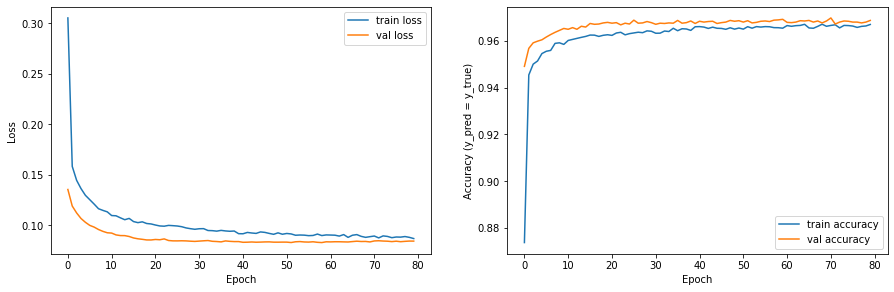

In [46]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [47]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

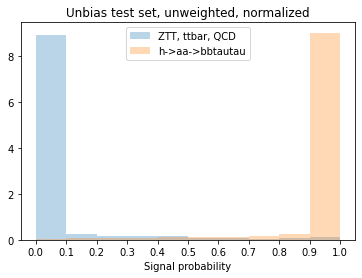

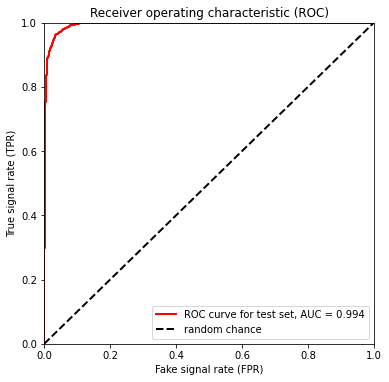

Test loss, test accuracy: [0.09498035553123836, 0.9630594253540039]


In [48]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Unbias test set, unweighted, normalized')
pyplot.xlabel('Signal probability')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

In [ ]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [49]:
from root_numpy import array2root

infolder = 'root_raw/mt18_raw/'
outfolder = 'root_outputs/mt18_outputs/'

inpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths)):
    inpaths[i] = infolder + inpaths[i]
    outpaths[i] = outfolder + outpaths[i]

allfiles = []
for i in range(len(inpaths)):
    allfiles.append(ROOT.RDataFrame('mutau_tree', inpaths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
print(len(allfiles))

46


## Data pre-processing

In [50]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])
    print(inpaths[i])

root_raw/mt18_raw/DY.root
root_raw/mt18_raw/DY1.root
root_raw/mt18_raw/DY2.root
root_raw/mt18_raw/DY3.root
root_raw/mt18_raw/DY4.root
root_raw/mt18_raw/GGHTT.root
root_raw/mt18_raw/GGHWW.root
root_raw/mt18_raw/GGZHLLTT.root
root_raw/mt18_raw/GGZHNNTT.root
root_raw/mt18_raw/GGZHQQTT.root
root_raw/mt18_raw/GGZHWW.root
root_raw/mt18_raw/ST_tW_antitop.root
root_raw/mt18_raw/ST_tW_top.root
root_raw/mt18_raw/ST_t_antitop.root
root_raw/mt18_raw/ST_t_top.root
root_raw/mt18_raw/TTTo2L2Nu.root
root_raw/mt18_raw/TTToHadronic.root
root_raw/mt18_raw/TTToSemiLeptonic.root
root_raw/mt18_raw/VBFHTT.root
root_raw/mt18_raw/VBFHWW.root
root_raw/mt18_raw/VV2L2Nu.root
root_raw/mt18_raw/WZ2L2Q.root
root_raw/mt18_raw/WZ3LNu.root
root_raw/mt18_raw/WminusHTT.root
root_raw/mt18_raw/WminusHWW.root
root_raw/mt18_raw/WplusHTT.root
root_raw/mt18_raw/WplusHWW.root
root_raw/mt18_raw/ZHTT.root
root_raw/mt18_raw/ZHWW.root
root_raw/mt18_raw/ZZ2L2Q.root
root_raw/mt18_raw/ZZ4L.root
root_raw/mt18_raw/data_obs.root
root_raw

## Feed to NN and write outputs to root files

In [51]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred_1b', np.float32)])
    array2root(y_pred, filename = outpaths[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths[i])

root_outputs/mt18_outputs/DY.root
root_outputs/mt18_outputs/DY1.root
root_outputs/mt18_outputs/DY2.root
root_outputs/mt18_outputs/DY3.root
root_outputs/mt18_outputs/DY4.root
root_outputs/mt18_outputs/GGHTT.root
root_outputs/mt18_outputs/GGHWW.root
root_outputs/mt18_outputs/GGZHLLTT.root
root_outputs/mt18_outputs/GGZHNNTT.root
root_outputs/mt18_outputs/GGZHQQTT.root
root_outputs/mt18_outputs/GGZHWW.root
root_outputs/mt18_outputs/ST_tW_antitop.root
root_outputs/mt18_outputs/ST_tW_top.root
root_outputs/mt18_outputs/ST_t_antitop.root
root_outputs/mt18_outputs/ST_t_top.root
root_outputs/mt18_outputs/TTTo2L2Nu.root
root_outputs/mt18_outputs/TTToHadronic.root
root_outputs/mt18_outputs/TTToSemiLeptonic.root
root_outputs/mt18_outputs/VBFHTT.root
root_outputs/mt18_outputs/VBFHWW.root
root_outputs/mt18_outputs/VV2L2Nu.root
root_outputs/mt18_outputs/WZ2L2Q.root
root_outputs/mt18_outputs/WZ3LNu.root
root_outputs/mt18_outputs/WminusHTT.root
root_outputs/mt18_outputs/WminusHWW.root
root_outputs/mt18_